In [1]:
%cd ../

/Users/harrysonghurst/Documents/Coursework/L48 Machine Learning and the Physical World/TrafficEmuCO2MS


In [2]:
# If you get a SciPy error when installing Emukit, build it from source:

# git clone https://github.com/amzn/Emukit.git
# cd Emukit
# pip install -r requirements/requirements.txt
# python setup.py develop

In [3]:
import numpy as np
import pickle
import emukit as ek
import GPy

from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign, latin_design
from emukit.experimental_design.acquisitions import ModelVariance, IntegratedVarianceReduction
from emukit.core.loop import UserFunctionWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core.optimization import GradientAcquisitionOptimizer
import matplotlib.pyplot as plt
import seaborn as sns

from sumo_grid_simulation.grid_simulation import Simulator

sns.set()

### Pseudocode

Fitting a gaussian process to a simulator using Emukit takes the following form (taken from L48 lectures):

```
initialize GP with some randomly chosen points
while stopping condition is not met:
    compute candidate point(s) using GP and acquisition funciton (model_variance) -> new point
    evaluate this new point with our simulator/user function -> observation
    update model with new observation -> new GP
```

### Simulator

In [4]:
simulator = Simulator(end_time=300)

### User Function
 
This is the function we want to understand. Namedly, how are CO2 emissions and timeLoss (the time lost due to driving below the ideal speed) affected by the following parameters: 

```
gridSize: the size of the grid network where the simulation is carried out
edgeMaxSpeed: legal speed limit in m/s - this can be exceeded (11.11 == 40km/h)
maxSpeed: the absolute maximum velocity of any vehicle in m/s (55.55 == 200 km/h)
edgeLength: length of the roads between intersections in meters
numLanes: number of lanes per road
accel: The acceleration ability of vehicles in m/s^2.
```

*A complete list of parmeters analysed is discussed in our report.*

In [5]:
def user_function(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            tlType=1,
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        CO2 = s['CO2']/s['num_emissions_samples']
        # average emissions / average route length
        result.append(CO2)
        i += 1
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

### Model Inputs / parameter space

In [6]:
gridSize = DiscreteParameter('gridSize', domain=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
edgeMaxSpeed = ContinuousParameter('edgeMaxSpeed', min_value=8, max_value=19)
edgeLength = ContinuousParameter('edgeLength', min_value=30, max_value=70)
numberOfLanes = DiscreteParameter('numberOfLanes', domain=[1,2,3])
accel = ContinuousParameter('accel', 1.5, 5.)

parameter_space = ParameterSpace([gridSize, edgeMaxSpeed, edgeLength, numberOfLanes, accel])

### Get init and test points

In [7]:
design = RandomDesign(parameter_space)
init_X = design.get_samples(20)
init_Y = user_function(init_X)

design = RandomDesign(parameter_space)
test_X = design.get_samples(100)
test_Y = user_function(test_X)

[[18.         17.99666841 35.94132763  3.          3.98201218]
 [11.         17.99702989 43.52511504  1.          2.0288647 ]
 [17.         16.22130516 57.73864312  1.          1.83377287]
 [17.         14.79542239 56.66049434  1.          2.19693223]
 [10.          8.41930769 43.54723731  3.          3.19968831]
 [13.         15.01750206 68.73976945  3.          3.05388679]
 [13.         15.89473769 54.29466973  3.          2.56175744]
 [ 8.         13.69944015 69.04632102  1.          4.45560723]
 [ 5.         12.51752232 32.50030723  1.          2.4029509 ]
 [17.         12.39100508 44.11132733  2.          3.58235211]
 [14.         14.73462038 30.00597552  2.          4.86420456]
 [ 3.         10.76171384 46.4746455   2.          4.39858801]
 [20.         16.59784205 45.79180627  1.          2.10891433]
 [12.         17.78417664 48.34247274  1.          4.08217564]
 [ 7.         16.11595783 45.47974201  3.          2.90107029]
 [ 4.         16.97029733 58.47668879  3.          1.59

 Retrying in 1 seconds

Evaluating input: 2 of 100

 Retrying in 1 seconds

Evaluating input: 3 of 100

 Retrying in 1 seconds

Evaluating input: 4 of 100

 Retrying in 1 seconds

Evaluating input: 5 of 100

 Retrying in 1 seconds

Evaluating input: 6 of 100

 Retrying in 1 seconds

Evaluating input: 7 of 100

 Retrying in 1 seconds

Evaluating input: 8 of 100

 Retrying in 1 seconds

Evaluating input: 9 of 100

 Retrying in 1 seconds

Evaluating input: 10 of 100

 Retrying in 1 seconds

Evaluating input: 11 of 100

 Retrying in 1 seconds

Evaluating input: 12 of 100

 Retrying in 1 seconds

Evaluating input: 13 of 100

 Retrying in 1 seconds

Evaluating input: 14 of 100

 Retrying in 1 seconds

Evaluating input: 15 of 100

 Retrying in 1 seconds

Evaluating input: 16 of 100

 Retrying in 1 seconds

Evaluating input: 17 of 100

 Retrying in 1 seconds

Evaluating input: 18 of 100

 Retrying in 1 seconds

Evaluating input: 19 of 100

 Retrying in 1 seconds

Evaluating input: 20 of 100

 

### Experimental Design - Model Variance

In [8]:
MV_Xs = []
MV_Ys = []
mses_MV = []
    
def user_function_model_variance(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            tlType=1,
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        # average time loss / average route duration
        CO2 = s['CO2']/s['num_emissions_samples']
        # average emissions / average route length
        result.append(CO2)
        MV_Xs.append([int(gridSize), edgeMaxSpeed, edgeLength, int(numLanes), accel])
        MV_Ys.append(CO2)

        i += 1
    
    # evaluate / validate model
    if len(MV_Xs) % 50 == 0:
        pred_Y, pred_Y_variance = emukit_model_mv.predict(np.array(test_X))
        rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
        mses_MV.append((len(MV_Xs), rmse))
        print('EVALUATED: ', len(MV_Xs), rmse)
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

#### Model / Emulator (GP)

Our surrogate model is our emulator. In this case, a gaussian process.

In [9]:
emulator_mv = GPy.models.GPRegression(init_X, init_Y)
emukit_model_mv = GPyModelWrapper(emulator_mv, n_restarts=5)
emukit_model_mv.optimize()
emulator_mv

Optimization restart 1/5, f = 144.81053212342147
Optimization restart 2/5, f = 145.96427640606808
Optimization restart 3/5, f = 146.51450799203297
Optimization restart 4/5, f = 146.09652611673081
Optimization restart 5/5, f = 146.09573829791148


GP_regression.,value,constraints,priors
rbf.variance,985333.9845516359,+ve,
rbf.lengthscale,239450.31108189866,+ve,
Gaussian_noise.variance,59265.28531188415,+ve,


#### Acquisition Function

In [10]:
model_variance = ModelVariance(model=emukit_model_mv)

#### Optimizer

In [11]:
optimizer = GradientAcquisitionOptimizer(parameter_space)


#### Experimental Design Loop

In [12]:
ed_loop_mv = ExperimentalDesignLoop(
    model = emukit_model_mv,
    space = parameter_space,
    acquisition = model_variance,
    acquisition_optimizer = optimizer,
    batch_size = 1
)

In [13]:
ed_loop_mv.run_loop(user_function_model_variance, 500)

Optimization restart 1/5, f = 144.81053212342147
Optimization restart 2/5, f = 143.87029063808947


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 3/5, f = 146.4426624902872
Optimization restart 4/5, f = 145.77148618203222
Optimization restart 5/5, f = 144.59337377103398
[[20.         11.8669446  69.9352576   2.          2.69990966]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 151.85041916838023
Optimization restart 2/5, f = 152.30622341657966
Optimization restart 3/5, f = 152.97010762904114
Optimization restart 4/5, f = 154.8924149087332
Optimization restart 5/5, f = 152.8229233527805
[[19.          9.31180863 69.48816086  3.          3.52926181]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 160.08586576505306
Optimization restart 2/5, f = 215.5111297810849
Optimization restart 3/5, f = 160.5787540269642
Optimization restart 4/5, f = 161.27677860452692
Optimization restart 5/5, f = 175.27679966153352
[[20.          8.12511967 30.          1.          1.64409937]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 169.77426239477472
Optimization restart 2/5, f = 169.77166168626647
Optimization restart 3/5, f = 259.99770368278587
Optimization restart 4/5, f = 172.55022146051266
Optimization restart 5/5, f = 232.37343674124128
[[ 4.          9.12975266 69.67364251  1.          3.37344531]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 177.41139182279875
Optimization restart 2/5, f = 178.11653643938308
Optimization restart 3/5, f = 179.48042630890114
Optimization restart 4/5, f = 178.90092342268355
Optimization restart 5/5, f = 179.76198354349137
[[20.          8.91559625 30.05020341  2.          2.06626149]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 185.90811351569812
Optimization restart 2/5, f = 186.61983659691808
Optimization restart 3/5, f = 163.1125919611651
Optimization restart 4/5, f = 186.27116006481785
Optimization restart 5/5, f = 188.56054843165305
[[20.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 169.02165162971832
Optimization restart 2/5, f = 194.1356469208558
Optimization restart 3/5, f = 194.08295617710422
Optimization restart 4/5, f = 211.36038628885012
Optimization restart 5/5, f = 193.83158428265358
[[ 3. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 178.54148468398418
Optimization restart 2/5, f = 206.39464487885954
Optimization restart 3/5, f = 178.53906724124832


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 178.54455709746543
Optimization restart 5/5, f = 178.53906726084853
[[20. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 184.38712670112767
Optimization restart 2/5, f = 214.12479158353517
Optimization restart 3/5, f = 216.35015137553472
Optimization restart 4/5, f = 216.14974063577446
Optimization restart 5/5, f = 215.402452802291
[[ 3.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 190.17552450801747
Optimization restart 2/5, f = 223.08941001855075
Optimization restart 3/5, f = 223.45055453557057
Optimization restart 4/5, f = 219.83830521336068
Optimization restart 5/5, f = 221.78988971962943
[[ 3.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 202.84320514544484
Optimization restart 2/5, f = 730.6361097124532
Optimization restart 3/5, f = 228.9181227074435
Optimization restart 4/5, f = 229.82907026591562
Optimization restart 5/5, f = 230.4744408746714
[[20.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 209.22455431674436
Optimization restart 2/5, f = 235.61522337427397
Optimization restart 3/5, f = 237.50633469731372
Optimization restart 4/5, f = 237.5839856704675
Optimization restart 5/5, f = 236.0682375685822
[[ 3.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 216.4064544554956
Optimization restart 2/5, f = 245.55149814234136
Optimization restart 3/5, f = 245.33334427481026
Optimization restart 4/5, f = 216.40501682692584
Optimization restart 5/5, f = 243.37327323812704
[[ 3. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 222.99208946216805
Optimization restart 2/5, f = 251.44305262735867
Optimization restart 3/5, f = 257.4221272300672
Optimization restart 4/5, f = 283.16844897972555
Optimization restart 5/5, f = 318.8019956684903
[[20.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 228.94752602472218
Optimization restart 2/5, f = 259.35833509180765
Optimization restart 3/5, f = 258.75495045113394
Optimization restart 4/5, f = 259.28655634634407
Optimization restart 5/5, f = 259.5376915057317
[[20.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 235.2765760628146
Optimization restart 2/5, f = 267.22450600421973
Optimization restart 3/5, f = 266.007156998257
Optimization restart 4/5, f = 265.31330059897243
Optimization restart 5/5, f = 266.40619108739986
[[ 3.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 244.92734106598994
Optimization restart 2/5, f = 273.63661431461304
Optimization restart 3/5, f = 271.776646805553
Optimization restart 4/5, f = 273.78596113254576
Optimization restart 5/5, f = 272.65545673030766
[[ 3.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 252.4810933605046
Optimization restart 2/5, f = 281.78783944970553
Optimization restart 3/5, f = 280.79048726868245
Optimization restart 4/5, f = 281.6382153148408
Optimization restart 5/5, f = 299.27732570512194
[[20. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 258.8794120355792
Optimization restart 2/5, f = 289.8542690625625
Optimization restart 3/5, f = 302.7707861015829
Optimization restart 4/5, f = 288.3041928704698
Optimization restart 5/5, f = 287.94233180749006
[[ 3.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 268.58616654450344
Optimization restart 2/5, f = 297.6938144705519
Optimization restart 3/5, f = 295.7570379732105
Optimization restart 4/5, f = 295.34599616767474
Optimization restart 5/5, f = 295.93839756726493
[[20.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 275.52075878576215
Optimization restart 2/5, f = 381.1926841995407
Optimization restart 3/5, f = 305.1061684872644
Optimization restart 4/5, f = 304.31982443338444
Optimization restart 5/5, f = 304.3379129794589
[[ 3.         8.        50.9382841  1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 284.22751631430083
Optimization restart 2/5, f = 313.70319978494706
Optimization restart 3/5, f = 335.9350841594008
Optimization restart 4/5, f = 312.4952242965355
Optimization restart 5/5, f = 389.25951151072127
[[20.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 290.5112112975533
Optimization restart 2/5, f = 319.70800377389935
Optimization restart 3/5, f = 320.9528426468969
Optimization restart 4/5, f = 321.4099651729731
Optimization restart 5/5, f = 321.1130301550843
[[ 3.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 298.32535712627333
Optimization restart 2/5, f = 327.8596731483035
Optimization restart 3/5, f = 326.520808258094
Optimization restart 4/5, f = 328.5656305822829


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 363.7578294430394
[[ 3.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 304.9802095871116
Optimization restart 2/5, f = 756.9502074714053
Optimization restart 3/5, f = 335.75206563503957
Optimization restart 4/5, f = 334.1343662942356
Optimization restart 5/5, f = 329.79695882608456
[[ 3.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 311.2326334212939
Optimization restart 2/5, f = 340.3680154620307
Optimization restart 3/5, f = 342.43884757554656
Optimization restart 4/5, f = 339.8041438597605


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 310.6629080673727
[[20.          8.         50.58853513  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 316.7786540161558
Optimization restart 2/5, f = 346.4777359657726
Optimization restart 3/5, f = 351.05973418292626
Optimization restart 4/5, f = 349.8115073628756
Optimization restart 5/5, f = 433.34507030077464
[[20.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 322.822359685623
Optimization restart 2/5, f = 300.5502571381985
Optimization restart 3/5, f = 357.89096463692186
Optimization restart 4/5, f = 357.71184285288916
Optimization restart 5/5, f = 355.9172127626929
[[20.         16.91687561 55.67988614  3.          4.62697149]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 306.31250923022617
Optimization restart 2/5, f = 365.36223688676455
Optimization restart 3/5, f = 1793.36105079514
Optimization restart 4/5, f = 364.8686358730672
Optimization restart 5/5, f = 363.56266150477916
[[ 3.          8.55235244 45.07526924  3.          1.60433958]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 312.9828978792159
Optimization restart 2/5, f = 372.00836327301573
Optimization restart 3/5, f = 371.67650002306743
Optimization restart 4/5, f = 371.09735364554257


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 406.3064717308247
[[ 3.         17.99354049 54.31767249  1.          1.70796737]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 319.70842583524194
Optimization restart 2/5, f = 380.1126761962678
Optimization restart 3/5, f = 378.3243531189392
Optimization restart 4/5, f = 319.66072783576357
Optimization restart 5/5, f = 471.55170206258254
[[ 9.          8.07870529 59.87144575  3.          4.51579869]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 325.3830729180077
Optimization restart 2/5, f = 386.10589762327396
Optimization restart 3/5, f = 385.39106825905526
Optimization restart 4/5, f = 325.3822989182972
Optimization restart 5/5, f = 387.56765329273327
[[ 9.          8.21337362 30.40419536  2.          2.0674956 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 332.4638365704717
Optimization restart 2/5, f = 394.5921819272604
Optimization restart 3/5, f = 395.28160736442095
Optimization restart 4/5, f = 332.40227159669286


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 401.32828601388434
[[20.          8.56484633 40.73197109  1.          2.30187548]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 338.0302539901869
Optimization restart 2/5, f = 402.178565966469
Optimization restart 3/5, f = 532.2370521267098
Optimization restart 4/5, f = 1113.3967837570258
Optimization restart 5/5, f = 401.20533572085753
[[20.          8.22942766 60.19512556  3.          1.56851373]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 344.8085926090735
Optimization restart 2/5, f = 408.83744696460093
Optimization restart 3/5, f = 407.35839729489663
Optimization restart 4/5, f = 416.026260034292
Optimization restart 5/5, f = 409.06810101598023
[[ 3.         12.33200874 62.76005243  1.          4.96681979]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 350.51064383444555
Optimization restart 2/5, f = 416.59466480133665
Optimization restart 3/5, f = 417.006026614725
Optimization restart 4/5, f = 415.023217006206
Optimization restart 5/5, f = 417.2545206257314
[[15.         18.9611954  69.86171249  1.          4.93073038]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 355.9141637773108
Optimization restart 2/5, f = 426.30953567175675
Optimization restart 3/5, f = 434.9348999418303
Optimization restart 4/5, f = 426.667812337412
Optimization restart 5/5, f = 1164.437401446257
[[ 9.         18.82132025 30.35400294  1.          2.44021394]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 368.5972909285252
Optimization restart 2/5, f = 444.7432617804773
Optimization restart 3/5, f = 388.48571351151264
Optimization restart 4/5, f = 434.1471970000762
Optimization restart 5/5, f = 368.37670393270787
[[ 8.          8.         55.15994349  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 375.2728477630129
Optimization restart 2/5, f = 441.5897216593207
Optimization restart 3/5, f = 442.9352065794046
Optimization restart 4/5, f = 375.2618004972744
Optimization restart 5/5, f = 441.26676558663814
[[19.          8.07506208 50.59294567  3.          1.91558893]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 382.3028385838675
Optimization restart 2/5, f = 449.0231140632859
Optimization restart 3/5, f = 450.0028259197644
Optimization restart 4/5, f = 448.2768977503067
Optimization restart 5/5, f = 552.6190826888983
[[13.          8.09603774 68.36988279  1.          3.03459621]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 388.5561809341313
Optimization restart 2/5, f = 456.04929387406924
Optimization restart 3/5, f = 407.7522655017379
Optimization restart 4/5, f = 457.1998658016393
Optimization restart 5/5, f = 456.6808378713265
[[ 3.         18.83345222 47.35764845  3.          3.78454386]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 395.34345938369427
Optimization restart 2/5, f = 463.88295354484643
Optimization restart 3/5, f = 395.3384217482764


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 623.1526700732156
Optimization restart 5/5, f = 464.97748410490885
[[20.         14.4600627  65.87556034  1.          4.93264262]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 401.3189988360923
Optimization restart 2/5, f = 471.1950698868382
Optimization restart 3/5, f = 471.08654004692966
Optimization restart 4/5, f = 470.28895132203024
Optimization restart 5/5, f = 471.71437161924763
[[16.          8.07213481 55.88809153  1.          4.63075175]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 407.0354881888217
Optimization restart 2/5, f = 478.441694466234
Optimization restart 3/5, f = 479.7750936677238
Optimization restart 4/5, f = 426.6247822795066
Optimization restart 5/5, f = 407.032567692646
[[20.         14.92961423 31.72689783  1.          2.36505268]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 413.88593266933105
Optimization restart 2/5, f = 483.4795638794851
Optimization restart 3/5, f = 485.44112010914387
Optimization restart 4/5, f = 599.6763353477903
Optimization restart 5/5, f = 486.34171211198077
[[ 7.          8.9755997  30.00380606  1.          4.41831717]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 421.60544791801635
Optimization restart 2/5, f = 493.2000635904037
Optimization restart 3/5, f = 1100.7009462585577
Optimization restart 4/5, f = 493.5272982293782
Optimization restart 5/5, f = 421.50046386133545
[[ 3.          8.4339974  38.94374083  1.          3.00889885]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 427.49041767012665
Optimization restart 2/5, f = 440.6245579387494
Optimization restart 3/5, f = 501.1408367408099
Optimization restart 4/5, f = 440.6245580138875
Optimization restart 5/5, f = 427.48679881763167
[[11.         18.9961209  66.19537418  3.          1.76804236]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 435.46781592548155
Optimization restart 2/5, f = 446.2089284895711
Optimization restart 3/5, f = 507.8463289175373


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 561.3222415108805
Optimization restart 5/5, f = 508.27855747236447
[[20.          9.37626475 37.55781864  3.          1.61293808]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 449.8125139422823
Optimization restart 2/5, f = 516.4773420207248
Optimization restart 3/5, f = 513.9269752860629
Optimization restart 4/5, f = 515.443436311004
Optimization restart 5/5, f = 515.3628591380824
[[ 3.          8.         60.96014071  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 456.77858018429936
Optimization restart 2/5, f = 456.7526905394962
Optimization restart 3/5, f = 522.2359808771271
Optimization restart 4/5, f = 523.1755919605206
Optimization restart 5/5, f = 523.4908436883394
[[15.          8.20839145 36.70809171  1.          4.95098811]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  50 68.1908563945574
Optimization restart 1/5, f = 463.23422317057174
Optimization restart 2/5, f = 531.1501194768836
Optimization restart 3/5, f = 530.5372408121693


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 464.57105819881485
Optimization restart 5/5, f = 530.2603361509548
[[13.         18.62046253 61.94737436  1.          4.55284752]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 468.7960660860325
Optimization restart 2/5, f = 541.1442152233919
Optimization restart 3/5, f = 539.6759024148922
Optimization restart 4/5, f = 541.2734847725505


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 470.03614801729054
[[ 9.         18.68748203 39.50557814  3.          4.54539667]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 474.56740554319043
Optimization restart 2/5, f = 475.65702265239935
Optimization restart 3/5, f = 546.916144378427
Optimization restart 4/5, f = 548.2277282584769
Optimization restart 5/5, f = 475.6570226538097
[[ 4.         18.76533077 36.34737312  2.          1.86627425]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 481.63676308010156
Optimization restart 2/5, f = 553.9863419194019
Optimization restart 3/5, f = 555.7177287966133
Optimization restart 4/5, f = 554.1295439948501
Optimization restart 5/5, f = 554.3302480260277
[[16.         18.68713575 31.15473683  1.          2.04112099]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 488.4744309316298
Optimization restart 2/5, f = 488.4733296005903
Optimization restart 3/5, f = 695.2016599870705
Optimization restart 4/5, f = 562.7690036146881
Optimization restart 5/5, f = 562.9840403670574
[[20.         18.80651002 45.42266339  3.          3.11786825]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 494.2594684433387
Optimization restart 2/5, f = 570.1709778678393
Optimization restart 3/5, f = 597.7409179700396
Optimization restart 4/5, f = 569.8342483527501
Optimization restart 5/5, f = 569.8535119698936
[[20.         18.60209598 39.31551106  1.          4.47033951]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 501.74257895673964
Optimization restart 2/5, f = 577.2291633256463
Optimization restart 3/5, f = 576.7082150152117


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1225.038721282535
Optimization restart 5/5, f = 500.93117663127316
[[ 3. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 507.0480267066762
Optimization restart 2/5, f = 661.6619515838117
Optimization restart 3/5, f = 594.9355225439592
Optimization restart 4/5, f = 507.02411442325035
Optimization restart 5/5, f = 584.6267839317288
[[ 3.         19.         44.92653941  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 512.565840689557
Optimization restart 2/5, f = 530.7251727665678
Optimization restart 3/5, f = 512.1806191102692
Optimization restart 4/5, f = 593.2787082191146
Optimization restart 5/5, f = 542.4106451077515
[[ 3.         13.26538726 69.64198545  3.          4.34671507]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 517.6030494720927
Optimization restart 2/5, f = 715.4586574807174
Optimization restart 3/5, f = 599.8470682620682


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 518.1532697848138
Optimization restart 5/5, f = 741.2389364448559
[[ 4.          8.3301847  39.41681791  3.          4.94832359]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 523.6394969812443
Optimization restart 2/5, f = 607.3646280489336


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 536.0867920705424
Optimization restart 4/5, f = 523.6388008546324
Optimization restart 5/5, f = 523.6405230711441
[[20.         19.         63.71699141  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 529.2745378518099
Optimization restart 2/5, f = 554.0864913861817
Optimization restart 3/5, f = 529.0066695406659
Optimization restart 4/5, f = 759.7548192195002
Optimization restart 5/5, f = 582.4811315136586
[[20.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 534.5336329425193
Optimization restart 2/5, f = 534.5320691398317
Optimization restart 3/5, f = 622.3955908390212
Optimization restart 4/5, f = 534.532069183426


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 534.532069139513
[[20.         19.         56.79396554  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 540.1050912490682
Optimization restart 2/5, f = 630.0066667414515
Optimization restart 3/5, f = 540.0931750083577
Optimization restart 4/5, f = 540.093175016479
Optimization restart 5/5, f = 631.6032112757074
[[ 3.         12.19962564 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 545.5103273263363
Optimization restart 2/5, f = 558.1453155301102
Optimization restart 3/5, f = 638.7040952500262
Optimization restart 4/5, f = 545.510225580069
Optimization restart 5/5, f = 759.9533051171153
[[20.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 556.0620080453416
Optimization restart 2/5, f = 882.7905712921232
Optimization restart 3/5, f = 645.6208805788742
Optimization restart 4/5, f = 555.9825012892435
Optimization restart 5/5, f = 675.0595858934312
[[ 3.         19.         59.68301209  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 562.6799781158554
Optimization restart 2/5, f = 800.5539289735274
Optimization restart 3/5, f = 562.6793698463534
Optimization restart 4/5, f = 588.0726718846067
Optimization restart 5/5, f = 652.8678428346379
[[20. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 568.1426314743203
Optimization restart 2/5, f = 609.8683204171873
Optimization restart 3/5, f = 660.1829516905644
Optimization restart 4/5, f = 1885.177972675651
Optimization restart 5/5, f = 568.1425852540286
[[ 3. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 575.4446476475714
Optimization restart 2/5, f = 575.4442497759236


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 911.8118048007155
Optimization restart 4/5, f = 575.4442497819348
Optimization restart 5/5, f = 824.4402327874408
[[20.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 580.8944544197071


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 580.894454393998
Optimization restart 3/5, f = 580.8944542255683
Optimization restart 4/5, f = 580.8944542209794
Optimization restart 5/5, f = 618.1029165921984
[[11. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 586.6928815602998
Optimization restart 2/5, f = 846.863427283521
Optimization restart 3/5, f = 685.8957766763357
Optimization restart 4/5, f = 586.6922549399567
Optimization restart 5/5, f = 2500.873053634099
[[20.          8.         55.28213067  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 592.1492211288574
Optimization restart 2/5, f = 592.1491550667772
Optimization restart 3/5, f = 693.4544516681931
Optimization restart 4/5, f = 694.9306910994048
Optimization restart 5/5, f = 592.1491575958268
[[12.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 598.2636841072116
Optimization restart 2/5, f = 598.9963689000529
Optimization restart 3/5, f = 701.2568049521702
Optimization restart 4/5, f = 4084.1737377857216
Optimization restart 5/5, f = 702.0957446671135
[[20.         13.27276754 30.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 604.6202321443577
Optimization restart 2/5, f = 709.7432672435738
Optimization restart 3/5, f = 710.019964338378
Optimization restart 4/5, f = 704.3671832659682


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 640.8504506983085
[[20.         19.         47.83830733  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 609.985844202552
Optimization restart 2/5, f = 716.3951783233277


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 609.9848718457438
Optimization restart 4/5, f = 609.9848718726123
Optimization restart 5/5, f = 666.3561939118554
[[20.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 615.3514278834298
Optimization restart 2/5, f = 615.3489978422773
Optimization restart 3/5, f = 615.3489979946269


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 615.3489978429096
Optimization restart 5/5, f = 721.3902912942401
[[11.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 621.0731725012658
Optimization restart 2/5, f = 729.1302683495779
Optimization restart 3/5, f = 900.8188457725598


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 708.61605088227
Optimization restart 5/5, f = 621.0653570991225
[[11.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 627.7381396629469
Optimization restart 2/5, f = 627.6995178318455
Optimization restart 3/5, f = 911.918857000609
Optimization restart 4/5, f = 736.8022241136589
Optimization restart 5/5, f = 837.7609203626423
[[ 3.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 633.525359392242
Optimization restart 2/5, f = 633.5096975407243
Optimization restart 3/5, f = 665.9138763420227
Optimization restart 4/5, f = 633.5096976107893
Optimization restart 5/5, f = 745.6451128236033
[[ 3.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 639.4978470457844
Optimization restart 2/5, f = 639.4947764207986


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 639.4947764211776
Optimization restart 4/5, f = 751.617138809367


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 750.9351661767178
[[ 3.          8.         43.19826971  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 644.8591813811281
Optimization restart 2/5, f = 644.8591250178541
Optimization restart 3/5, f = 796.2399948285382


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 760.2576795422832
Optimization restart 5/5, f = 644.8591249894794
[[ 3.         19.         41.21971855  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 650.6329238535608
Optimization restart 2/5, f = 650.6269905970979
Optimization restart 3/5, f = 650.6269905074739
Optimization restart 4/5, f = 650.6269905238346
Optimization restart 5/5, f = 650.6269905085956
[[20.          8.         39.28661573  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 655.9573191491568
Optimization restart 2/5, f = 655.9545564964266
Optimization restart 3/5, f = 840.2672723414227


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 773.7137433545738
Optimization restart 5/5, f = 788.5333868996464
[[20.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 661.3732346988878
Optimization restart 2/5, f = 661.372966588295
Optimization restart 3/5, f = 661.372966564805
Optimization restart 4/5, f = 776.7063306220232


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 661.3729665652122
[[20.         12.73232402 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 666.959303648408
Optimization restart 2/5, f = 666.9512181965395
Optimization restart 3/5, f = 789.1348941417971
Optimization restart 4/5, f = 666.9512181832487
Optimization restart 5/5, f = 822.3814507665843
[[20.         8.        60.0680185  1.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 672.6202438327072
Optimization restart 2/5, f = 796.0053484240503
Optimization restart 3/5, f = 672.6179456051029
Optimization restart 4/5, f = 1200.2007588071929
Optimization restart 5/5, f = 1695.3991470247358


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[ 3.        19.        60.7731089  3.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 678.8532292146241
Optimization restart 2/5, f = 807.1856265775402
Optimization restart 3/5, f = 805.7534704881447
Optimization restart 4/5, f = 678.8424847527225
Optimization restart 5/5, f = 678.8424849479085
[[11. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 684.1445134183134


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 686.2569668979854
Optimization restart 3/5, f = 796.5923966887761
Optimization restart 4/5, f = 3628.934826788493
Optimization restart 5/5, f = 684.1445038236676
[[20. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 689.4591416494118
Optimization restart 2/5, f = 689.4591370285773
Optimization restart 3/5, f = 809.1662981258709


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 5230.138909015303
Optimization restart 5/5, f = 824.4429732840081
[[ 3.          8.         58.07637554  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 695.0467980739685
Optimization restart 2/5, f = 695.0347282587327
Optimization restart 3/5, f = 831.5064338155838
Optimization restart 4/5, f = 834.5312928617027


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 695.0347282523533
[[10.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 700.3593086097898
Optimization restart 2/5, f = 700.3589498161975
Optimization restart 3/5, f = 2604.953644639683


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 700.3589463361614


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 700.358948192483
[[ 3.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 705.616220821879
Optimization restart 2/5, f = 705.6162156326833
Optimization restart 3/5, f = 2295.3191698133733


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 706.3931375003199
Optimization restart 5/5, f = 705.6162156401309
[[ 3. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 710.8656142297241
Optimization restart 2/5, f = 843.8167467611186
Optimization restart 3/5, f = 710.8630233231673
Optimization restart 4/5, f = 840.3220187650769
Optimization restart 5/5, f = 2994.3386613772327
[[ 3.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 716.18214335532
Optimization restart 2/5, f = 716.1762296738942
Optimization restart 3/5, f = 716.1762296742797
Optimization restart 4/5, f = 863.5582930380043
Optimization restart 5/5, f = 720.1700527423242
[[20.         19.         55.09772402  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 721.408481308137
Optimization restart 2/5, f = 721.4059449699555
Optimization restart 3/5, f = 725.8049851193949
Optimization restart 4/5, f = 721.4059449697284
Optimization restart 5/5, f = 868.5919490030683
[[20.         19.         46.09355563  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 726.608730008785
Optimization restart 2/5, f = 877.0760972846451
Optimization restart 3/5, f = 731.239537711146
Optimization restart 4/5, f = 731.2333589146511
Optimization restart 5/5, f = 726.6087185749881
[[11.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 731.9635139854086
Optimization restart 2/5, f = 886.0626858675902
Optimization restart 3/5, f = 884.1686124817334
Optimization restart 4/5, f = 738.1774710558739


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 731.9582664807665
[[14.         8.        40.4724827  1.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 737.3268772802267
Optimization restart 2/5, f = 737.3224539224022
Optimization restart 3/5, f = 744.0654546147692
Optimization restart 4/5, f = 744.0740012213491
Optimization restart 5/5, f = 811.9350156120908


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[ 3.        13.6229613 30.         1.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 742.8540188080282
Optimization restart 2/5, f = 1074.1515992501581
Optimization restart 3/5, f = 895.1539676175205
Optimization restart 4/5, f = 742.8536363672808


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 742.8536366734409
[[ 3.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 748.0583377488857
Optimization restart 2/5, f = 909.2514994479792
Optimization restart 3/5, f = 748.0582498880192
Optimization restart 4/5, f = 1108.064265036014


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 780.8669998927625
[[ 3.         19.         61.14303432  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  100 53.98265451515596
Optimization restart 1/5, f = 753.8084331223455


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 753.8071821072209
Optimization restart 3/5, f = 917.6089240473751
Optimization restart 4/5, f = 972.2250652840731
Optimization restart 5/5, f = 751.5802397354869
[[ 3.         13.33969236 38.02271741  3.          1.8692666 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 758.2861755364477
Optimization restart 2/5, f = 924.8579288046762


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 793.4310182531707
Optimization restart 4/5, f = 758.3468252539373
Optimization restart 5/5, f = 1127.7676503081468
[[12.          9.20413936 47.44819612  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 764.2694193671385
Optimization restart 2/5, f = 764.3854385652227
Optimization restart 3/5, f = 764.3854385688701
Optimization restart 4/5, f = 764.3854386191049
Optimization restart 5/5, f = 930.75466804605
[[10.         11.31772078 60.7086827   1.          1.82602622]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 770.3486659725122
Optimization restart 2/5, f = 938.9727408674669


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1063.4860446730804
Optimization restart 4/5, f = 904.6493429146254
Optimization restart 5/5, f = 770.3129629912606
[[14.         13.71241699 37.27611543  3.          1.62396282]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 776.1590046260422
Optimization restart 2/5, f = 776.4849412054942
Optimization restart 3/5, f = 776.1552446922327
Optimization restart 4/5, f = 776.156030882891
Optimization restart 5/5, f = 776.4849411965831
[[20.         12.07865254 50.29890288  1.          4.92962713]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 782.0103843190668
Optimization restart 2/5, f = 782.013439464835
Optimization restart 3/5, f = 781.7939475863293
Optimization restart 4/5, f = 1444.8506103396862


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1079.8110701145295
[[13.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 787.7206178556787
Optimization restart 2/5, f = 789.3178691146946
Optimization restart 3/5, f = 787.7205624972537
Optimization restart 4/5, f = 787.7205638125647
Optimization restart 5/5, f = 1171.5285125201906
[[ 3.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 793.0035824934944
Optimization restart 2/5, f = 967.1896190446756
Optimization restart 3/5, f = 966.2879511244265
Optimization restart 4/5, f = 793.0001464871549
Optimization restart 5/5, f = 793.0001464225106
[[20.          8.         46.28947153  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 798.2881351795638
Optimization restart 2/5, f = 798.287890112926
Optimization restart 3/5, f = 974.5110789310613
Optimization restart 4/5, f = 799.7446226518533


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 845.8626054631394
[[20. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 803.4261165547958
Optimization restart 2/5, f = 985.7486296934901
Optimization restart 3/5, f = 791.7109416121264
Optimization restart 4/5, f = 803.4261066727892


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 808.1631449327452
[[10.         11.29324094 47.86125757  1.          1.70528349]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 797.7863226974014
Optimization restart 2/5, f = 797.7403629202545
Optimization restart 3/5, f = 990.0495279859537
Optimization restart 4/5, f = 797.7657553044257
Optimization restart 5/5, f = 808.485692388276
[[19.          8.22791304 63.85830416  3.          4.76224583]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 803.6027836592222
Optimization restart 2/5, f = 999.1835505952818
Optimization restart 3/5, f = 813.6003385808298
Optimization restart 4/5, f = 803.6201448866809
Optimization restart 5/5, f = 1042.4127840317137
[[ 5.         14.25084474 65.75188835  1.          1.59385862]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 809.6635803609963
Optimization restart 2/5, f = 820.9461823206068
Optimization restart 3/5, f = 1005.2718720214359
Optimization restart 4/5, f = 836.4570183737179
Optimization restart 5/5, f = 820.9461822949031
[[20.         13.63028485 37.9502512   3.          4.5070341 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 815.92980207562
Optimization restart 2/5, f = 1012.2033408649866
Optimization restart 3/5, f = 826.9654685932829
Optimization restart 4/5, f = 815.8922163794273
Optimization restart 5/5, f = 1011.5864876967966
[[10.         18.99436839 55.40539812  1.          2.01228892]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 822.0652960213018
Optimization restart 2/5, f = 833.0803620029035
Optimization restart 3/5, f = 833.0803619997937
Optimization restart 4/5, f = 1021.6661275500578


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 842.2583364115278
[[20.         12.27048239 48.41635517  3.          1.54298929]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 827.7812591127282
Optimization restart 2/5, f = 827.8117440540082


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 841.2261594123311
Optimization restart 4/5, f = 1027.2968217119683
Optimization restart 5/5, f = 1029.2270186453914
[[11.          8.41993776 54.78121526  3.          1.89722849]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 833.3005193005762
Optimization restart 2/5, f = 844.612560208961
Optimization restart 3/5, f = 1033.9279267939544


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1035.3377659046234
Optimization restart 5/5, f = 833.340943291509
[[ 3.          8.01750441 58.42436609  1.          2.78889788]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 838.7698614882066
Optimization restart 2/5, f = 849.750668563664
Optimization restart 3/5, f = 838.7660399981185
Optimization restart 4/5, f = 849.7449053861221
Optimization restart 5/5, f = 838.7901297403516
[[10.         10.77808753 52.10767351  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 844.5870789733345
Optimization restart 2/5, f = 2251.8399638586784
Optimization restart 3/5, f = 1033.7960453095452
Optimization restart 4/5, f = 2146.343265047245
Optimization restart 5/5, f = 855.1291322147848
[[ 4.          8.1546724  65.36191899  1.          4.68804153]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 850.1267441563737
Optimization restart 2/5, f = 850.1989381589337
Optimization restart 3/5, f = 1056.92197257127
Optimization restart 4/5, f = 850.2126924420955


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 861.4095688541462
[[ 7.          8.04463432 34.84924778  3.          3.51299277]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 855.6666584986331
Optimization restart 2/5, f = 855.6692332703337
Optimization restart 3/5, f = 865.5633283786472
Optimization restart 4/5, f = 1304.4008136471025
Optimization restart 5/5, f = 1303.3987736813447
[[17.         18.83135739 53.58759744  3.          4.61331189]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 861.1504533747994
Optimization restart 2/5, f = 861.178273310916
Optimization restart 3/5, f = 870.6404155433112
Optimization restart 4/5, f = 870.6404154475924


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 930.6142856979517
[[ 7.         13.71712131 64.2315055   3.          4.966279  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 867.8074185406927
Optimization restart 2/5, f = 875.8697672036196
Optimization restart 3/5, f = 875.8697672038105
Optimization restart 4/5, f = 875.8697678880109
Optimization restart 5/5, f = 875.8697672032783
[[16.         19.         41.51940969  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 874.2202142715184
Optimization restart 2/5, f = 1096.9272279491295
Optimization restart 3/5, f = 1332.5480438374752
Optimization restart 4/5, f = 1086.8009097455467
Optimization restart 5/5, f = 881.0327896967985
[[ 3.         16.97603429 39.60437365  3.          4.90572544]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 884.599813479514
Optimization restart 2/5, f = 884.6203840314338


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 892.3509111487799
Optimization restart 4/5, f = 890.1629147046137
Optimization restart 5/5, f = 890.1629125292262
[[20.         18.33002787 36.66115669  3.          1.76310106]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 890.8459720303488
Optimization restart 2/5, f = 1101.544468768086
Optimization restart 3/5, f = 895.2479314472371
Optimization restart 4/5, f = 2852.470901640915


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 935.1258965797132
[[12.          8.98281608 66.45583111  3.          4.98146056]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 896.2342143857883
Optimization restart 2/5, f = 1110.0698686899416
Optimization restart 3/5, f = 896.2740198328773
Optimization restart 4/5, f = 1362.4997394412967
Optimization restart 5/5, f = 900.4945019113409
[[17.         11.66934019 69.60428389  1.          1.53305706]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 902.4797038414965
Optimization restart 2/5, f = 2623.5710304617432
Optimization restart 3/5, f = 902.4501120064663
Optimization restart 4/5, f = 1367.6381716572566
Optimization restart 5/5, f = 902.4904641252394
[[ 9.         10.39011588 39.55640131  1.          1.60706458]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 912.1334906678608
Optimization restart 2/5, f = 910.6745284011247
Optimization restart 3/5, f = 910.674527890086
Optimization restart 4/5, f = 1124.3612564126424
Optimization restart 5/5, f = 914.9339877262237
[[ 3.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 916.1722546236841
Optimization restart 2/5, f = 916.1699355841282
Optimization restart 3/5, f = 904.0740324416955
Optimization restart 4/5, f = 916.1699356071263


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 937.034626437971
[[15.         10.07772402 30.24415397  1.          1.97547414]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 915.9856983136698


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1104.9631427710938
Optimization restart 3/5, f = 921.2498745142526
Optimization restart 4/5, f = 915.9615392084712
Optimization restart 5/5, f = 915.994730803667
[[20.         11.96742037 64.10265807  3.          1.76078729]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 921.8083079409125
Optimization restart 2/5, f = 921.8091280271744
Optimization restart 3/5, f = 1147.7591412956206


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 921.8160495154827
Optimization restart 5/5, f = 1368.704143048093
[[16.          8.01409028 64.55213419  2.          1.56765417]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 927.7729798328528
Optimization restart 2/5, f = 1159.177865550517
Optimization restart 3/5, f = 933.2449174543217
Optimization restart 4/5, f = 1112.0675062358405
Optimization restart 5/5, f = 933.2449174540089
[[12.         18.8331083  34.42120959  1.          4.66852438]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 933.7281137613327
Optimization restart 2/5, f = 1423.9207196413956
Optimization restart 3/5, f = 933.7216471655333


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 933.7436828958113
Optimization restart 5/5, f = 1444.7245327295127
[[ 7.          8.20719578 64.21627927  1.          1.63789481]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 939.1803963481277
Optimization restart 2/5, f = 943.8466818717635
Optimization restart 3/5, f = 943.8466819821415
Optimization restart 4/5, f = 939.1687114521858
Optimization restart 5/5, f = 943.8466818219194
[[17.         10.41581176 59.2265561   3.          4.88224413]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 944.7226610300137
Optimization restart 2/5, f = 949.2545781706317
Optimization restart 3/5, f = 949.2545781717201
Optimization restart 4/5, f = 1438.1690315199319
Optimization restart 5/5, f = 1177.4195093896342
[[20.          9.60027207 33.93855516  1.          4.89288491]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 950.087072765009
Optimization restart 2/5, f = 954.5570960229184
Optimization restart 3/5, f = 1273.7066697777536


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1451.1808504431767
Optimization restart 5/5, f = 954.557096128495
[[16.         17.18330235 63.12567209  3.          4.86343914]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 955.4015106262602
Optimization restart 2/5, f = 959.8277688851891
Optimization restart 3/5, f = 955.4029099982861


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 959.8277689262683
Optimization restart 5/5, f = 955.4068185652051
[[ 4.          8.42110322 53.62189762  3.          1.58732105]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 960.9558562162304
Optimization restart 2/5, f = 960.9810711659917


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1038.7191364162838
Optimization restart 4/5, f = 1273.2827828198967
Optimization restart 5/5, f = 965.2385219706487
[[11.         14.07207993 40.95451524  3.          4.71490588]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 966.8525690156332
Optimization restart 2/5, f = 966.8511273592351


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1019.7312456346865
Optimization restart 4/5, f = 1201.6650458395607
Optimization restart 5/5, f = 973.4908396572171
[[16.         18.56401991 50.23976074  1.          1.81125006]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 974.2218623567167
Optimization restart 2/5, f = 1487.8757523882
Optimization restart 3/5, f = 1216.3085361249116
Optimization restart 4/5, f = 1218.3036738407104


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1008.6383854173725
[[ 3.         14.2422862  34.16682053  3.          4.66080979]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 979.6172561558058
Optimization restart 2/5, f = 1222.2048973854296
Optimization restart 3/5, f = 1493.9317985406533
Optimization restart 4/5, f = 979.6039943211149
Optimization restart 5/5, f = 1222.4404907613286
[[11.         13.87470256 56.95806827  1.          4.9365142 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 985.1510734848089
Optimization restart 2/5, f = 985.2631204486036
Optimization restart 3/5, f = 990.845098588627


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 995.523508720446
Optimization restart 5/5, f = 985.1784444781799
[[ 3.         14.89809134 49.15292638  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 990.8440166765168
Optimization restart 2/5, f = 1236.185895376458
Optimization restart 3/5, f = 995.9227167301297
Optimization restart 4/5, f = 995.9227167293246
Warning - optimization restart 5/5 failed


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


[[ 8.         15.30202749 30.18509029  3.          2.84726586]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 997.0656697771822
Optimization restart 2/5, f = 1000.9858505652965
Optimization restart 3/5, f = 1225.0835291653586


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1302.6271881121902


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1005.2537174681042
[[ 3.         16.36194339 66.42219652  1.          3.24875829]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1002.3499870178075
Optimization restart 2/5, f = 1008.8968670494078
Optimization restart 3/5, f = 2262.282522083682


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1002.397954466398
Optimization restart 5/5, f = 1002.3338574807017
[[ 3.         13.65486646 46.52313936  1.          2.21445302]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 1009.4943411645413
Optimization restart 2/5, f = 3963.078993299938
Optimization restart 3/5, f = 1014.1559750977847
Optimization restart 4/5, f = 1014.1559704061492
Optimization restart 5/5, f = 1014.1559703740432
[[20.         18.84427115 65.3207853   1.          4.3484683 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1014.9105966992825
Optimization restart 2/5, f = 1019.2370097198722
Optimization restart 3/5, f = 1019.2370097191506
Optimization restart 4/5, f = 1019.2370097229458
Optimization restart 5/5, f = 1267.3781099947157
[[ 3.         18.98125424 52.92716302  1.          4.58075871]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1028.732688076024
Optimization restart 2/5, f = 1024.8158047050138
Optimization restart 3/5, f = 1024.8158044243096
Optimization restart 4/5, f = 1024.815804423653
Optimization restart 5/5, f = 1024.8158044237234
[[20.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1029.9431242721405
Optimization restart 2/5, f = 1029.9431222198407


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1213.8914011310917
Optimization restart 4/5, f = 1765.5196137631558
Optimization restart 5/5, f = 1029.943124818495
[[ 3.        19.        48.0117329  3.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  150 47.47998393363013
Optimization restart 1/5, f = 1035.2686275264175


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 1292.0481260594233
Optimization restart 3/5, f = 1026.547050074859
Optimization restart 4/5, f = 1026.58471533534
Optimization restart 5/5, f = 1290.482529065455
[[13.          8.06337906 34.29541051  2.          1.82721331]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1042.7632416298923
Optimization restart 2/5, f = 1299.6837759208508
Optimization restart 3/5, f = 1586.810285394649
Optimization restart 4/5, f = 1044.1315520933538
Optimization restart 5/5, f = 1300.3928879289751
[[19.         18.76851965 40.22788745  1.          1.54612861]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1048.32132808253
Optimization restart 2/5, f = 1048.2731192742824
Optimization restart 3/5, f = 1305.251938319604
Optimization restart 4/5, f = 1049.2347900263862
Optimization restart 5/5, f = 1048.2761847361735
[[ 6.          8.45809993 44.20164967  1.          4.74612232]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 1053.6519666981621
Optimization restart 2/5, f = 7061.096691212393
Optimization restart 3/5, f = 1180.4837426194476
Optimization restart 4/5, f = 1054.3648418668322
Optimization restart 5/5, f = 1312.90941214966
[[ 8.         11.97472214 69.89542407  1.          1.55643637]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1059.1615982700944


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1059.515435011889
Optimization restart 3/5, f = 1059.5154350064613
Optimization restart 4/5, f = 1059.1554715965935
Optimization restart 5/5, f = 1059.1481825331707
[[ 7.         18.95170469 66.58288915  1.          1.81161078]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1064.753654561015
Optimization restart 2/5, f = 1064.7560030757213
Optimization restart 3/5, f = 1065.1932912510683
Optimization restart 4/5, f = 1065.4914931624203


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1064.7574800525235
[[17.          8.4723615  42.73155356  3.          1.79748306]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1070.1434848263268
Optimization restart 2/5, f = 1070.1308552730216
Optimization restart 3/5, f = 1071.196008571867
Optimization restart 4/5, f = 1071.1960085687501
Optimization restart 5/5, f = 1334.4425221858646
[[10.         11.38253892 34.39032522  3.          4.64302161]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1076.179190646328
Optimization restart 2/5, f = 1077.162498038904


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1077.1624980771742
Optimization restart 4/5, f = 1077.162498038342
Optimization restart 5/5, f = 1076.1776786172059
[[ 7.          9.07288627 54.62419797  1.          4.93940553]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1081.3748250207836


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1081.383621230875
Optimization restart 3/5, f = 1349.0184256653713
Optimization restart 4/5, f = 1349.735706396494
Optimization restart 5/5, f = 1656.230028796138
[[20.         10.57445613 61.23139741  1.          4.66717137]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1086.7080192644269
Optimization restart 2/5, f = 1087.270816802164
Optimization restart 3/5, f = 1087.2708145442202
Optimization restart 4/5, f = 1357.2269971480837
Optimization restart 5/5, f = 1086.7022292794945
[[ 3.         11.44840468 30.3165262   2.          4.96993312]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1092.074997970979
Optimization restart 2/5, f = 1092.06434837059


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1093.4344717413658
Optimization restart 4/5, f = 1093.4344717332162
Optimization restart 5/5, f = 1092.0587987234396
[[ 9.         16.81828911 36.79757221  3.          1.68358707]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1101.9371332608648
Optimization restart 2/5, f = 1098.5572892049822
Optimization restart 3/5, f = 1371.2523048340104


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1140.8405819376853
Optimization restart 5/5, f = 2846.8232850519366
[[ 3. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1103.7024207708969


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1107.835078763176
Optimization restart 3/5, f = 1381.7521587173128
Optimization restart 4/5, f = 1103.700041375727
Optimization restart 5/5, f = 1381.345450674749
[[ 3.         19.         63.82228405  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/5, f = 1109.7582954313195
Optimization restart 2/5, f = 1389.0957563024247


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1101.3378339850378
Optimization restart 4/5, f = 1109.7577781218974
Optimization restart 5/5, f = 1109.7577781197122
[[16.         16.26339575 46.87759208  3.          4.83427741]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 1106.8219496932668
Optimization restart 2/5, f = 1106.807906574853


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1400.809854630392
Optimization restart 4/5, f = 1395.2565209068111
Optimization restart 5/5, f = 1106.8131962204393
[[16.         18.78807726 67.44987768  1.          1.6864757 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1112.073549734391


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1120.082943871263
Optimization restart 3/5, f = 1403.0993326999908
Optimization restart 4/5, f = 1112.060508091542
Optimization restart 5/5, f = 1120.0829438677922
[[ 3.         10.633492   66.42417133  3.          3.09354933]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1117.333731624733
Optimization restart 2/5, f = 1125.1303231070465


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1125.1303185242157
Optimization restart 4/5, f = 1117.3552704315844
Optimization restart 5/5, f = 1426.388741887671


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[15.         13.48850988 37.11947594  1.          4.93724989]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1122.5880756566648
Optimization restart 2/5, f = 1417.6981043709127


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1130.8842850359904
Optimization restart 4/5, f = 1417.588142248711
Optimization restart 5/5, f = 1130.8842850547894
[[19.         19.         47.46558439  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1128.7039213618955
Optimization restart 2/5, f = 1136.0135964962046
Optimization restart 3/5, f = 1136.0135965770983
Optimization restart 4/5, f = 1136.0135964690987
Optimization restart 5/5, f = 1136.0135964752385
[[ 8.          8.17091198 34.55555593  1.          4.91610083]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1134.20770023328
Optimization restart 2/5, f = 1435.5256622508805
Optimization restart 3/5, f = 1134.1865114436198
Optimization restart 4/5, f = 1434.9679898628995
Optimization restart 5/5, f = 1134.1784916324514
[[15.          8.08591189 69.83443497  2.          4.97018016]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1140.750627218202


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1152.8933853480853
Optimization restart 3/5, f = 1140.7461471920315
Optimization restart 4/5, f = 1140.7543422670421
Optimization restart 5/5, f = 1146.206934217284
[[ 3.          8.         49.85253673  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1146.1743035858294


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1226.6568744680453
Optimization restart 3/5, f = 1447.523707437516
Optimization restart 4/5, f = 1448.1059963861442
Optimization restart 5/5, f = 1264.1939953356682
[[ 7.         13.32197232 55.97192454  1.          1.64500724]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1151.3437732108268
Optimization restart 2/5, f = 1151.3474398192143
Optimization restart 3/5, f = 1455.225141897367
Optimization restart 4/5, f = 1156.2954634201083
Optimization restart 5/5, f = 2062.6832644454926
[[ 3.          8.29550601 35.68755977  3.          1.82407553]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1156.7414682650806
Optimization restart 2/5, f = 1156.7329029784912
Optimization restart 3/5, f = 1461.7137410811872
Optimization restart 4/5, f = 1161.3882684840655
Optimization restart 5/5, f = 1161.3882684864566
[[ 3.         18.70313836 33.33296287  1.          4.97104748]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1171.0842941423166
Optimization restart 2/5, f = 1170.9381507143746


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1170.7645838159146
Optimization restart 4/5, f = 1532.2141428966465
Optimization restart 5/5, f = 1167.3295832354977
[[20.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1172.9997667143107
Optimization restart 2/5, f = 1176.2664234559295
Optimization restart 3/5, f = 1176.2720860049453
Optimization restart 4/5, f = 1176.2878460289392
Optimization restart 5/5, f = 1172.9936643505891
[[ 3.         12.23506317 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1178.540696286042


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1344.3170383091297
Optimization restart 3/5, f = 1181.8978876899628
Optimization restart 4/5, f = 1178.5403171223393
Optimization restart 5/5, f = 1446.6285713481739
[[ 3.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1184.0698086234283
Optimization restart 2/5, f = 1184.0676969452363
Optimization restart 3/5, f = 1173.919574681237
Optimization restart 4/5, f = 1491.4836827591398
Optimization restart 5/5, f = 1831.6951248671887
[[ 7.         18.41886587 49.74429836  1.          1.90494713]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1180.8403043081407
Optimization restart 2/5, f = 1180.8384414673224
Optimization restart 3/5, f = 1180.8162743608464
Optimization restart 4/5, f = 1842.1568583116343
Optimization restart 5/5, f = 1498.906263952479
[[16.          8.07456689 49.85325302  1.          1.59026818]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1186.1281207165462
Optimization restart 2/5, f = 1194.9027780306824
Optimization restart 3/5, f = 1508.252797719374
Optimization restart 4/5, f = 1194.9027780294696
Optimization restart 5/5, f = 1186.133838142925
[[10.         18.75558477 60.42880594  3.          2.11103019]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1191.438828611349


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1431.1679701420553
Optimization restart 3/5, f = 1199.966001164895
Optimization restart 4/5, f = 1592.6317518606984
Optimization restart 5/5, f = 1199.9660011651793
[[16.         11.14062516 64.97424324  1.          4.72968751]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1196.6624311416622
Optimization restart 2/5, f = 1870.495105497506
Optimization restart 3/5, f = 1196.6752762698297
Optimization restart 4/5, f = 1196.6694008035047


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1207.7736898546577
[[17.         17.49644871 42.13679826  1.          4.79364219]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1201.7076177813615
Optimization restart 2/5, f = 1201.6947711370096


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1603.3271641601204
Optimization restart 4/5, f = 1210.3588640358214
Optimization restart 5/5, f = 1210.3588640440412
[[20.         11.0223785  43.2581774   1.          4.98649821]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1207.569104363969
Optimization restart 2/5, f = 1207.5509158940092
Optimization restart 3/5, f = 1207.570293912317
Optimization restart 4/5, f = 1536.6178277757201


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2894.455588884228
[[20.         16.90867289 57.96759474  3.          1.80295031]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1212.680873086167
Optimization restart 2/5, f = 2849.4089046895238


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1227.4711477416581


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1220.7503891502893
Optimization restart 5/5, f = 1212.6892651352302
[[20.         15.85127417 65.44774747  1.          1.61449935]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1218.3291922028998
Optimization restart 2/5, f = 1225.9466537792596
Optimization restart 3/5, f = 1225.9466544152258
Optimization restart 4/5, f = 1225.9466538349152
Optimization restart 5/5, f = 1551.0678475112993
[[13.         13.85732157 30.3457372   3.          1.54644457]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1224.1433028789813
Optimization restart 2/5, f = 1230.977199585684
Optimization restart 3/5, f = 1224.1329310935098
Optimization restart 4/5, f = 1558.2233721709968
Optimization restart 5/5, f = 1230.9771857023104
[[ 8.         10.18060758 62.76891245  3.          1.61814231]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1229.2106829316122
Optimization restart 2/5, f = 1235.9563888993614
Optimization restart 3/5, f = 1566.1281545992595


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1505.3048589708822
Optimization restart 5/5, f = 1235.9563888993541
[[ 7.          8.35532105 68.42511807  3.          4.85530859]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1234.4770809747015
Optimization restart 2/5, f = 1234.4458419070036
Optimization restart 3/5, f = 1241.0259808657622
Optimization restart 4/5, f = 1241.025981002307
Optimization restart 5/5, f = 1241.0259808674757
[[18.          8.25742111 33.59333725  3.          3.54683964]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1239.4553001419695
Optimization restart 2/5, f = 1239.4675927254875
Optimization restart 3/5, f = 1246.6912837553932
Optimization restart 4/5, f = 1579.5958836204595
Optimization restart 5/5, f = 1941.4116248321234
[[20.         14.982267   39.51868012  1.          1.69509034]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1245.2212195620723
Optimization restart 2/5, f = 1245.2393229781119
Optimization restart 3/5, f = 1953.4593539492025
Optimization restart 4/5, f = 1589.252009627366
Optimization restart 5/5, f = 1588.1284197663308
[[ 7.         15.84780414 69.78629504  3.          1.6491057 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1250.3417532078788


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1338.9115910464277
Optimization restart 3/5, f = 1594.275285347186
Optimization restart 4/5, f = 1250.3604345895376


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1257.3790816475203
[[15.          8.47890689 40.07662631  3.          4.92829264]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1255.8759310888718
Optimization restart 2/5, f = 1255.885622427372


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1569.9058208425288
Optimization restart 4/5, f = 1262.4600252533014
Optimization restart 5/5, f = 1262.4600252320365
[[20.          8.39038701 65.69854806  1.          2.31232841]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1260.885251447141
Optimization restart 2/5, f = 1260.890538660546
Optimization restart 3/5, f = 1267.625430502651
Optimization restart 4/5, f = 1267.6254306179228


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1344.5757827111534
[[20.         10.6659654  54.22703943  1.          1.5323046 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1265.9446736402144


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1414.6167965393806
Optimization restart 3/5, f = 1279.2192328587676
Optimization restart 4/5, f = 1636.6268816521183
Optimization restart 5/5, f = 1272.8024466040022
[[16.         14.41192805 69.91402612  2.          4.83718295]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1270.9977623395691


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1277.815408074739
Optimization restart 3/5, f = 1277.8154080734387


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1282.2471821325305
Optimization restart 5/5, f = 1271.445793760084
[[11.         18.71173111 36.28206971  1.          1.91496104]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1276.8863468963718
Optimization restart 2/5, f = 1630.5868795123067


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1566.879633347249
Optimization restart 4/5, f = 1276.8947244396518
Optimization restart 5/5, f = 1632.0441707873872
[[20.         18.19317826 33.13189493  1.          4.9977564 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1289.4362509347643
Optimization restart 2/5, f = 1287.8882003622819
Optimization restart 3/5, f = 1289.4208525905274
Optimization restart 4/5, f = 2012.7272826490814
Optimization restart 5/5, f = 1640.1028567642134
[[20.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1293.0542558237257
Optimization restart 2/5, f = 1293.0520490923143
Optimization restart 3/5, f = 1281.4558051374945
Optimization restart 4/5, f = 1646.7251442615984


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1404.8602875208103
[[ 6.         13.57211067 51.13978865  1.          4.80900916]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1286.838340723924
Optimization restart 2/5, f = 1298.0398255577365
Optimization restart 3/5, f = 2036.2951104375852
Optimization restart 4/5, f = 1298.0398255489076


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1312.2366462289658
[[ 3.         11.94944013 59.71261463  1.          1.53792198]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  200 57.290729269119964
Optimization restart 1/5, f = 1294.705278647842


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1398.7146197360667
Optimization restart 3/5, f = 1661.098254463713
Optimization restart 4/5, f = 1294.574837697702
Optimization restart 5/5, f = 4683.535017328245
[[ 7.         18.96613424 33.50185639  3.          4.81836515]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1302.8582907290447
Optimization restart 2/5, f = 1310.289459722664
Optimization restart 3/5, f = 1302.8629677922258
Optimization restart 4/5, f = 1667.6581044000582
Optimization restart 5/5, f = 2049.931450340548
[[ 8.         18.69109531 46.59617284  3.          4.73284407]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1308.0279208244183
Optimization restart 2/5, f = 1308.0323216801676


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1308.019232316056


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1675.8671083505528
Optimization restart 5/5, f = 1815.7066764020212
[[20.          8.49506789 47.33044773  1.          4.93003408]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1314.082178699835
Optimization restart 2/5, f = 1314.0562582702664
Optimization restart 3/5, f = 1314.0520869195107


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1314.0491818991109
Optimization restart 5/5, f = 1683.9913204122392
[[13.          8.         50.00101061  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1319.2437061637868


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1326.4842899541272
Optimization restart 3/5, f = 1326.484289553001
Optimization restart 4/5, f = 1319.249537611063
Optimization restart 5/5, f = 2083.256968606947
[[ 8.          8.28961241 48.58796864  1.          1.82143144]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1325.4276930802039
Optimization restart 2/5, f = 1325.431818641781
Optimization restart 3/5, f = 1325.4332994339375
Optimization restart 4/5, f = 1325.4313954481909
Optimization restart 5/5, f = 1331.474982923036
[[ 8.         18.95029462 68.95902798  1.          4.87562993]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1330.6016619430811
Optimization restart 2/5, f = 1330.6046916952953
Optimization restart 3/5, f = 1336.995420126114
Optimization restart 4/5, f = 1330.60469844848
Optimization restart 5/5, f = 1336.9954201454357
[[12.          8.04934402 60.94680874  1.          4.95782846]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1335.6277264759497
Optimization restart 2/5, f = 1342.576273545473
Optimization restart 3/5, f = 2111.5762868010893
Optimization restart 4/5, f = 1342.5762735611008


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1335.6342945766194
[[ 3.         16.10911025 58.71974599  1.          4.94235989]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1340.6267309102232
Optimization restart 2/5, f = 1347.5833278835714


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1347.6311987108645
Optimization restart 4/5, f = 1727.8312886922827
Optimization restart 5/5, f = 1347.5833278817863
[[11.         18.88215441 59.44610507  3.          4.82106229]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1345.5527998760988
Optimization restart 2/5, f = 1352.6877228738667


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1352.6877230966006
Optimization restart 4/5, f = 2126.3784622066814
Optimization restart 5/5, f = 1345.5326848786958
[[ 7.          8.36223806 43.43142283  3.          1.50661108]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1353.0566972947731
Optimization restart 2/5, f = 1352.9425256275188
Optimization restart 3/5, f = 1352.9535614962426
Optimization restart 4/5, f = 2136.2753799593174
Optimization restart 5/5, f = 1352.9562404879155
[[ 3.         15.61639729 33.61973754  1.          1.54029279]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1359.3639670891325
Optimization restart 2/5, f = 1749.4273012665708


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1367.543379960375
Optimization restart 4/5, f = 1362.7313014082333
Optimization restart 5/5, f = 1362.7313013891132
[[13.         15.81306019 33.05421581  1.          1.5177649 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1365.6536565243337
Optimization restart 2/5, f = 1758.6137667107917


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1756.810765138918
Optimization restart 4/5, f = 1367.7625454614156
Optimization restart 5/5, f = 1367.762545461919
[[20.         18.99845046 60.55806232  3.          3.8141612 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1370.7459337606233
Optimization restart 2/5, f = 7124.407508841581


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1372.8219648605975
Optimization restart 4/5, f = 1370.7432283308908
Optimization restart 5/5, f = 1764.5684647548817
[[ 7.         16.09901033 43.31473999  1.          4.79321839]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1379.133131129821


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1662.732425684632
Optimization restart 3/5, f = 1581.9474884415554
Optimization restart 4/5, f = 1776.25651720264
Optimization restart 5/5, f = 1379.105588873531
[[ 7.         18.28839812 59.15088828  1.          4.33386051]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1384.1983669743877
Optimization restart 2/5, f = 1383.25866439024
Optimization restart 3/5, f = 1384.1880351466882


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1659.1451858704688
Optimization restart 5/5, f = 1383.2586647772234
[[20. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1388.2705097689807
Optimization restart 2/5, f = 1388.2705044205668
Optimization restart 3/5, f = 1388.2705044193606
Optimization restart 4/5, f = 1787.6249444273155
Optimization restart 5/5, f = 1376.232401645618
[[11.         12.56144314 69.89916678  3.          4.81409692]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1381.4700892036437
Optimization restart 2/5, f = 1394.7480537988117
Optimization restart 3/5, f = 1381.431797362267
Optimization restart 4/5, f = 1381.448625091494
Optimization restart 5/5, f = 1394.7480537651854
[[ 3.          8.63549522 33.97609637  1.          4.85788562]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1386.7693209254296


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1601.5829151665343
Optimization restart 3/5, f = 1386.7788918056344
Optimization restart 4/5, f = 1386.77138451991
Optimization restart 5/5, f = 2064.360646977073
[[ 3.         13.79001752 38.85439233  1.          4.70228289]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1395.1635736001017
Optimization restart 2/5, f = 1410.230783462496
Optimization restart 3/5, f = 1410.2307839987654
Optimization restart 4/5, f = 1404.181132767653


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1410.2307834614678
[[ 3.         12.17271343 69.57841535  1.          1.67052201]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1403.1682373789454
Optimization restart 2/5, f = 2230.2126920714027
Optimization restart 3/5, f = 1819.018739473337


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1798.1513040649638
Optimization restart 5/5, f = 1418.9709742555474
[[20.         12.07770814 33.31886048  3.          1.69126203]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1408.5221948103572
Optimization restart 2/5, f = 1824.2804527418264
Optimization restart 3/5, f = 1425.589333057522
Optimization restart 4/5, f = 1408.5195035778816
Optimization restart 5/5, f = 1408.5023961525949
[[ 6.         18.86215058 42.28218339  3.          1.73148272]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1413.8537512977582
Optimization restart 2/5, f = 1832.2140398824554
Optimization restart 3/5, f = 1430.6117274657051


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1432.7844994156608


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1430.6117274668813
[[ 5.         13.61969236 57.23790296  3.          4.94879371]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1418.810592402926
Optimization restart 2/5, f = 1435.5738289236374
Optimization restart 3/5, f = 1418.8309909115883
Optimization restart 4/5, f = 1418.8319411738062


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1435.5738289241974
[[20.         14.58239339 44.75558744  3.          4.61481079]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1424.058959522868
Optimization restart 2/5, f = 1440.5516205733743
Optimization restart 3/5, f = 1440.551620630999
Optimization restart 4/5, f = 1424.0646445191626
Optimization restart 5/5, f = 1846.8689257402993
[[13.          8.31669954 30.22419601  1.          4.71753165]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1431.100729420493
Optimization restart 2/5, f = 1906.1284471600293
Optimization restart 3/5, f = 1445.5694819679275
Optimization restart 4/5, f = 1445.5694821214968
Optimization restart 5/5, f = 9391.937147217393


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[ 9.         18.91041853 65.35381118  3.          4.99234966]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1440.1163780978945
Optimization restart 2/5, f = 7263.3393638125835


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1450.579811465717


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1450.5798114162162
Optimization restart 5/5, f = 1794.0774931150252
[[13.         18.8897386  33.81573738  3.          2.11900549]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1445.1252415709293


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1870.1728092492383
Optimization restart 3/5, f = 1445.1214557732237
Optimization restart 4/5, f = 1455.6339711058667
Optimization restart 5/5, f = 1869.5939426873333
[[ 3.         18.98741386 54.9880779   3.          2.09877626]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1453.648612018896
Optimization restart 2/5, f = 1453.6508643380853
Optimization restart 3/5, f = 12374.570720717687


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1463.4635021392478
Optimization restart 5/5, f = 5409.8043275778655
[[ 9.         14.61009805 30.77648395  1.          4.89525923]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1458.6718219706227
Optimization restart 2/5, f = 2314.2591901833966
Optimization restart 3/5, f = 1468.4501593706307
Optimization restart 4/5, f = 1468.4501572366369
Optimization restart 5/5, f = 1885.7175067421135
[[15.         11.72132282 59.12180473  3.          1.50306887]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1463.854159075124


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1810.0556441353965
Optimization restart 3/5, f = 1474.4086082739361
Optimization restart 4/5, f = 1478.9051435898048
Optimization restart 5/5, f = 4060.381139104042
[[13.         11.98990639 45.16455652  3.          1.51536507]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1468.7739981332397
Optimization restart 2/5, f = 1486.7517248571658


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1480.208269806274
Optimization restart 4/5, f = 1899.7336934167079
Optimization restart 5/5, f = 1900.1342478329575
[[10.         16.52481731 63.71107206  1.          1.61782226]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1473.7271035191943
Optimization restart 2/5, f = 1485.2116903648014


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1490.3216532271724
Optimization restart 4/5, f = 1473.6907652612704
Optimization restart 5/5, f = 1485.2116888214255
[[20.         11.7114895  55.10200125  3.          3.9306255 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1478.552476863871
Optimization restart 2/5, f = 1478.5592411392795
Optimization restart 3/5, f = 1490.6059737935161


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1478.562185418411


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1818.7554000437526
[[ 5.         11.84254146 49.29193086  3.          1.92917982]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1484.9684550158545
Optimization restart 2/5, f = 1484.9298470442043
Optimization restart 3/5, f = 1495.8008807263343
Optimization restart 4/5, f = 1495.8008807150873


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1985.6116003257273
[[ 3.         10.82006265 51.77965814  1.          1.84757852]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1491.5142217208086
Optimization restart 2/5, f = 1927.5860375663065
Optimization restart 3/5, f = 1501.0641535582988
Optimization restart 4/5, f = 1491.5471637814144
Optimization restart 5/5, f = 1491.579901956034
[[20.         16.39288279 68.59602728  3.          3.1076391 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1496.3796648771558


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1506.0337117505983
Optimization restart 3/5, f = 1496.4501974251689
Optimization restart 4/5, f = 1506.0337144480593
Optimization restart 5/5, f = 1506.033711740791
[[16.         11.09386822 50.27152598  3.          4.91102072]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1501.5307589112417


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1513.0139601724243
Optimization restart 3/5, f = 1942.0517637445218
Optimization restart 4/5, f = 1511.0922898343583
Optimization restart 5/5, f = 1511.0922898353965
[[17.         18.46772342 56.51890065  3.          1.5060557 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1506.4509266719808
Optimization restart 2/5, f = 1506.4767386180993


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1769.9571484916157
Optimization restart 4/5, f = 1532.5130843714937
Optimization restart 5/5, f = 1506.5105587296553
[[20.         19.         52.35275591  2.          3.38114989]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1511.2983680897485
Optimization restart 2/5, f = 1511.3405608371459
Optimization restart 3/5, f = 2405.7944121444416


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1511.326685131058
Optimization restart 5/5, f = 1521.0871103381705
[[17.         17.25851192 30.02962346  3.          1.74168412]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1516.190206689232
Optimization restart 2/5, f = 1526.035271967705
Optimization restart 3/5, f = 2420.7531175595377
Optimization restart 4/5, f = 1526.0352719209072
Optimization restart 5/5, f = 1526.0352719563116
[[16.         18.98086307 40.44468288  3.          4.75868992]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1521.1832972396523
Optimization restart 2/5, f = 1531.0149183298104
Optimization restart 3/5, f = 1531.0149183159167
Optimization restart 4/5, f = 1531.0149183168514
Optimization restart 5/5, f = 1521.21657017928
[[11.         18.91861751 54.98805541  1.          4.98707782]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1527.0682516112038


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1536.4811725586478
Optimization restart 3/5, f = 1982.4184741787508
Optimization restart 4/5, f = 1536.481172552947
Optimization restart 5/5, f = 1536.481172552316
[[20.         16.21106986 60.21100343  1.          4.50522655]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1532.3473076710977
Optimization restart 2/5, f = 1989.1870727161072


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1546.2924980182474
Optimization restart 4/5, f = 1541.5521397825237
Optimization restart 5/5, f = 2447.832288379336
[[ 3.         14.42334994 66.48997013  3.          1.51005114]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1537.1452215913969
Optimization restart 2/5, f = 1546.8400371508405
Optimization restart 3/5, f = 1537.1588991903204


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1546.840037259027
Optimization restart 5/5, f = 1995.8413269631142
[[ 3.         18.96008624 66.31039316  2.          4.91439251]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1541.8610733057512
Optimization restart 2/5, f = 1551.8347809374757


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1554.468961306146


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1559.7085541740457
Optimization restart 5/5, f = 1551.8347806252893
[[17.          9.71699982 35.44861227  1.          2.07551324]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1547.0233440078764
Optimization restart 2/5, f = 1547.024101418942
Optimization restart 3/5, f = 2015.4697033273246
Optimization restart 4/5, f = 1556.7811271734752
Optimization restart 5/5, f = 2015.1689181008062
[[17.         10.9649134  30.77733171  3.          4.80979776]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1552.466492993783


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1744.803399476841
Optimization restart 3/5, f = 11431.99449739416
Optimization restart 4/5, f = 2020.8288821084711
Optimization restart 5/5, f = 1552.504796897727
[[15.          8.39371928 42.70663214  1.          4.90274182]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1558.0161338758683


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2045.6170489432366
Optimization restart 3/5, f = 1569.109067728169


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1569.1090677272205
Optimization restart 5/5, f = 1569.109067724508
[[ 6.         18.33268028 32.18108901  1.          1.58078169]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1563.1740378778727


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1563.2181672055747
Optimization restart 3/5, f = 2503.8595318847883
Optimization restart 4/5, f = 1574.647373077871


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2716.1126105645803
[[16.         17.92779437 69.02566169  3.          1.64661567]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  250 47.47110626777614
Optimization restart 1/5, f = 1568.000291628547


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 1579.6031837106461
Optimization restart 3/5, f = 1579.6031836200839
Optimization restart 4/5, f = 2515.0948979155974
Optimization restart 5/5, f = 1568.0427433137666
[[ 7.         10.96221696 43.37405784  3.          4.928972  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1576.9491666255465


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1591.0113621265887


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1587.6194845898417
Optimization restart 4/5, f = 1585.5232097369005
Optimization restart 5/5, f = 2525.612334740665
[[17.          8.1300912  55.63457628  3.          1.62643945]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1581.7541511248328
Optimization restart 2/5, f = 1581.5888730544389
Optimization restart 3/5, f = 1591.1913164075418


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1591.1913164083157
Optimization restart 5/5, f = 1591.1913164152527
[[20.         18.98158208 33.79993329  1.          2.17975531]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1586.7475433445334


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1602.7902716398457
Optimization restart 3/5, f = 1821.501953974503
Optimization restart 4/5, f = 1694.800001396147
Optimization restart 5/5, f = 1765.048746895393
[[16.         14.62297707 41.37874953  1.          1.51062537]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1592.3078605045312
Optimization restart 2/5, f = 1601.0996454120223
Optimization restart 3/5, f = 1592.3192085503401
Optimization restart 4/5, f = 1592.3436239361913
Optimization restart 5/5, f = 1601.099645411895
[[ 3.          8.73466354 63.48989831  1.          1.64604921]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1597.0186352664634
Optimization restart 2/5, f = 1606.067481672901
Optimization restart 3/5, f = 1597.0361362158471
Optimization restart 4/5, f = 1606.0674816967683
Optimization restart 5/5, f = 2039.2807826020394
[[ 5.         11.49077766 42.41579704  1.          1.5600594 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1601.697513479539
Optimization restart 2/5, f = 1601.7461233467254
Optimization restart 3/5, f = 1611.4872848404377
Optimization restart 4/5, f = 1611.4872848289178
Optimization restart 5/5, f = 8501.44708027624


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[20.          8.33721185 44.72430839  3.          2.69947194]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1607.6355460822201


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3504.7058506336834
Optimization restart 3/5, f = 2094.108753043729
Optimization restart 4/5, f = 2095.716452550075
Optimization restart 5/5, f = 1616.4173581840842
[[ 6.          8.49590445 37.41525162  1.          1.65141126]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1612.4493341140078
Optimization restart 2/5, f = 1621.4109847278228


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2126.4936331771446
Optimization restart 4/5, f = 1621.4109847280147
Optimization restart 5/5, f = 1612.4873474941478
[[15.         15.61734763 52.30657365  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1618.0680400849335
Optimization restart 2/5, f = 1618.1003448173456


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1626.4926028845052
Optimization restart 4/5, f = 1618.0904887034003
Optimization restart 5/5, f = 1618.1060099356591
[[20.         14.28766096 42.30507954  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1624.9646277156435
Optimization restart 2/5, f = 1631.425950866793
Optimization restart 3/5, f = 1624.971316825919
Optimization restart 4/5, f = 1624.9517557023678
Optimization restart 5/5, f = 1624.95338294443
[[ 7.         18.76850389 37.51385988  1.          4.69889506]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1638.8201079629096
Optimization restart 2/5, f = 1636.4298006099127
Optimization restart 3/5, f = 1638.7523439967244
Optimization restart 4/5, f = 1636.4298006265649
Optimization restart 5/5, f = 1638.7609776670981
[[20. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1641.373831019107
Optimization restart 2/5, f = 2134.6172946685574


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2081.2819467581794
Optimization restart 4/5, f = 1641.37382860254


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1646.1533924507037
[[20.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1646.4593923011898
Optimization restart 2/5, f = 1646.4590041688375
Optimization restart 3/5, f = 1733.0990819404083


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1723.84170854677
Optimization restart 5/5, f = 1646.4590039001914
[[20.          8.         61.46581411  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1651.4318314823286


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1875.015556054066
Optimization restart 3/5, f = 1651.4318291886634
Optimization restart 4/5, f = 13271.159478527576
Optimization restart 5/5, f = 1654.8929001044103
[[ 3.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1656.43875129368
Optimization restart 2/5, f = 1656.4387512974795
Optimization restart 3/5, f = 1656.4387512170288
Optimization restart 4/5, f = 1656.4387513163617


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2157.268815564796
[[ 3.         19.         39.71760227  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1661.4303717459538
Optimization restart 2/5, f = 1661.4286776585318
Optimization restart 3/5, f = 1661.4286776652302


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1643.235152040935
Optimization restart 5/5, f = 1661.4286778729088
[[12.         11.34694381 53.94045518  1.          1.50473956]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1647.966370900916
Optimization restart 2/5, f = 1666.3511314958494


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2138.8219536539623
Optimization restart 4/5, f = 1666.3511313637564
Optimization restart 5/5, f = 2668.087627858156
[[13.          8.11867573 60.24605066  3.          3.86553549]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1652.6921705647917
Optimization restart 2/5, f = 2672.9603178798734
Optimization restart 3/5, f = 10795.44020380717


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1671.428259199035


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1652.8843773087624
[[ 3.         11.62279421 60.5960862   3.          4.04418421]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1657.693191531143
Optimization restart 2/5, f = 1676.3292845733574
Optimization restart 3/5, f = 2184.445710013781


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1756.2708020364325
Optimization restart 5/5, f = 1657.686104512979
[[20.         13.00125669 61.88297832  3.          4.75242328]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1662.9203012895623
Optimization restart 2/5, f = 2193.160642725179
Optimization restart 3/5, f = 1681.2256527984946
Optimization restart 4/5, f = 1681.2256528174782


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1681.2256603531234
[[ 3.         15.53737498 50.33233529  3.          1.51262708]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1668.0363896479143
Optimization restart 2/5, f = 1668.2715028359603
Optimization restart 3/5, f = 1668.0526723536852
Optimization restart 4/5, f = 2700.1201805835244


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1687.4212437242459
[[ 3.          8.23779545 42.00507669  1.          4.74871109]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1673.7200450428238
Optimization restart 2/5, f = 1694.375361469343
Optimization restart 3/5, f = 1694.3753615098462
Optimization restart 4/5, f = 1694.3753614845148
Optimization restart 5/5, f = 1694.37536147002
[[ 8.          9.3277912  40.01093145  1.          4.99189482]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1678.6606964617133
Optimization restart 2/5, f = 1678.7018797966564
Optimization restart 3/5, f = 1699.5180758352808
Optimization restart 4/5, f = 1678.702339237073
Optimization restart 5/5, f = 1699.5180758708361
[[ 3.          8.56865036 63.45949468  3.          4.99915186]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1683.7652580325423
Optimization restart 2/5, f = 1683.7628513988714


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2266.953961895301
Optimization restart 4/5, f = 2091.4058075106705
Optimization restart 5/5, f = 1704.5410852834905
[[18.         15.95454237 50.69480555  3.          2.01439186]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1688.733777367042


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1688.9544366892846
Optimization restart 3/5, f = 1709.4331631921943
Optimization restart 4/5, f = 2735.2296857565048
Optimization restart 5/5, f = 1709.433163192157
[[16.         18.98166861 64.80276252  3.          2.87656429]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1693.3434176160772
Optimization restart 2/5, f = 1714.3463645221848
Optimization restart 3/5, f = 1693.5506269735176
Optimization restart 4/5, f = 1714.3463644464234


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2151.0432994387047
[[ 6.         18.9911302  68.54596312  3.          3.10306487]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1698.568513490079


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1699.1908234574153
Optimization restart 3/5, f = 1698.7950387227436
Optimization restart 4/5, f = 1720.2515631626718
Optimization restart 5/5, f = 1720.251562966068
[[ 8.         13.89763913 30.36976381  1.          1.59297545]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1703.6409813531204


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1725.209122405506
Optimization restart 3/5, f = 1725.2091221207634
Optimization restart 4/5, f = 1703.6706017154884
Optimization restart 5/5, f = 1725.2091222933461
[[20.         18.49740258 64.91127182  3.          4.83786106]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1708.5921068644636


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2126.924258167742
Optimization restart 3/5, f = 2121.0139320593094


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1708.619798820754
Optimization restart 5/5, f = 2778.616594514129
[[ 7.          8.09811736 52.23208521  3.          3.76776698]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1713.9700723049368
Optimization restart 2/5, f = 1714.1905199458452


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1989.233654755352
Optimization restart 4/5, f = 1735.048507795917
Optimization restart 5/5, f = 1735.0485077990097
[[17.         18.9213512  30.2647304   3.          4.78830597]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1718.6395442716318
Optimization restart 2/5, f = 1740.1171695787136
Optimization restart 3/5, f = 1740.1171696890556
Optimization restart 4/5, f = 1718.8450222519318


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1748.8110672172072
[[ 8.         10.03421228 65.51988123  1.          4.81735193]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1725.2139079812137
Optimization restart 2/5, f = 1745.4991835305743


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1832.707536518838
Optimization restart 4/5, f = 9063.7487493945


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1745.4991833646402
[[ 3.         15.47600025 30.00837598  1.          3.63065462]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1735.3341066785065
Optimization restart 2/5, f = 2815.473405744662
Optimization restart 3/5, f = 1750.4620414668436
Optimization restart 4/5, f = 1735.445498855846
Optimization restart 5/5, f = 1750.4620414281853
[[13.         12.08973674 67.41566997  2.          1.6320642 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1740.1484275121338


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1936.8017707773222
Optimization restart 3/5, f = 2296.490096957382
Optimization restart 4/5, f = 1755.434050644123
Optimization restart 5/5, f = 1755.434050649717
[[ 7.         10.55529699 69.99317046  3.          1.69643   ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1745.6859453576808


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2165.249389533003
Optimization restart 3/5, f = 1761.16501001252
Optimization restart 4/5, f = 2239.6702683144763
Optimization restart 5/5, f = 1764.61324805408
[[ 6.          8.66949724 30.62652439  3.          4.96415043]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1751.0692352055219
Optimization restart 2/5, f = 1751.1085901533497
Optimization restart 3/5, f = 1751.1120059975829
Optimization restart 4/5, f = 2310.6701778876245
Optimization restart 5/5, f = 1766.0616024508827
[[20.          8.3900783  34.4343148   1.          1.60222069]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1759.1983621311963
Optimization restart 2/5, f = 1770.983074391449
Optimization restart 3/5, f = 1770.9830743882326
Optimization restart 4/5, f = 1770.9830751276188


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1938.1054595620178
[[20.         12.17818969 30.05530464  2.          1.58909069]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1774.3653398976865
Optimization restart 2/5, f = 1775.9459077512752
Optimization restart 3/5, f = 1774.353099330625
Optimization restart 4/5, f = 1775.9459105150563


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1775.9459077503284
[[12.         17.21805458 33.57353088  3.          4.95652079]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1779.0354146835089


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1932.6166071438372
Optimization restart 3/5, f = 1837.1962049822805
Optimization restart 4/5, f = 2874.295412296307
Optimization restart 5/5, f = 7876.077677629676
[[20.         11.75029949 69.97914542  1.          4.83047374]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1783.783986253655


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1787.0105637726447
Optimization restart 3/5, f = 1787.0105650185467
Optimization restart 4/5, f = 1787.010563773644
Optimization restart 5/5, f = 1783.8149083901594
[[ 9.         15.75426011 48.28510942  3.          1.51481892]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1788.4033692956616
Optimization restart 2/5, f = 1791.8576286046975
Optimization restart 3/5, f = 1791.8576283052328
Optimization restart 4/5, f = 1791.8576283193042
Optimization restart 5/5, f = 1791.8576282938707
[[ 3.         15.65374204 42.2956302   3.          1.95030226]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1793.1168008676623
Optimization restart 2/5, f = 1796.734389121883
Optimization restart 3/5, f = 2354.757627389018
Optimization restart 4/5, f = 1796.7343848266223
Optimization restart 5/5, f = 2897.176706233699
[[10.         15.31031787 65.30781741  1.          4.9426692 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1798.644509625533
Optimization restart 2/5, f = 1798.6602396761882


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1801.5773680826783
Optimization restart 4/5, f = 2361.202444757786
Optimization restart 5/5, f = 1801.577370532872
[[ 8.          9.7093682  32.10559122  3.          1.51506515]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1803.5049159500256
Optimization restart 2/5, f = 1803.4858350437064
Optimization restart 3/5, f = 2368.7537786609455


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2324.424491026522
Optimization restart 5/5, f = 2368.6289193329812
[[ 3.         10.45026269 57.81200058  1.          4.82111984]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1810.134047763875
Optimization restart 2/5, f = 1813.1676277687372


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1991.5524154725977
Optimization restart 4/5, f = 1813.1676277560814


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1810.1665636022408
[[ 3.         18.82719192 38.16174683  3.          3.2546108 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1818.960158965001


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1819.2798154981108


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1882.7963894061158
Optimization restart 4/5, f = 1819.279815490518
Optimization restart 5/5, f = 1819.27981548721
[[16.         13.44698168 48.46522126  1.          1.65641866]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1824.2032161361751
Optimization restart 2/5, f = 1824.11990690921
Optimization restart 3/5, f = 1824.1199069274821
Optimization restart 4/5, f = 1824.1199069545642
Optimization restart 5/5, f = 1824.11990694519
[[ 3.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1829.1181816018898
Optimization restart 2/5, f = 1829.1170084673092
Optimization restart 3/5, f = 2397.0472753969393
Optimization restart 4/5, f = 1829.117008464712
Optimization restart 5/5, f = 1816.1289682715565
[[20.          8.01904867 55.527314    3.          3.16697004]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1821.4355609065756


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2555.935725422036


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1837.563733564645
Optimization restart 4/5, f = 1824.3373270486413
Optimization restart 5/5, f = 2648.1581988548633
[[20.         12.98552542 61.54160222  1.          1.68622901]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  300 48.98556810949293
Optimization restart 1/5, f = 1826.9932881939044


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 1839.1899544920425


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2439.4945080237085
Optimization restart 4/5, f = 1839.1899545008903
Optimization restart 5/5, f = 1920.223272115314
[[ 3.         18.82602845 53.46298798  3.          4.73209814]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1837.0359804461739
Optimization restart 2/5, f = 1836.992813469646
Optimization restart 3/5, f = 1837.0487557499378
Optimization restart 4/5, f = 2422.7067932096843
Optimization restart 5/5, f = 1944.5589873904837
[[ 6.         16.62553146 30.10049526  1.          4.96364586]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1841.629829373277
Optimization restart 2/5, f = 1841.6466880218586


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2038.105217930448
Optimization restart 4/5, f = 1853.4673829366252
Optimization restart 5/5, f = 1849.0111600906412
[[13.          8.16901358 46.17712193  2.          1.55192933]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1847.990721868363
Optimization restart 2/5, f = 1855.277513760946
Optimization restart 3/5, f = 1848.0520912444056
Optimization restart 4/5, f = 1848.0202115787815
Optimization restart 5/5, f = 1848.0944128365609
[[18.          8.07527689 59.24836824  1.          2.99353509]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1852.4352805403817
Optimization restart 2/5, f = 1852.4380045786452
Optimization restart 3/5, f = 1860.3371435833121
Optimization restart 4/5, f = 1860.3371325297028
Optimization restart 5/5, f = 1860.3371325217045
[[15.         18.69417449 67.52572755  3.          4.89441487]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1856.9833404992828
Optimization restart 2/5, f = 1857.0137897062664
Optimization restart 3/5, f = 1857.0216842334075


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1865.246627234604
Optimization restart 5/5, f = 1865.2466272383485
[[12.         19.         40.77781661  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1861.8796832406613
Optimization restart 2/5, f = 1861.9222013815015
Optimization restart 3/5, f = 1861.9091098391427
Optimization restart 4/5, f = 1871.4568545882248
Optimization restart 5/5, f = 1861.890217047209
[[ 3.          8.14313716 48.05572697  1.          2.44833897]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1866.463801965016
Optimization restart 2/5, f = 1876.3184781758691
Optimization restart 3/5, f = 1876.3184781657637


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1974.785188691849


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1876.318478172242
[[10.         15.82331886 53.11227382  3.          4.90813575]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1871.9538938621704
Optimization restart 2/5, f = 1871.9715710514083
Optimization restart 3/5, f = 1881.6921482782445


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2528.6069009981384
Optimization restart 5/5, f = 1881.6921482767384
[[10.          8.05825714 66.09799269  3.          2.56412047]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1876.7773566004603


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2090.64751789719
Optimization restart 3/5, f = 1886.5468388184372
Optimization restart 4/5, f = 1876.7099743062768
Optimization restart 5/5, f = 1876.760403917359
[[19.         12.73240291 30.23581464  1.          4.03265241]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1884.2668860686144
Optimization restart 2/5, f = 3061.445708481164
Optimization restart 3/5, f = 1892.980391782344
Optimization restart 4/5, f = 1884.174057591939


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1884.1576797431494
[[14.         17.45585583 30.04233162  1.          4.9628758 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1896.0795502711644


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2040.9707650558132
Optimization restart 3/5, f = 2107.060007871294
Optimization restart 4/5, f = 2016.2316375599
Optimization restart 5/5, f = 1898.1210238708497
[[13.         15.13586521 69.73042535  1.          1.62754633]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1900.747474478429
Optimization restart 2/5, f = 1900.715164564333
Optimization restart 3/5, f = 1900.7155368243925
Optimization restart 4/5, f = 2506.988345265187


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2920.5057265810997
[[ 9.         11.1705131  30.0186921   3.          3.48486307]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1905.1813784149576


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2394.1423765093405
Optimization restart 3/5, f = 1908.99181708754
Optimization restart 4/5, f = 2528.489699842313
Optimization restart 5/5, f = 2379.0291945083495
[[ 3.         12.14122675 41.09923677  3.          4.07058555]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1913.5357016929972
Optimization restart 2/5, f = 1913.4816670239072
Optimization restart 3/5, f = 3105.660493845598


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1915.5728493092977


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 13443.868234442689
[[14.         11.54978593 69.93508825  3.          1.6699085 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1922.2903406757334


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1927.680989447181
Optimization restart 3/5, f = 1920.7220170860674
Optimization restart 4/5, f = 1920.722017083218
Optimization restart 5/5, f = 2533.951790437986
[[20.         18.66539246 49.36953989  1.          1.57394572]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1925.8328751818826


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2107.5260126986936
Optimization restart 3/5, f = 2392.589795427637
Optimization restart 4/5, f = 1925.8323065354725
Optimization restart 5/5, f = 1925.8323065357167
[[20.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1930.8434494985042
Optimization restart 2/5, f = 1918.9274942573682
Optimization restart 3/5, f = 1930.842086516116


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2087.1026724898875
Optimization restart 5/5, f = 1930.8420864472087
[[ 3.         16.61803316 49.48961448  1.          4.93247334]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1924.3185089271094


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2418.8573522792476
Optimization restart 3/5, f = 1935.8100578851984
Optimization restart 4/5, f = 1935.8100578696685
Optimization restart 5/5, f = 1924.328693230469
[[20.         11.05357866 67.61156911  2.          4.99131173]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1929.3763710737546
Optimization restart 2/5, f = 2558.498316636804
Optimization restart 3/5, f = 2558.0350844512686


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 7606.702597769905
Optimization restart 5/5, f = 1940.6526864853581
[[ 3.         15.73213572 69.94289847  2.          2.77690894]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1935.020028367305
Optimization restart 2/5, f = 1947.6369748057575


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2420.6911215630867
Optimization restart 4/5, f = 1947.6369747957197
Optimization restart 5/5, f = 1947.6369750090712
[[20.         18.6075433  34.20788707  3.          4.60307324]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1941.3742536606776
Optimization restart 2/5, f = 1952.518553077416
Optimization restart 3/5, f = 1952.5185536788638


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2275.6331118980916
Optimization restart 5/5, f = 1941.3766665113
[[14.         12.57748527 45.68665283  1.          4.99828494]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1946.1697599490624
Optimization restart 2/5, f = 1946.1214854819898
Optimization restart 3/5, f = 1957.3983028958426
Optimization restart 4/5, f = 3180.585866304766
Optimization restart 5/5, f = 2579.3614409793317
[[20.          8.         50.95252523  1.          2.93604554]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1952.5058668526437


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2938.7824301024275
Optimization restart 3/5, f = 1963.1221780908882
Optimization restart 4/5, f = 1952.608271372736
Optimization restart 5/5, f = 1952.57520174096
[[20.         17.66549756 30.05191617  3.          2.9890491 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1957.9659947378432


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2204.4985847794424
Optimization restart 3/5, f = 1968.85996791801
Optimization restart 4/5, f = 2200.3862137603173
Optimization restart 5/5, f = 2703.1564061209356
[[ 3.         17.1733902  41.13772948  1.          3.19112814]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1963.8510245738137


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2398.611766625296
Optimization restart 3/5, f = 2187.4513148628093
Optimization restart 4/5, f = 3207.492619840838
Optimization restart 5/5, f = 1963.8645235036204
[[17.          8.25883468 30.01117279  3.          2.83068759]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1968.6338317145896
Optimization restart 2/5, f = 1981.2370610836515
Optimization restart 3/5, f = 1981.237059130743
Optimization restart 4/5, f = 1981.2370585152246
Optimization restart 5/5, f = 1981.237058521721
[[ 9.         14.38866069 61.18990921  3.          3.36132436]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1974.6898555433168
Optimization restart 2/5, f = 1974.6885078477587


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1986.6485094884617
Optimization restart 4/5, f = 1986.5428500942687
Optimization restart 5/5, f = 1974.7391396551666
[[ 3.          8.38105962 33.57579207  1.          1.81750413]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1981.4588361163724


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2048.9809206154587
Optimization restart 3/5, f = 1991.4916386243876
Optimization restart 4/5, f = 1981.4390294034501
Optimization restart 5/5, f = 1991.4916386304465
[[12.          8.44824206 57.77100729  1.          1.60869406]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1985.970172676451
Optimization restart 2/5, f = 1985.992499164253
Optimization restart 3/5, f = 1996.3973621401851
Optimization restart 4/5, f = 1996.397362138965
Optimization restart 5/5, f = 1986.0338565992372
[[11.          8.87099747 38.01891883  3.          1.53369923]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1990.8087032126484
Optimization restart 2/5, f = 3253.142357289372
Optimization restart 3/5, f = 2002.5091704259055
Optimization restart 4/5, f = 3252.778255528499
Optimization restart 5/5, f = 2002.5091704353667
[[15.         18.81054436 47.52136023  3.          4.92029842]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1995.4726752295294


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2013.325110023181
Optimization restart 3/5, f = 10489.328888076989
Optimization restart 4/5, f = 2007.3760335501481
Optimization restart 5/5, f = 1995.43987697692
[[ 3.         18.30140515 33.39621088  3.          1.50760804]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2002.8818499621748
Optimization restart 2/5, f = 2012.499310365692
Optimization restart 3/5, f = 2012.4993083017112
Optimization restart 4/5, f = 2002.8692808577257
Optimization restart 5/5, f = 2012.499308300998
[[18.         18.3363681  62.36016448  1.          1.5111863 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2007.3404230517106
Optimization restart 2/5, f = 2017.3459990552126


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 3169.3949808876177
Optimization restart 4/5, f = 2017.3459992574528
Optimization restart 5/5, f = 2169.563547046677
[[20.         15.73017805 52.82040234  1.          1.81197814]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2012.4312463724602


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2022.1805340685405
Optimization restart 3/5, f = 2022.180534070007
Optimization restart 4/5, f = 2022.1805397936955
Optimization restart 5/5, f = 2668.883927439215
[[12.         10.39253183 35.49436112  1.          3.38184138]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2026.7553548119533


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2169.579922346471
Optimization restart 3/5, f = 2026.9908529077684
Optimization restart 4/5, f = 2026.9908529085574
Optimization restart 5/5, f = 2026.7382711795515
[[16.         18.99130877 44.38697114  1.          1.61969241]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2032.7954186838501
Optimization restart 2/5, f = 2683.822036860421


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2032.8465478438043
Optimization restart 4/5, f = 2181.8039359435866
Optimization restart 5/5, f = 2712.4545772634588
[[16.         18.61200891 58.96366483  1.          3.91313986]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2038.4339446958652


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2038.4474136514634
Optimization restart 3/5, f = 2037.5173516948203
Optimization restart 4/5, f = 2037.5173495964707
Optimization restart 5/5, f = 2319.130182695975
[[ 3. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2042.4180795968832
Optimization restart 2/5, f = 2702.817756133366


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 7731.762064069836
Optimization restart 4/5, f = 2043.3997523845246
Optimization restart 5/5, f = 2042.4170170390012
[[20.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2048.4142078899954
Optimization restart 2/5, f = 2048.405310568208


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 4568.909230054406
Optimization restart 4/5, f = 2709.2994251206405
Optimization restart 5/5, f = 2022.3696368740043
[[ 6.         15.17557277 40.92765325  1.          1.53053516]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2027.0782481602732
Optimization restart 2/5, f = 2053.7684390873883
Optimization restart 3/5, f = 2027.0660833561176
Optimization restart 4/5, f = 2053.7684390883705
Optimization restart 5/5, f = 2053.76843911714
[[20.         10.86978516 45.78053705  1.          2.37463253]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2031.9518861579409
Optimization restart 2/5, f = 2058.7713310404683
Optimization restart 3/5, f = 2058.7713310659697


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2336.6728508714564
Optimization restart 5/5, f = 2058.771331060345
[[ 6.          9.27241876 59.96245369  1.          3.22402386]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2036.9189190854718
Optimization restart 2/5, f = 2064.311579700017
Optimization restart 3/5, f = 3359.7311658576996


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2311.5090223042384
Optimization restart 5/5, f = 2064.3115796992233
[[13.         11.49089376 69.11851647  1.          4.95589366]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2041.5053871299192
Optimization restart 2/5, f = 3372.1693892234234
Optimization restart 3/5, f = 2738.188152775922


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2069.3561860189184
Optimization restart 5/5, f = 2041.5030013382316
[[12.         18.7877337  47.30763605  2.          1.53237721]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2046.2682547323673
Optimization restart 2/5, f = 2074.318119890624
Optimization restart 3/5, f = 2046.252228564707


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2774.533116400852
Optimization restart 5/5, f = 3379.9914100559217
[[ 5.         17.54268498 69.59870989  2.          4.87097716]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2053.117333092523
Optimization restart 2/5, f = 2086.721686020872
Optimization restart 3/5, f = 3387.8707373186257
Optimization restart 4/5, f = 2086.7216860211465
Optimization restart 5/5, f = 2053.1121263131454
[[ 6.         18.94736609 61.73510858  3.          1.54700613]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2057.5855622673503


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2597.061324072349
Optimization restart 3/5, f = 2091.9746719957093
Optimization restart 4/5, f = 2091.9746720011062
Optimization restart 5/5, f = 2091.974671996114
[[ 3.         13.53835679 55.93037279  3.          1.51162148]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2066.523889511098


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2096.8462630132212


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2100.3211091986072
Optimization restart 4/5, f = 2096.8462629873916
Optimization restart 5/5, f = 2768.103215028505
[[17.         8.        49.0259078  1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2072.720373342302


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 6674.532499318871


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2101.6903334220815
Optimization restart 4/5, f = 2101.6903334568196
Optimization restart 5/5, f = 2101.6903334214994
[[12.         11.51823845 60.54835065  3.          4.90555898]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2078.1532679701445
Optimization restart 2/5, f = 2106.6038142414286


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2469.0636785439046
Optimization restart 4/5, f = 2106.603813483083
Optimization restart 5/5, f = 2106.6038134414625
[[ 8.         15.94177956 55.53029427  3.          1.61068012]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  350 51.98920755072583


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2082.801795093313
Optimization restart 2/5, f = 2111.640830749532


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2111.6408307682805
Optimization restart 4/5, f = 2111.640830749084


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2121.561358987258
[[17.         18.92674001 65.51836198  1.          4.99777948]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2087.7251227322854
Optimization restart 2/5, f = 2116.4871299371603


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 5935.530897392996
Optimization restart 4/5, f = 2147.709459822302


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2116.487129994795
[[17.          8.03457387 45.84102943  3.          4.91708549]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2092.3132928614596
Optimization restart 2/5, f = 2121.3255499924126
Optimization restart 3/5, f = 2121.3255499435363


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2092.206491240157
Optimization restart 5/5, f = 2121.325549950613
[[17.         14.54929368 32.92292693  2.          4.789313  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2098.027734321921
Optimization restart 2/5, f = 2126.60171330299


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2826.617039925606
Optimization restart 4/5, f = 2126.6017133029773
Optimization restart 5/5, f = 2128.0948930439836
[[ 3.         15.68422498 65.37048805  3.          4.80975329]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2102.9958159861185


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2137.7729046461063
Optimization restart 3/5, f = 2102.9282030832637
Optimization restart 4/5, f = 2833.0591131510555
Optimization restart 5/5, f = 2132.042394053886
[[ 3.         11.33937712 52.47560984  3.          4.92211128]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2108.4067549271094
Optimization restart 2/5, f = 2108.4085299895564


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2650.1883997539985
Optimization restart 4/5, f = 2137.434742290971
Optimization restart 5/5, f = 2830.7524963488904
[[ 9.          8.88208019 48.56805849  3.          1.50265481]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2116.027583922108
Optimization restart 2/5, f = 2142.5774656234767


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2142.5774654589914
Optimization restart 4/5, f = 2116.0505284205037
Optimization restart 5/5, f = 2116.0612677184304
[[14.         16.28927863 62.32466113  3.          1.51814724]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2120.6954728170526
Optimization restart 2/5, f = 2147.489102489748
Optimization restart 3/5, f = 2844.6089936391404
Optimization restart 4/5, f = 2120.7194456275547


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2158.693943030925
[[13.         18.98803352 69.93606364  3.          2.69669121]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2125.701813576634


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2623.0205112595036
Optimization restart 3/5, f = 2152.4944062846116
Optimization restart 4/5, f = 2152.494406285882
Optimization restart 5/5, f = 2152.4944062983845
[[ 3.          8.2093185  66.5998203   3.          1.61056169]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2130.3941498538243


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2168.3061158824285
Optimization restart 3/5, f = 2157.349348868355
Optimization restart 4/5, f = 2157.3493488685544
Optimization restart 5/5, f = 2157.3493488677555
[[15.         18.23926872 38.26725044  1.          2.9387553 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2134.8186530829344


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 16368.347414389802
Optimization restart 3/5, f = 3526.5100535101833
Optimization restart 4/5, f = 3531.2013589103453
Optimization restart 5/5, f = 3018.2821356146433
[[ 5.         12.66356914 37.01862109  3.          4.89937161]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2140.28628360532
Optimization restart 2/5, f = 2140.2979938496865
Optimization restart 3/5, f = 2284.4001010277666


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2899.2158652887097
Optimization restart 5/5, f = 2658.5580628647513
[[ 3.         10.8629844  33.52648603  3.          3.05170963]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2145.1666195224334
Optimization restart 2/5, f = 2145.150321962223
Optimization restart 3/5, f = 2175.3027467117568
Optimization restart 4/5, f = 2175.3027467128527


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2145.1717920977517
[[ 4.         18.78353073 62.89451461  1.          3.24258746]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2152.4892255373147


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2938.187705410006
Optimization restart 3/5, f = 2180.197852782915
Optimization restart 4/5, f = 11806.167546750617
Optimization restart 5/5, f = 2180.197852940028
[[12.          8.02290484 53.72592423  1.          4.49402781]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2157.893972442672


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2191.928994351579
Optimization restart 3/5, f = 2185.034102485096
Optimization restart 4/5, f = 2157.915788484852
Optimization restart 5/5, f = 2185.0341029939755
[[ 6.          8.05484697 69.81111427  1.          2.06288539]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2166.5241973654643
Optimization restart 2/5, f = 2191.7384203140477
Optimization restart 3/5, f = 2166.483550731172
Optimization restart 4/5, f = 2166.4942374185816
Optimization restart 5/5, f = 2191.73842006214
[[18.         11.97999216 39.64384992  3.          4.94554588]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2170.88220767672


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3381.835802478559
Optimization restart 3/5, f = 2197.1000429539736
Optimization restart 4/5, f = 2197.1000438028764
Optimization restart 5/5, f = 2170.8905481334796
[[20.         17.40207365 39.77926071  3.          4.78033023]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2175.795972255166
Optimization restart 2/5, f = 2201.944945009558
Optimization restart 3/5, f = 2920.473633715983


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2175.8052528944354
Optimization restart 5/5, f = 2201.944945030051
[[15.         12.97325815 63.8853245   1.          1.50036381]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2180.7250356739946
Optimization restart 2/5, f = 2180.7342741068196
Optimization restart 3/5, f = 2206.883693292941
Optimization restart 4/5, f = 2206.8836933063885


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2241.8374124044444
[[20.         11.35276092 67.56710554  1.          1.71542107]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2185.344999081105
Optimization restart 2/5, f = 2185.345006335558
Optimization restart 3/5, f = 2185.3586906684404


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2423.4980148422255


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2212.0064792697467
[[18.          8.51478883 67.99962279  1.          4.90034395]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2189.799118463626
Optimization restart 2/5, f = 2189.8248945242667


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2217.1724922929743


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2735.499487256398
Optimization restart 5/5, f = 2217.172492257421
[[ 3.         11.60929714 40.16783025  1.          1.55938234]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2198.916905022794
Optimization restart 2/5, f = 2198.889986179317
Optimization restart 3/5, f = 2221.9948979480664
Optimization restart 4/5, f = 2198.914681690473
Optimization restart 5/5, f = 2198.89759420483
[[ 6.         19.         50.13589177  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2203.7677739332953
Optimization restart 2/5, f = 2227.5023315180324
Optimization restart 3/5, f = 3646.5114724278


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2759.01390465442


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2203.7911116263995
[[16.         11.05239644 34.13535137  3.          1.52547186]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2211.472102057536


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2211.460335742264
Optimization restart 3/5, f = 2237.8068218777926


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2316.9055545448145
Optimization restart 5/5, f = 2211.4748143209895
[[20.         16.23853839 50.74332688  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2216.007214050893


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2986.134609565012
Optimization restart 3/5, f = 2248.362085272199
Optimization restart 4/5, f = 2971.9421415855318
Optimization restart 5/5, f = 2243.04633046079
[[20.         13.51140107 69.93464326  3.          4.50933819]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2221.3027325828407
Optimization restart 2/5, f = 2247.915332811963
Optimization restart 3/5, f = 2247.915332817545
Optimization restart 4/5, f = 2247.9153327917384
Optimization restart 5/5, f = 2221.307925410899
[[15.          9.90815174 52.97044396  2.          3.24201941]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2225.6586863362377
Optimization restart 2/5, f = 2253.2403627169037
Optimization restart 3/5, f = 2225.664898812897


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2253.2403612199632
Optimization restart 5/5, f = 2287.066936446151
[[13.         15.96767924 30.35841616  1.          3.03879332]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2230.0602643916795
Optimization restart 2/5, f = 2258.2740482550794
Optimization restart 3/5, f = 2258.2740447363694


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2269.796860381385
Optimization restart 5/5, f = 2996.556373093663
[[15.         12.0702584  51.05451934  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2234.93657090009
Optimization restart 2/5, f = 3003.6559954830673
Optimization restart 3/5, f = 2263.651322815842
Optimization restart 4/5, f = 2234.94219503524
Optimization restart 5/5, f = 2263.65132277511
[[10.          8.23929037 41.50884411  2.          4.99895504]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2243.114024821815


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2275.12724960516
Optimization restart 3/5, f = 3708.735891666048
Optimization restart 4/5, f = 2268.669923701931
Optimization restart 5/5, f = 2243.0504090712116
[[20.         14.36829847 38.3447      1.          4.89953716]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2247.351515911849
Optimization restart 2/5, f = 2247.3707503482665
Optimization restart 3/5, f = 2274.1298174509893
Optimization restart 4/5, f = 2274.1298174509625
Optimization restart 5/5, f = 2247.3546529985424
[[ 3.         18.80708856 33.71933793  1.          2.88469367]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2295.988846149932
Optimization restart 2/5, f = 2289.3199579308493
Optimization restart 3/5, f = 2289.319959146623


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2289.3199579371967
Optimization restart 5/5, f = 2289.3199579311195
[[ 3.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2294.9795118841703


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2295.1855294498237
Optimization restart 3/5, f = 3735.148396163498
Optimization restart 4/5, f = 2294.976125655759
Optimization restart 5/5, f = 2294.9761256647134
[[20.          8.         35.39410543  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2300.0619299305527
Optimization restart 2/5, f = 2292.6766298513994
Optimization restart 3/5, f = 2292.6906998581458


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2300.061081537746
Optimization restart 5/5, f = 2300.0610815263244
[[13.         17.54023227 43.41576118  3.          2.9845316 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2297.2624649905447


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3052.105358573799
Optimization restart 3/5, f = 2305.1907085762105
Optimization restart 4/5, f = 3046.054781275676
Optimization restart 5/5, f = 2305.1907085616967
[[20.         12.46308974 56.94898464  1.          4.80775238]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2301.80681431873


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 7563.572805210379
Optimization restart 3/5, f = 3765.305132050296
Optimization restart 4/5, f = 3051.070709160653
Optimization restart 5/5, f = 2453.0014722720957
[[ 9.         16.41140346 53.39148135  1.          3.02471629]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2312.1666261480345


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2861.4124210578316
Optimization restart 3/5, f = 2315.1898656456506


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2315.079253486992
Optimization restart 5/5, f = 92523.69714103831
[[ 6.         10.77985772 69.91296449  3.          4.83268801]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2317.3951093955657


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3378.3962720167774
Optimization restart 3/5, f = 3772.943280580755
Optimization restart 4/5, f = 2320.7034073148598
Optimization restart 5/5, f = 2320.703408932862
[[ 5.          8.15669888 46.42353536  3.          4.9949738 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2321.915606181033
Optimization restart 2/5, f = 2321.891589313515
Optimization restart 3/5, f = 2321.8972296802367
Optimization restart 4/5, f = 2321.9105398854763


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2321.898199015198
[[17.          8.04728073 31.78330346  1.          4.98399148]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2332.899503177504
Optimization restart 2/5, f = 2330.4756661591296
Optimization restart 3/5, f = 2332.9203508798373


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2461.2407407014844
Optimization restart 5/5, f = 3794.016020828023
[[20.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2335.513744708897


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2674.7722006971267
Optimization restart 3/5, f = 5399.626270992743


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2324.957745443457
Optimization restart 5/5, f = 2335.511563868252
[[10.         14.80114154 38.45676256  1.          4.98978359]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2333.7487443136356
Optimization restart 2/5, f = 2333.523676182359
Optimization restart 3/5, f = 2341.694138101937
Optimization restart 4/5, f = 2341.69413807559
Optimization restart 5/5, f = 3809.849676706446
[[ 8.         19.         44.3630013   1.          3.32880654]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2339.1656672555023
Optimization restart 2/5, f = 2347.36210915794


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2347.8754643804928
Optimization restart 4/5, f = 2339.1121619858513
Optimization restart 5/5, f = 3830.7121345207206
[[ 3.         10.53498374 67.8558127   1.          4.98419325]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2343.7565437019894


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2352.993825419456
Optimization restart 3/5, f = 2352.983875014688


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2343.797646280407
Optimization restart 5/5, f = 2343.6995378834495
[[12.         13.15836061 47.24781465  3.          4.51608495]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2348.4416311684945
Optimization restart 2/5, f = 2357.799595288515
Optimization restart 3/5, f = 2348.4888259631443
Optimization restart 4/5, f = 2357.7995952575043
Optimization restart 5/5, f = 2357.799595287868
[[12.          8.01264276 69.75891036  3.          4.31526209]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2353.0716067073017
Optimization restart 2/5, f = 2362.8187805507596
Optimization restart 3/5, f = 2362.8187828021564


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2362.818780672712


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 11517.387556009604
[[20.         15.95378174 69.92192843  1.          2.14319075]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2357.799618257117
Optimization restart 2/5, f = 2367.6868740016303
Optimization restart 3/5, f = 2367.686874009047


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 16974.85715073505


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2367.686874043461
[[20.          8.09831668 66.06324904  3.          2.09611235]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2362.543611962077


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2372.5869083464004
Optimization restart 3/5, f = 2372.5869083457615


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2765.980818343269
Optimization restart 5/5, f = 2379.6042133967794
[[ 6.         13.08870065 35.88429225  2.          1.52179835]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2367.4881397958707
Optimization restart 2/5, f = 2377.4329082991053
Optimization restart 3/5, f = 2367.5334387659964
Optimization restart 4/5, f = 3880.082909641039


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2377.4329083230978
[[ 5.         18.72880167 30.64588206  3.          3.41848721]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2381.3807217197805
Optimization restart 2/5, f = 2382.387679248843
Optimization restart 3/5, f = 2382.387677553622
Optimization restart 4/5, f = 2382.3876747393083


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2763.8955275303356
[[ 4.         18.9409351  42.82324477  3.          4.82684533]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  400 53.55990436854024


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2395.590019621908


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2392.5200100478473


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2409.8485178527035
Optimization restart 4/5, f = 2395.5731520227023
Optimization restart 5/5, f = 3899.931781215145
[[ 3.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2398.227414530201


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3196.830631820445
Optimization restart 3/5, f = 2652.682911029585
Optimization restart 4/5, f = 2398.225187723313
Optimization restart 5/5, f = 2398.225187868333
[[ 3.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2403.3692588040312
Optimization restart 2/5, f = 2403.367759145185


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 4675.122796661107
Optimization restart 4/5, f = 2990.4726091297853
Optimization restart 5/5, f = 2403.3677630649954
[[11.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2408.3685280752993


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2408.3663220417866
Optimization restart 3/5, f = 2408.366322472417
Optimization restart 4/5, f = 2384.1850280975536
Optimization restart 5/5, f = 2408.366322036263
[[ 8.         11.146115   57.20227172  3.          1.68751782]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2392.304113366412
Optimization restart 2/5, f = 3195.6577334767217
Optimization restart 3/5, f = 3193.241426963714


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2414.8141332690566
Optimization restart 5/5, f = 2414.814133259235
[[13.          8.11977416 36.88047027  3.          4.92727721]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2396.9149290385017
Optimization restart 2/5, f = 2396.9813960028246
Optimization restart 3/5, f = 2419.9990236929584
Optimization restart 4/5, f = 2419.9990236970493
Optimization restart 5/5, f = 2419.9990360419974
[[ 8.         11.9086218  40.59844974  3.          1.8245504 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2409.0349182755235
Optimization restart 2/5, f = 2409.0042796964462
Optimization restart 3/5, f = 2425.2435453278504
Optimization restart 4/5, f = 2425.2435453374515
Optimization restart 5/5, f = 2409.025234095653
[[16.         13.24321772 56.83193285  3.          4.79541605]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2413.9904047467107
Optimization restart 2/5, f = 3215.603870282911
Optimization restart 3/5, f = 2430.0647012850036
Optimization restart 4/5, f = 2430.064701289566
Optimization restart 5/5, f = 3213.590770030159
[[ 6.         16.25174381 64.2787921   1.          4.78003442]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2418.7000433194876
Optimization restart 2/5, f = 2418.761179590979


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2434.92544171892
Optimization restart 4/5, f = 2439.6707963695735
Optimization restart 5/5, f = 2434.9143466427277
[[17.         14.28032751 67.09334889  3.          4.76064588]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2423.299062511156


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 20008.660336741264
Optimization restart 3/5, f = 2439.830221454541


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2447.034850794155
Optimization restart 5/5, f = 2439.8302214466507
[[ 9.         14.66934591 66.4349372   3.          1.65559121]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2427.829616255318
Optimization restart 2/5, f = 2445.0872720679913


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2445.087272067626
Optimization restart 4/5, f = 2445.0872720748175
Optimization restart 5/5, f = 3985.3829426666716
[[ 3.         15.95390121 62.55267309  1.          1.72771105]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2432.4303922963927


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2931.983765903859
Optimization restart 3/5, f = 3999.0761530628915
Optimization restart 4/5, f = 2450.315446455722


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2450.315446459987
[[11.          8.6575376  30.93328256  1.          1.82534499]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2446.5090354502317


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3035.9198768740957
Optimization restart 3/5, f = 2455.3500423306277


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2455.3500423275887
Optimization restart 5/5, f = 4013.9728703168144
[[ 3.          8.         55.43776997  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2451.253473371056
Optimization restart 2/5, f = 2461.9430871400295


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2740.994306236224
Optimization restart 4/5, f = 2460.4701922278946
Optimization restart 5/5, f = 4008.8658225375702
[[16.          8.15175048 69.97680906  1.          2.47911726]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2456.717182620085


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2476.8482736987626
Optimization restart 3/5, f = 2465.5347865773806
Optimization restart 4/5, f = 2465.534786549303


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2465.657993829891
[[20.         18.59462527 55.04058275  3.          1.78560067]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2461.3168126102687
Optimization restart 2/5, f = 2470.425931213271


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2470.4259312102035
Optimization restart 4/5, f = 2470.4259312166964


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 3482.804875383259
[[12.          8.04750252 57.35832192  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2465.9712608876057
Optimization restart 2/5, f = 2652.5986248768722
Optimization restart 3/5, f = 2465.9013478074307
Optimization restart 4/5, f = 2475.8289417584483
Optimization restart 5/5, f = 2475.8289417665696
[[18.         10.15745581 42.01754532  1.          1.64923128]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2471.723799024015
Optimization restart 2/5, f = 2481.115567481669
Optimization restart 3/5, f = 2471.7751845010603
Optimization restart 4/5, f = 2471.767264378563


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2481.1155804999426
[[ 6.          8.01481066 59.80614435  2.          1.52635747]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2479.025196082013
Optimization restart 2/5, f = 2479.0071883080773
Optimization restart 3/5, f = 2488.497139947732
Optimization restart 4/5, f = 2622.4442679485956
Optimization restart 5/5, f = 2479.0399045592985
[[ 5.         16.32545012 51.51814452  3.          3.37218131]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2493.058535115269
Optimization restart 2/5, f = 4073.355702838198
Optimization restart 3/5, f = 4071.2914327000362
Optimization restart 4/5, f = 2495.120339332574


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 3050.5599625975046
[[ 8.         18.62759521 32.99325644  3.          1.61246482]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2497.628954657187
Optimization restart 2/5, f = 3314.2780699472796


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2499.9662527218607


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2880.6995544579663
Optimization restart 5/5, f = 2499.966252725164
[[ 4.          8.26000695 41.51419695  3.          2.79203108]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2503.639172860215
Optimization restart 2/5, f = 2505.3491440234548
Optimization restart 3/5, f = 2505.34913961085
Optimization restart 4/5, f = 2503.6973590513217
Optimization restart 5/5, f = 2505.3491396118366
[[ 5.         13.99009535 30.75296261  3.          4.77153837]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2510.2995608858405
Optimization restart 2/5, f = 2511.3617364214724


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 4062.6179354421383
Optimization restart 4/5, f = 2511.361736021133
Optimization restart 5/5, f = 3094.7724522458907
[[20.         12.16621122 56.44946505  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2515.2580250669944
Optimization restart 2/5, f = 2515.2743252175674
Optimization restart 3/5, f = 2516.488076585756


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 3343.4595958360615
Optimization restart 5/5, f = 2515.2749995848158
[[ 3.         17.82048435 48.23870351  1.          1.51368218]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2524.3542162945782
Optimization restart 2/5, f = 2525.7415117611968
Optimization restart 3/5, f = 2525.7415117562655
Optimization restart 4/5, f = 2525.7415118225817
Optimization restart 5/5, f = 2525.7415117568466
[[19.         16.99978244 36.00191357  2.          1.52143708]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2528.9592554671435
Optimization restart 2/5, f = 2528.8013943947535
Optimization restart 3/5, f = 2530.830805758734
Optimization restart 4/5, f = 2534.016518779514
Optimization restart 5/5, f = 2530.83080596436
[[15.         15.55080158 61.39621195  1.          3.88201981]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2533.463569254435
Optimization restart 2/5, f = 4141.844004680571


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2535.7034417408436
Optimization restart 4/5, f = 2533.4341715223336
Optimization restart 5/5, f = 3354.5689283266415
[[ 6.         19.         52.80907665  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2542.957155498995
Optimization restart 2/5, f = 2540.679075865192


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2553.375337921885
Optimization restart 4/5, f = 2540.6790758540583


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2540.679079920799
[[20.         12.69257901 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2546.252703319775


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3583.0878398391424
Optimization restart 3/5, f = 2549.298776270197
Optimization restart 4/5, f = 4159.816950801299
Optimization restart 5/5, f = 2549.3098223705333
[[20. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2551.3910632238676
Optimization restart 2/5, f = 2541.3833592032315


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 7653.628388223246
Optimization restart 4/5, f = 2541.3209868364547
Optimization restart 5/5, f = 2551.385469671905
[[13.          8.23883353 31.86014082  3.          3.44421538]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2553.632038906731
Optimization restart 2/5, f = 4180.156458791179
Optimization restart 3/5, f = 3387.120985995459
Optimization restart 4/5, f = 2557.1780511147704


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2562.884971320528
[[12.         17.04768825 69.44857427  1.          4.2175271 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2562.965888335636
Optimization restart 2/5, f = 2562.934143689563
Optimization restart 3/5, f = 2563.101923308074
Optimization restart 4/5, f = 2563.0645943291347
Optimization restart 5/5, f = 2562.934143688585
[[20. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2567.863927603588
Optimization restart 2/5, f = 2567.863197142396
Optimization restart 3/5, f = 2567.8631971456543


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2802.9212442250523
Optimization restart 5/5, f = 3132.9077784879983
[[ 3.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2572.768927467373
Optimization restart 2/5, f = 2547.035140714394
Optimization restart 3/5, f = 2547.0070747864866
Optimization restart 4/5, f = 2572.768222414455
Optimization restart 5/5, f = 2572.76822286056
[[ 3.         18.99395159 35.80937881  3.          4.64079755]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2551.812630121061
Optimization restart 2/5, f = 2577.804547678324
Optimization restart 3/5, f = 2577.804547653593
Optimization restart 4/5, f = 2577.8045476585985
Optimization restart 5/5, f = 4210.540846856613
[[11.         13.68808769 41.07094571  1.          3.17661196]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2557.187695561868


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2589.944244285027
Optimization restart 3/5, f = 2557.1877373457924
Optimization restart 4/5, f = 2582.602687919764


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2582.6026879192336
[[14.         18.82976609 58.47877613  1.          1.86573452]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2562.0369132974047
Optimization restart 2/5, f = 2562.057596346229
Optimization restart 3/5, f = 4234.77918213635


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2729.0251001132847
Optimization restart 5/5, f = 2587.68910143113
[[16.        18.4976121 48.4497775  3.         1.6987325]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2566.6601437217337


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2599.14861594217
Optimization restart 3/5, f = 2566.642211914703
Optimization restart 4/5, f = 2592.766634430519
Optimization restart 5/5, f = 2566.687975661801
[[20.         17.14545572 53.74805987  1.          4.83385491]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2571.2392031883082


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 4788.2564123323555
Optimization restart 3/5, f = 2597.597284888233
Optimization restart 4/5, f = 2597.597284881174
Optimization restart 5/5, f = 2597.5972848837373
[[ 6.         15.96190361 69.69432064  1.          2.28788521]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2576.610411754507
Optimization restart 2/5, f = 2576.65608417769
Optimization restart 3/5, f = 2576.745846389825


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2799.4931170590517
Optimization restart 5/5, f = 2605.136911534613
[[18.         18.83557617 69.92292484  2.          2.8932781 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2581.288410264975
Optimization restart 2/5, f = 2581.3148843893505


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2860.921599478622
Optimization restart 4/5, f = 2581.297973100039
Optimization restart 5/5, f = 2581.331781019203
[[17.          8.83724767 68.61052535  3.          1.60128971]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2587.6129352532207
Optimization restart 2/5, f = 2587.6693490477687
Optimization restart 3/5, f = 2617.587749752273
Optimization restart 4/5, f = 2617.587749723373


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2617.5877497213564
[[17.         18.85835449 59.54528457  3.          4.96121573]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2592.2895742423216


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2622.534159791734


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2882.350279738913
Optimization restart 4/5, f = 3477.3362842979723
Optimization restart 5/5, f = 3478.197605853185
[[12.         16.56957097 53.54408358  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2596.9776756468377


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2971.90084268707
Optimization restart 3/5, f = 2627.3551251680756
Optimization restart 4/5, f = 2627.35512516735


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2627.3551251724884
[[20.         15.52160672 44.65516294  1.          4.90046583]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2601.699454788101
Optimization restart 2/5, f = 2601.7093220114766
Optimization restart 3/5, f = 2632.208268206246


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 3262.417459921144
Optimization restart 5/5, f = 2601.758457407955
[[20.         10.96917731 36.05093504  1.          2.09099252]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2607.107480952158


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2637.295377654895
Optimization restart 3/5, f = 2637.2953776634845


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2758.2532381447945
Optimization restart 5/5, f = 2637.295377655828
[[17.          8.         44.84621439  1.          2.82830716]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2611.8341460881475


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 2/5 failed
Optimization restart 3/5, f = 2642.8002174540766
Optimization restart 4/5, f = 2642.80021745169
Optimization restart 5/5, f = 2642.8002187810134
[[ 4.         13.12364758 62.02679215  3.          1.5738797 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2616.3689095299733


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2658.620969282528
Optimization restart 3/5, f = 2616.40647421298
Optimization restart 4/5, f = 2616.3933255899965
Optimization restart 5/5, f = 2616.395043732082
[[20.          9.08974988 34.93008666  3.          4.84046314]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2621.8785943629578
Optimization restart 2/5, f = 2621.9290315779344


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2653.213790082901
Optimization restart 4/5, f = 2653.2137900845164
Optimization restart 5/5, f = 2621.895523577014
[[ 3.          8.68924449 30.77559412  2.          3.14161545]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2626.5602364401893
Optimization restart 2/5, f = 2626.186397624861
Optimization restart 3/5, f = 2658.2800440604155


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2658.220297959368


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 3038.544232335148
[[ 8.         11.97953573 45.65298406  1.          4.87280957]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  450 53.53210505441852


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2632.399922239216
Optimization restart 2/5, f = 2632.7553240966095


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2663.9220835359574
Optimization restart 4/5, f = 2663.9221581822576
Optimization restart 5/5, f = 2664.1176879216036
[[ 6.         16.12445885 45.82449474  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2637.8208967735322
Optimization restart 2/5, f = 2668.7546650329778
Optimization restart 3/5, f = 2668.7546652567994
Optimization restart 4/5, f = 2637.847000727034
Optimization restart 5/5, f = 2668.7546756599904
[[ 5.          8.04102541 57.93304828  3.          3.16337876]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2645.7836903250927
Optimization restart 2/5, f = 2673.9858168474466
Optimization restart 3/5, f = 2673.9858207926545


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2673.985816834008
Optimization restart 5/5, f = 2645.813211358911
[[ 3.         12.56728579 44.22236789  1.          4.88501521]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2656.0640390340013


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3456.499488196837
Optimization restart 3/5, f = 2679.3422648019305
Optimization restart 4/5, f = 2679.342259998721
Optimization restart 5/5, f = 2656.1718942658426
[[11.          8.20813568 42.53382161  1.          3.64015021]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2660.572352400867
Optimization restart 2/5, f = 2660.648879709821


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2684.3963554278403
Optimization restart 4/5, f = 2684.396355397988
Optimization restart 5/5, f = 3565.9683324686844
[[12.          8.15321964 63.87793617  1.          1.67164331]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2665.8944934907386
Optimization restart 2/5, f = 2689.267157765979
Optimization restart 3/5, f = 2689.2671581606164


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2689.26715872133
Optimization restart 5/5, f = 3572.933620867074
[[10.         16.23176561 35.1081322   2.          3.28508819]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2670.551397510502
Optimization restart 2/5, f = 2695.3954440008106


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2682.136477513737


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2695.3954440027824
Optimization restart 5/5, f = 4748.531022963118
[[16.         18.9419195  34.8275985   1.          4.49650753]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2676.4224687056253
Optimization restart 2/5, f = 2700.2288383402647
Optimization restart 3/5, f = 2676.516479876972
Optimization restart 4/5, f = 4431.177536597126
Optimization restart 5/5, f = 2676.575909481642
[[12.         18.46897471 38.74403969  3.          1.55718874]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2681.9781594611572


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2737.392628003332
Optimization restart 3/5, f = 2682.0357848139533
Optimization restart 4/5, f = 2681.9995544941357
Optimization restart 5/5, f = 2705.0584103875226
[[14.         11.48796781 54.81709739  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2686.5208284007595
Optimization restart 2/5, f = 2686.539666383608
Optimization restart 3/5, f = 2709.854137178558
Optimization restart 4/5, f = 2709.854137192074


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2852.57471295009
[[14.         11.48986414 63.8003106   3.          1.5224124 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2691.0667517583634
Optimization restart 2/5, f = 2714.744776989326
Optimization restart 3/5, f = 2691.127947781882


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2806.398430424536
Optimization restart 5/5, f = 2714.744776987678
[[17.         17.31461748 32.8600656   3.          1.50559011]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2697.2609927996587


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2719.5974482121014
Optimization restart 3/5, f = 2697.2685587910796
Optimization restart 4/5, f = 3618.2702468555854
Optimization restart 5/5, f = 2697.2501329455686
[[ 3.         18.97887322 39.84961349  2.          4.83433925]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2702.660948192377
Optimization restart 2/5, f = 2702.651034695165
Optimization restart 3/5, f = 2702.638274236932
Optimization restart 4/5, f = 2702.672470352154
Optimization restart 5/5, f = 3625.9401223379123
[[13.         10.15880104 32.96593306  1.          4.99923356]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2707.7284018271257
Optimization restart 2/5, f = 3632.547326115645


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 4540.190185048416
Optimization restart 4/5, f = 3196.6698015698694
Optimization restart 5/5, f = 2735.431012376787
[[20.         10.33695584 42.8176335   3.          4.85795609]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2712.443777472212
Optimization restart 2/5, f = 2712.4676440774742
Optimization restart 3/5, f = 2740.4875896258222
Optimization restart 4/5, f = 2740.4875939221656


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 3404.6402374126233
[[20.         18.46346933 42.95552355  2.          1.5662486 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2717.7280040200217
Optimization restart 2/5, f = 2745.3257795036516


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 9028.122439457284
Optimization restart 4/5, f = 2745.32572551831


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2745.325728105721
[[20.          8.61824715 54.40635938  3.          1.54999063]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2723.1871590491746
Optimization restart 2/5, f = 2723.191918230285


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2772.8982041464915
Optimization restart 4/5, f = 12646.845362461816
Optimization restart 5/5, f = 2750.9601989511675
[[16.          8.18171571 36.81714749  3.          1.54428142]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2727.810984059586
Optimization restart 2/5, f = 3662.873860523331


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2771.1201301673896
Optimization restart 4/5, f = 2756.826976358845
Optimization restart 5/5, f = 2727.800690576881
[[15.         15.47471552 37.52845883  3.          4.94010077]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2736.3652534768557


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3658.153539595388
Optimization restart 3/5, f = 2761.628929849892
Optimization restart 4/5, f = 2761.6289366951423
Optimization restart 5/5, f = 2761.6289298467473
[[ 3.         18.72353164 58.46461356  2.          3.96171172]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2740.9346932656804
Optimization restart 2/5, f = 2740.9325523174193
Optimization restart 3/5, f = 2768.9130562247997
Optimization restart 4/5, f = 2768.9130562258497
Optimization restart 5/5, f = 2740.910894240633
[[18.         13.90039939 61.90887353  2.          3.17984544]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2745.7288311002494
Optimization restart 2/5, f = 3683.6095661960685
Optimization restart 3/5, f = 2773.8842731533514
Optimization restart 4/5, f = 2773.8842733796755
Optimization restart 5/5, f = 4541.318207991088
[[ 5.          8.33356745 63.39311479  3.          3.31700432]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2750.678450595618


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3223.9246075508668
Optimization restart 3/5, f = 2778.7859010714765
Optimization restart 4/5, f = 3552.9813534643577
Optimization restart 5/5, f = 2778.7859010705597
[[ 3.          9.26522788 36.67187277  3.          4.94884614]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2757.6917455205935
Optimization restart 2/5, f = 2757.7259798014193
Optimization restart 3/5, f = 2784.758869848005
Optimization restart 4/5, f = 2784.7588698481545
Optimization restart 5/5, f = 2784.7588698563823
[[ 3.         16.76032547 30.52374443  3.          3.05972862]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2766.809682353317


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2797.146008813575
Optimization restart 3/5, f = 4578.831312846582


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2794.647453481019
Optimization restart 5/5, f = 2794.6474534698355
[[20.         18.5760661  61.15569156  1.          1.62021383]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2771.532285520188
Optimization restart 2/5, f = 2771.5014141703323
Optimization restart 3/5, f = 2771.535978262493


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 3091.850717582702
Optimization restart 5/5, f = 2799.5197767468926
[[ 3.          9.713926   55.27879369  3.          3.11827635]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2776.2007819601426


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2804.6054714836864
Optimization restart 3/5, f = 2804.6054715079176
Optimization restart 4/5, f = 2776.216290304388


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 11853.613798370108
[[ 3.          8.1655626  34.12810309  3.          4.34719417]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2781.118375066507
Optimization restart 2/5, f = 2809.746498241716


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2809.7467945094118
Optimization restart 4/5, f = 4600.470884285716
Optimization restart 5/5, f = 2809.746498287326
[[ 7.         12.92741677 62.3671802   1.          4.9900941 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2785.6453863574698
Optimization restart 2/5, f = 2785.655798000981


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2785.6156661041978
Optimization restart 4/5, f = 2814.6591657892604
Optimization restart 5/5, f = 2814.6591657906347
[[ 5.         18.87939876 62.99687531  3.          4.99252607]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2793.0924731543073
Optimization restart 2/5, f = 2820.940836593737


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 3244.384057458414
Optimization restart 4/5, f = 2820.9408364923106
Optimization restart 5/5, f = 2793.143127524956
[[ 9.         18.87222818 69.8385753   3.          2.12911756]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2797.689572019684
Optimization restart 2/5, f = 2825.797269987699
Optimization restart 3/5, f = 4624.965819274203
Optimization restart 4/5, f = 2825.827780646808


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2825.7972699850975
[[12.          8.63394668 69.85153491  1.          1.91214436]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2802.3383658781026


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 4015.8253000630243
Optimization restart 3/5, f = 4643.442915608366
Optimization restart 4/5, f = 2830.755716285445


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2802.374067032659
[[ 6.         13.56976649 51.7217385   1.          1.54829406]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2807.3505845115837
Optimization restart 2/5, f = 2836.0065336836033
Optimization restart 3/5, f = 2836.006534695573
Optimization restart 4/5, f = 2836.0065336861794
Optimization restart 5/5, f = 2807.3882097500777
[[ 5.         16.81176271 54.55382789  1.          4.6442869 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2811.748090249578
Optimization restart 2/5, f = 2841.0875066190324
Optimization restart 3/5, f = 2841.0875066178914


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2811.7577358850926
Optimization restart 5/5, f = 2841.0875066199364
[[ 5.          8.86892733 30.00215879  3.          1.56508022]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2827.6668716740674
Optimization restart 2/5, f = 3786.1090723696375
Optimization restart 3/5, f = 2847.0331326178716
Optimization restart 4/5, f = 2847.033132725612
Optimization restart 5/5, f = 2847.033132696641
[[14.         11.00590299 40.12853605  2.          2.87644065]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2832.156443906217
Optimization restart 2/5, f = 2852.2889419082717
Optimization restart 3/5, f = 2852.2889424850955
Optimization restart 4/5, f = 2852.2889431449235


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 3819.954931547804
[[12.         18.92697776 66.09382156  1.          3.33564339]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2836.8952570218
Optimization restart 2/5, f = 2836.8421056149627
Optimization restart 3/5, f = 2836.90643641671
Optimization restart 4/5, f = 2857.104753496285


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2857.1047532989614
[[ 9.          8.         47.22087753  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2844.8147578120834


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2861.9526144130064
Optimization restart 3/5, f = 2861.9526062058562
Optimization restart 4/5, f = 2861.9526061953043
Optimization restart 5/5, f = 2861.9526062174873
[[ 8.         18.82826777 39.15560407  1.          1.76178897]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2863.209536872966
Optimization restart 2/5, f = 2863.1182287686543
Optimization restart 3/5, f = 2867.0926613035635
Optimization restart 4/5, f = 2867.0926613096735
Optimization restart 5/5, f = 2863.139100525271
[[14.          8.         50.59296186  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2867.7344680979913
Optimization restart 2/5, f = 2867.9039440777483
Optimization restart 3/5, f = 2871.921017911784
Optimization restart 4/5, f = 2871.9210179067713
Optimization restart 5/5, f = 2867.7685225039268
[[ 3.         15.88465516 56.13810496  3.          3.98092118]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2872.3897265468095
Optimization restart 2/5, f = 2879.3620547682776
Optimization restart 3/5, f = 3935.1386217402687
Optimization restart 4/5, f = 2879.3620547883675


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2879.3620548111253
[[ 3.          8.55692535 61.93544585  1.          4.82520659]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2879.6451050749765
Optimization restart 2/5, f = 4731.7423423762275
Optimization restart 3/5, f = 2879.6685196016588
Optimization restart 4/5, f = 2884.23083398405
Optimization restart 5/5, f = 2884.230834009906
[[ 6.         18.15656322 59.91093802  1.          1.58522189]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2885.0606541614293
Optimization restart 2/5, f = 2889.0438185215016
Optimization restart 3/5, f = 2889.043818709133


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2889.0438189865877
Optimization restart 5/5, f = 2885.064776735344
[[16.         14.7736578  59.7560292   1.          4.97601594]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2889.966405576948
Optimization restart 2/5, f = 2893.8399170977073
Optimization restart 3/5, f = 2893.8399211045016
Optimization restart 4/5, f = 2893.8399173436064
Optimization restart 5/5, f = 3037.1162411865566
[[17.         10.56739033 58.23713717  1.          1.58068741]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2894.4861204692847
Optimization restart 2/5, f = 2894.508664442787
Optimization restart 3/5, f = 2899.024689821159
Optimization restart 4/5, f = 2899.0246900546563


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 3863.799000811944
[[20.         17.53717389 68.45895357  2.          4.80998248]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2898.9502940422412
Optimization restart 2/5, f = 2904.0544433574323
Optimization restart 3/5, f = 2898.9655729018564
Optimization restart 4/5, f = 2904.0544433573136
Optimization restart 5/5, f = 2898.9911964922517
[[ 5.          9.20079377 51.84498055  1.          3.18617734]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2903.808680929281
Optimization restart 2/5, f = 2909.673674517416


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 3123.06123440573
Optimization restart 4/5, f = 2909.6736744836285
Optimization restart 5/5, f = 2903.852892041841
[[ 6.         15.35194462 32.89925305  3.          1.59247075]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2908.8030903404383
Optimization restart 2/5, f = 2914.559238621431
Optimization restart 3/5, f = 2914.55923862261
Optimization restart 4/5, f = 2908.8481533033914


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2908.8222856633806
[[ 3.          8.         49.91488523  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2913.493091422844
Optimization restart 2/5, f = 2913.516047581147
Optimization restart 3/5, f = 2913.5807178615505
Optimization restart 4/5, f = 2919.432578438247


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2919.432578208791
[[17.          8.         56.14050253  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2918.3673594605493


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2924.253031219912
Optimization restart 3/5, f = 2918.3582485405655
Optimization restart 4/5, f = 2924.2530304351917


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 4303.085980027187
[[18.          8.04562002 59.7240409   1.          4.99300843]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2923.618030348361
Optimization restart 2/5, f = 2929.1572049812685
Optimization restart 3/5, f = 2923.691785319366
Optimization restart 4/5, f = 2929.1572049825545
Optimization restart 5/5, f = 2929.1573585902333
[[18.          8.4820297  31.19651369  2.          1.51481564]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  500 56.646163048575026


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2932.188648892362
Optimization restart 2/5, f = 2932.1235192580966
Optimization restart 3/5, f = 2937.2485867254513
Optimization restart 4/5, f = 4824.611104298301
Optimization restart 5/5, f = 2937.248586251095


### Experimental Design - Integrated Variance Reduction

In [14]:
IVR_Xs = []
IVR_Ys = []
mses_IVR = []
    
def user_function_integrated_variance_reduction(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            tlType=1,
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        # average time loss / average route duration
        CO2 = s['CO2']/s['num_emissions_samples']
        result.append(CO2)
        IVR_Xs.append([int(gridSize), edgeMaxSpeed, edgeLength, int(numLanes), accel])
        IVR_Ys.append(CO2)

        i += 1
    
    # evaluate / validate model
    if len(IVR_Xs) % 50 == 0:
        pred_Y, pred_Y_variance = emukit_model_ivr.predict(np.array(test_X))
        rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
        mses_IVR.append((len(IVR_Xs), rmse))
        print('EVALUATED: ', len(IVR_Xs), rmse)
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

#### Model / Emulator (GP)

In [15]:
emulator_ivr = GPy.models.GPRegression(init_X, init_Y)
emukit_model_ivr = GPyModelWrapper(emulator_ivr, n_restarts=5)
emukit_model_ivr.optimize()

Optimization restart 1/5, f = 144.81053212342147
Optimization restart 2/5, f = 145.47850352625903
Optimization restart 3/5, f = 145.65384292414137
Optimization restart 4/5, f = 146.45306867563704
Optimization restart 5/5, f = 157.37616547050862


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


#### Acquisition Function

In [16]:
integrated_variance_reduction = IntegratedVarianceReduction(
    model=emukit_model_ivr, 
    space=parameter_space, 
    num_monte_carlo_points=100
)

#### Optimizer

In [17]:
optimizer = GradientAcquisitionOptimizer(parameter_space)

#### Experimental Design Loop

In [18]:
ed_loop_ivr = ExperimentalDesignLoop(
    model = emukit_model_ivr,
    space = parameter_space,
    acquisition = integrated_variance_reduction,
    acquisition_optimizer = optimizer,
    batch_size = 1
)

In [19]:
ed_loop_ivr.run_loop(user_function_integrated_variance_reduction, 500)

Optimization restart 1/5, f = 144.81053212342147
Optimization restart 2/5, f = 146.47447487257827
Optimization restart 3/5, f = 144.64541091492296
Optimization restart 4/5, f = 145.718049357503
Optimization restart 5/5, f = 146.6488513986078
[[20.          9.52270484 67.84700186  3.          2.98572344]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 153.04710341818327
Optimization restart 2/5, f = 153.8497104563943
Optimization restart 3/5, f = 154.31787354725986
Optimization restart 4/5, f = 155.0168130324437
Optimization restart 5/5, f = 153.6792134823273
[[20.         10.91534865 67.16061707  3.          3.50101374]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 160.94010702848325
Optimization restart 2/5, f = 161.030890033032
Optimization restart 3/5, f = 162.3381330976349
Optimization restart 4/5, f = 215.45118722818052
Optimization restart 5/5, f = 161.56787705239665
[[20.          8.1895591  55.56653693  2.          2.61658306]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 170.62464777603847
Optimization restart 2/5, f = 171.01069436220774
Optimization restart 3/5, f = 170.42863686368094
Optimization restart 4/5, f = 224.50097386878647
Optimization restart 5/5, f = 180.0487571884812
[[18.          8.49593263 55.18258779  1.          1.94111596]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 179.32102580049533
Optimization restart 2/5, f = 181.52673721639485
Optimization restart 3/5, f = 207.50654904682165
Optimization restart 4/5, f = 181.21272541866298
Optimization restart 5/5, f = 230.98331349461805
[[15.         10.1861592  50.43626681  2.          4.14959576]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 186.56784086530854
Optimization restart 2/5, f = 187.953960527917
Optimization restart 3/5, f = 186.0884730975959
Optimization restart 4/5, f = 187.83552087644787
Optimization restart 5/5, f = 185.8787689482496
[[13.         10.80824202 51.26783749  2.          4.40856452]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 192.86149146469543
Optimization restart 2/5, f = 195.30149536646095
Optimization restart 3/5, f = 251.2108397157754
Optimization restart 4/5, f = 194.804540290935
Optimization restart 5/5, f = 257.1007000736354
[[14.         13.94743924 49.254206    1.          3.64488698]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 199.66649066730253
Optimization restart 2/5, f = 201.36640550784497
Optimization restart 3/5, f = 200.91804341995538
Optimization restart 4/5, f = 201.71491237030847
Optimization restart 5/5, f = 200.00508780090107
[[11.         13.37671944 50.67966441  3.          3.67178786]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 206.384557210754
Optimization restart 2/5, f = 207.9833557696553
Optimization restart 3/5, f = 206.21245405749116
Optimization restart 4/5, f = 267.3304906062718
Optimization restart 5/5, f = 206.83568045553176
[[13.         16.51678563 50.9300178   1.          2.28396004]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 213.11214242748076
Optimization restart 2/5, f = 213.64127427796876
Optimization restart 3/5, f = 213.83922466476653
Optimization restart 4/5, f = 431.51858776676215
Optimization restart 5/5, f = 213.5175087785846
[[13.         11.84998989 51.68726552  3.          3.38367034]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 220.0722373714896
Optimization restart 2/5, f = 222.594884774655
Optimization restart 3/5, f = 221.13949150089425
Optimization restart 4/5, f = 220.81154377883493
Optimization restart 5/5, f = 388.6155608341948
[[12.         15.68201089 49.76667162  2.          4.04795544]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 227.36336764760566
Optimization restart 2/5, f = 229.34703461739093
Optimization restart 3/5, f = 228.04426100527417
Optimization restart 4/5, f = 228.2620468998088
Optimization restart 5/5, f = 228.86312517983754
[[10.         12.5769942  52.60568954  1.          2.82444377]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 234.1000437142257
Optimization restart 2/5, f = 236.57210221941455
Optimization restart 3/5, f = 236.00108431215057
Optimization restart 4/5, f = 210.6883199138132
Optimization restart 5/5, f = 235.15124327968576
[[ 5.         11.28326251 67.32545225  2.          3.47001667]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 217.39375546898538
Optimization restart 2/5, f = 241.6897964316244
Optimization restart 3/5, f = 241.9568200455886
Optimization restart 4/5, f = 242.54577950476875
Optimization restart 5/5, f = 313.90124464758753
[[ 5.         16.09643245 31.7848457   1.          2.92144017]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 223.20499571006485
Optimization restart 2/5, f = 248.18028737987254
Optimization restart 3/5, f = 259.62567906287427
Optimization restart 4/5, f = 249.85361491808584


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 216.26619089792996
[[20.         19.         70.          3.          4.33185279]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 223.31742140030408
Optimization restart 2/5, f = 258.7549633547616
Optimization restart 3/5, f = 259.87919097866285
Optimization restart 4/5, f = 334.0569891539252
Optimization restart 5/5, f = 271.94361653141425


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[20.          8.         32.70871632  2.          1.89260558]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 229.28258645608395
Optimization restart 2/5, f = 268.7099010190885
Optimization restart 3/5, f = 266.9931016796274
Optimization restart 4/5, f = 266.0371748896707
Optimization restart 5/5, f = 267.50137297095677
[[ 3.          8.         62.29684328  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 234.91116363675746
Optimization restart 2/5, f = 276.99495004781073
Optimization restart 3/5, f = 275.95434160353113
Optimization restart 4/5, f = 275.328360847108
Optimization restart 5/5, f = 275.51720677003993
[[ 3.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 240.72691518242289
Optimization restart 2/5, f = 282.33910707663375
Optimization restart 3/5, f = 288.70413936100147
Optimization restart 4/5, f = 282.2257038536741
Optimization restart 5/5, f = 282.5026567520746
[[13.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 248.00736686442156
Optimization restart 2/5, f = 289.80923260465966
Optimization restart 3/5, f = 288.46046995305073
Optimization restart 4/5, f = 291.2757734229586


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 298.2965815825448
[[ 9.         18.78617623 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 253.6877796024362
Optimization restart 2/5, f = 295.380437730889
Optimization restart 3/5, f = 295.3136103865247
Optimization restart 4/5, f = 295.90178614945546


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 252.8292572746739
[[20.          8.24306215 32.36034738  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 259.4575668506425
Optimization restart 2/5, f = 302.62538885309004
Optimization restart 3/5, f = 304.0220240120566
Optimization restart 4/5, f = 304.67753520438487
Optimization restart 5/5, f = 392.4065975072818
[[ 3. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 269.59388782896553
Optimization restart 2/5, f = 315.87290274627475
Optimization restart 3/5, f = 315.7976707895424
Optimization restart 4/5, f = 400.50173978077504


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 269.58862059400434
[[20.         19.         50.75080894  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 275.639928834446
Optimization restart 2/5, f = 326.0107097387333
Optimization restart 3/5, f = 325.22815932769544
Optimization restart 4/5, f = 324.1031198792622
Optimization restart 5/5, f = 326.08120014564594
[[20.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 282.59001936005996
Optimization restart 2/5, f = 416.7937734311687
Optimization restart 3/5, f = 334.48378704929064
Optimization restart 4/5, f = 332.33223336448015


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 342.08337177327917
[[11.          8.         31.43624162  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 292.79023949338495
Optimization restart 2/5, f = 427.1358597102061
Optimization restart 3/5, f = 340.4062216104777
Optimization restart 4/5, f = 341.5168289177514
Optimization restart 5/5, f = 340.9277156197354
[[ 8.          8.         61.99201632  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 298.64744409835566
Optimization restart 2/5, f = 347.57385665447714
Optimization restart 3/5, f = 347.2816057358761
Optimization restart 4/5, f = 348.8155122511237
Optimization restart 5/5, f = 349.24801603706146
[[ 3.         19.         34.61981954  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 306.4790887296199
Optimization restart 2/5, f = 374.26778204845465
Optimization restart 3/5, f = 355.9009175648966
Optimization restart 4/5, f = 356.0097665635353
Optimization restart 5/5, f = 355.02162559415416
[[20.          9.33379854 42.06515758  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 312.63673354088075
Optimization restart 2/5, f = 362.73269689739493
Optimization restart 3/5, f = 363.17230706480206
Optimization restart 4/5, f = 363.99944942811254
Optimization restart 5/5, f = 363.5838485337184
[[20.         19.         56.92881421  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 318.6439026366645
Optimization restart 2/5, f = 377.01300067516166
Optimization restart 3/5, f = 411.0993190614187
Optimization restart 4/5, f = 368.5430728427339
Optimization restart 5/5, f = 369.7825478814804
[[20.         14.65926839 60.96437798  1.          4.54306428]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 323.97380482354043
Optimization restart 2/5, f = 376.96642200210493
Optimization restart 3/5, f = 377.28482018140477
Optimization restart 4/5, f = 374.2302296270807
Optimization restart 5/5, f = 377.040553168783
[[ 3.          8.         45.85883711  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 329.62992375440064
Optimization restart 2/5, f = 384.74240285905057
Optimization restart 3/5, f = 385.60923639171705
Optimization restart 4/5, f = 383.76301982589604
Optimization restart 5/5, f = 385.6402177818247
[[ 3.        19.        57.7281192  1.         4.1627703]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 335.0834748850917
Optimization restart 2/5, f = 393.1351256835015
Optimization restart 3/5, f = 393.17649074535217
Optimization restart 4/5, f = 392.84790888166003


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 414.6096085645048
[[20.         13.38943556 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 340.60410070403015
Optimization restart 2/5, f = 340.29483137275986
Optimization restart 3/5, f = 400.017492223886
Optimization restart 4/5, f = 340.29483120283453
Optimization restart 5/5, f = 405.6807746666504


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[11.          8.         36.75622857  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 348.86569463092684
Optimization restart 2/5, f = 409.06262766097365
Optimization restart 3/5, f = 409.44217390419595
Optimization restart 4/5, f = 406.6426242464313


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 421.72933448973004
[[ 3.         10.56790208 70.          2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 355.04184265268833
Optimization restart 2/5, f = 427.5046629441323
Optimization restart 3/5, f = 1243.1256835592546
Optimization restart 4/5, f = 415.4104621964119
Optimization restart 5/5, f = 416.89611127045725
[[20.         16.45946011 34.59821029  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 360.8424258864248
Optimization restart 2/5, f = 423.6705935815417
Optimization restart 3/5, f = 421.89924773541276
Optimization restart 4/5, f = 360.7693550413705
Optimization restart 5/5, f = 422.7035398449941
[[13. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 367.64643627439443
Optimization restart 2/5, f = 429.26635003635266
Optimization restart 3/5, f = 530.8720147607085
Optimization restart 4/5, f = 429.3698224503973
Optimization restart 5/5, f = 367.5856905431717
[[17.         13.31879844 36.28934434  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 373.4159381077443
Optimization restart 2/5, f = 1488.1457293309381
Optimization restart 3/5, f = 549.2646703147735
Optimization restart 4/5, f = 373.41558709821817
Optimization restart 5/5, f = 373.41558709685285
[[ 3.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 384.3613030996481
Optimization restart 2/5, f = 444.63276780866255
Optimization restart 3/5, f = 435.0769020942113
Optimization restart 4/5, f = 560.8409615462588
Optimization restart 5/5, f = 444.58332891421196
[[11.         12.16626748 64.1986932   1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 389.9130044219068
Optimization restart 2/5, f = 564.8202562198053
Optimization restart 3/5, f = 453.72192340204515
Optimization restart 4/5, f = 452.90890211501636


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 456.9487816767844
[[ 3.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 398.49505121329764
Optimization restart 2/5, f = 460.96985682875584
Optimization restart 3/5, f = 467.2404088955806
Optimization restart 4/5, f = 612.2281479160742


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 412.75958943377117
[[20.         15.19029247 42.95692274  1.          4.60652042]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 403.8547761032935
Optimization restart 2/5, f = 466.6168689982662
Optimization restart 3/5, f = 466.8981978656532
Optimization restart 4/5, f = 466.2434716678534
Optimization restart 5/5, f = 466.4403512101307
[[14.         19.         63.26028737  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 409.23594880062734
Optimization restart 2/5, f = 409.21984026366556
Optimization restart 3/5, f = 475.9409813506184
Optimization restart 4/5, f = 476.56298951292854
Optimization restart 5/5, f = 475.8988887512043
[[ 3.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 423.87260078235505
Optimization restart 2/5, f = 483.4205816537986
Optimization restart 3/5, f = 483.4460050313719
Optimization restart 4/5, f = 483.15887424809745
Optimization restart 5/5, f = 483.9332832553006
[[ 3.         12.33130358 37.42222661  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 429.46149275484294
Optimization restart 2/5, f = 489.22141648464344
Optimization restart 3/5, f = 612.3351662561433
Optimization restart 4/5, f = 489.9812780725105
Optimization restart 5/5, f = 611.4885346251464
[[ 3.          8.         53.86811747  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 435.9189156303901
Optimization restart 2/5, f = 625.7894061584817
Optimization restart 3/5, f = 435.6661929241242
Optimization restart 4/5, f = 497.08286971482227
Optimization restart 5/5, f = 497.6847714629846
[[12.         12.38472559 33.70085549  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Optimization restart 1/5, f = 442.6721239136076
Optimization restart 2/5, f = 512.6278183535653
Warning - optimization restart 3/5 failed
Optimization restart 4/5, f = 505.4778661614614
Optimization restart 5/5, f = 540.8355473076226
[[20.         13.71235407 53.10451536  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 448.0971136589622
Optimization restart 2/5, f = 448.0931994798769
Optimization restart 3/5, f = 511.6269524002679


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2126.7983920404504
Optimization restart 5/5, f = 511.8305664967704
[[20.         12.93601828 58.09121427  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 453.535399810903
Optimization restart 2/5, f = 527.1184281013602
Optimization restart 3/5, f = 518.558965184892
Optimization restart 4/5, f = 519.7072177340779
Optimization restart 5/5, f = 519.4741571321449
[[14.         19.         63.99081483  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  50 65.89463267595511
Optimization restart 1/5, f = 458.9195574659142
Optimization restart 2/5, f = 660.8147389882727
Optimization restart 3/5, f = 530.7333844503819


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 525.8096559642657
Optimization restart 5/5, f = 525.2216114479702
[[ 3.         15.16921699 59.35669585  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 464.3230451224291
Optimization restart 2/5, f = 464.3204184775432
Optimization restart 3/5, f = 464.3204184776423
Optimization restart 4/5, f = 533.5410051138222
Optimization restart 5/5, f = 483.70536246657946
[[ 3.        8.       56.876642  3.        5.      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 469.77258186166625
Optimization restart 2/5, f = 569.6273396000431
Optimization restart 3/5, f = 541.7845340270275
Optimization restart 4/5, f = 539.8605635054071
Optimization restart 5/5, f = 549.2842272234325
[[13.         11.95405208 35.24102709  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 475.47511956395897
Optimization restart 2/5, f = 544.8613705472083
Optimization restart 3/5, f = 685.2444288851041
Optimization restart 4/5, f = 546.1425913933863
Optimization restart 5/5, f = 547.2280355936335
[[20.          8.         44.92705278  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 481.00550738622434
Optimization restart 2/5, f = 480.98788459011536
Optimization restart 3/5, f = 555.8693021248417
Optimization restart 4/5, f = 555.5433125927835
Optimization restart 5/5, f = 696.853191029821
[[19.         17.75611923 32.37456305  3.          2.07765161]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 487.17737599669925
Optimization restart 2/5, f = 562.8359544479193
Optimization restart 3/5, f = 563.1421969268512
Optimization restart 4/5, f = 563.3727013281333


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 625.9861066877863
[[20.         19.         70.          1.          3.84721449]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 492.73895208521213
Optimization restart 2/5, f = 572.2874477507534
Optimization restart 3/5, f = 619.6862690910198
Optimization restart 4/5, f = 570.5071654719026
Optimization restart 5/5, f = 571.402838074076
[[ 9.          8.44480837 64.64629448  1.          1.62508667]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 498.1782848281475
Optimization restart 2/5, f = 580.6633060139978
Optimization restart 3/5, f = 721.7714164664915
Optimization restart 4/5, f = 498.1737425222296
Optimization restart 5/5, f = 1236.3522903078615


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[20.          8.         43.09194288  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 506.38617878363425
Optimization restart 2/5, f = 732.8716851136595


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 507.04827518904483
Optimization restart 4/5, f = 585.3783249478756
Optimization restart 5/5, f = 587.6571669820123
[[15.        19.        39.2163013  1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 511.7614229580035
Optimization restart 2/5, f = 744.1464343260889
Optimization restart 3/5, f = 743.1542228331529
Optimization restart 4/5, f = 595.1826236564858
Optimization restart 5/5, f = 595.3786875992619
[[ 3.         14.45561829 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 517.7000119945322
Optimization restart 2/5, f = 601.42372763076
Optimization restart 3/5, f = 603.0719937296496


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 800.2347016130817
Optimization restart 5/5, f = 602.2420939208031
[[12.         13.03661395 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 523.8178066384138
Optimization restart 2/5, f = 608.7741648517056


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 607.8232154616102
Optimization restart 4/5, f = 550.9708357853425
Optimization restart 5/5, f = 610.1003342601916
[[ 3.         19.         49.77729251  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 530.2034492925194
Optimization restart 2/5, f = 617.9461091027313
Optimization restart 3/5, f = 530.1881091080061
Optimization restart 4/5, f = 618.6544688768709
Optimization restart 5/5, f = 619.1263818868231
[[11.         11.83640602 35.21007159  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 536.5570225038082
Optimization restart 2/5, f = 614.2173728435706
Optimization restart 3/5, f = 625.8263839848355
Optimization restart 4/5, f = 624.4665568585511
Optimization restart 5/5, f = 625.224365293526
[[ 3.         14.89295382 62.40505149  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 544.4483549954352
Optimization restart 2/5, f = 631.713521057817


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 544.2692220083323
Optimization restart 4/5, f = 643.5177999989396
Optimization restart 5/5, f = 632.7765605685786
[[19.         14.88743708 58.80656069  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 549.4824736442906
Optimization restart 2/5, f = 641.6580302456393
Optimization restart 3/5, f = 641.3914099184361
Optimization restart 4/5, f = 640.4186471211212
Optimization restart 5/5, f = 649.9877845104354


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[ 4.         19.         45.38402337  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 554.9126453431667
Optimization restart 2/5, f = 647.4879399230467
Optimization restart 3/5, f = 645.7189116283057
Optimization restart 4/5, f = 554.9097507000007
Optimization restart 5/5, f = 647.2837361733267
[[15.         19.         41.42017087  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 560.1929484264838
Optimization restart 2/5, f = 653.8003469140383
Optimization restart 3/5, f = 655.2723282070556
Optimization restart 4/5, f = 653.995233711719
Optimization restart 5/5, f = 560.1850883711182
[[16.         13.34244748 66.81047977  1.          3.43333553]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 565.2634021815306
Optimization restart 2/5, f = 660.1397506343633
Optimization restart 3/5, f = 825.0306087177753
Optimization restart 4/5, f = 662.0877256691447
Optimization restart 5/5, f = 660.3304610074099
[[ 5.          8.         38.78748038  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 570.560230965631
Optimization restart 2/5, f = 667.2565047558279
Optimization restart 3/5, f = 667.9561563371302
Optimization restart 4/5, f = 668.7772724501663
Optimization restart 5/5, f = 666.8701765105855
[[16.         12.43898129 36.37908138  1.          3.48138222]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 575.6843194538891
Optimization restart 2/5, f = 597.0370127957327
Optimization restart 3/5, f = 674.7388954739489
Optimization restart 4/5, f = 681.8666442072987


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 575.6832849386753
[[ 7.         8.        50.0872554  1.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 581.9459775523261
Optimization restart 2/5, f = 683.790807790435
Optimization restart 3/5, f = 684.9831064340251
Optimization restart 4/5, f = 682.804249251581
Optimization restart 5/5, f = 581.938984679725
[[ 9.         19.         62.23600886  3.          2.33490029]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 587.1024144647275
Optimization restart 2/5, f = 690.7496680707827
Optimization restart 3/5, f = 691.5107956304616
Optimization restart 4/5, f = 2623.5588364322393


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 587.0961842345484
[[ 3.         8.        54.7205372  3.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 592.4825748520353
Optimization restart 2/5, f = 699.8448200177669
Optimization restart 3/5, f = 703.8890577167331
Optimization restart 4/5, f = 592.4810568466448
Optimization restart 5/5, f = 697.8384341005486
[[ 3.         13.88383494 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/5, f = 598.6174995213711
Optimization restart 2/5, f = 598.8323276311421


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 816.6426667891776
Optimization restart 4/5, f = 705.4192541173186


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 598.6090726966265
[[20.         19.         63.39298266  3.          2.15895502]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 603.837151859911
Optimization restart 2/5, f = 713.4987959289251
Optimization restart 3/5, f = 603.8358466056704
Optimization restart 4/5, f = 603.8358466088467
Optimization restart 5/5, f = 710.1599066764417
[[20.         15.69255349 47.60285365  3.          4.1109434 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 608.9914414095847
Optimization restart 2/5, f = 608.9789149426013
Optimization restart 3/5, f = 638.026819014254
Optimization restart 4/5, f = 638.026819019283
Optimization restart 5/5, f = 608.9789147438463
[[ 7.         13.81140823 60.29678496  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 613.9929672457721
Optimization restart 2/5, f = 726.555582288977


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 662.8954363824253
Optimization restart 4/5, f = 613.9921598080612
Optimization restart 5/5, f = 726.8296969920299
[[18.          8.         35.16811621  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 621.1394523055678
Optimization restart 2/5, f = 968.113252505736
Optimization restart 3/5, f = 742.4018491213626
Optimization restart 4/5, f = 621.1096089036603
Optimization restart 5/5, f = 621.1096086762508
[[ 7.          8.         70.          3.          4.58960264]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 626.5416891108299
Optimization restart 2/5, f = 927.3868014643762
Optimization restart 3/5, f = 626.5406367379093
Optimization restart 4/5, f = 734.0543009528043


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 626.540636666887
[[ 4.         13.31515909 42.39674824  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 641.9831067036916
Optimization restart 2/5, f = 641.9693630518653
Optimization restart 3/5, f = 748.1909989976176
Optimization restart 4/5, f = 2884.7508461365087


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 748.8072556263061
[[16.         11.85546599 37.23046529  1.          2.76168351]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 647.15650346948
Optimization restart 2/5, f = 756.4124520968765
Optimization restart 3/5, f = 4370.936247739109
Optimization restart 4/5, f = 759.1953260665692
Optimization restart 5/5, f = 647.1354900084534
[[16.          8.         57.00555192  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 653.2989311258734
Optimization restart 2/5, f = 763.8547223141454
Optimization restart 3/5, f = 763.7503413444292
Optimization restart 4/5, f = 679.9079082702443
Optimization restart 5/5, f = 773.5247154413129
[[20.         12.09044396 64.88121417  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 658.5676333541968
Optimization restart 2/5, f = 771.4132759198372
Optimization restart 3/5, f = 843.8715450133046
Optimization restart 4/5, f = 782.0477901122504


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 658.5543551754756
[[15.         19.         64.50505088  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 663.9054587822154
Optimization restart 2/5, f = 663.9045412866883
Optimization restart 3/5, f = 978.948423094681


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 690.306517157046
Optimization restart 5/5, f = 663.9045422859353
[[16.         14.23885823 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 669.3571680877878
Optimization restart 2/5, f = 788.7661257079269
Optimization restart 3/5, f = 787.5291490582184
Optimization restart 4/5, f = 788.8996755619465
Optimization restart 5/5, f = 789.8732904321768
[[20.         14.13943228 38.57637666  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 675.0199139460669


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 676.4695688828699
Optimization restart 3/5, f = 913.1896332546771
Optimization restart 4/5, f = 675.0185807347194
Optimization restart 5/5, f = 796.8729079072782
[[10.         19.         40.14726406  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 680.3991155759531
Optimization restart 2/5, f = 680.3788846065818
Optimization restart 3/5, f = 802.4480004429678


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2279.688507974542
Optimization restart 5/5, f = 680.3788842469623
[[16.         11.00954448 61.24236404  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 685.7444999412696
Optimization restart 2/5, f = 685.7428434019282
Optimization restart 3/5, f = 685.7428422866627


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 685.7428423081334
Optimization restart 5/5, f = 1016.0145490249066
[[15.         15.92719002 70.          3.          2.4513456 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 690.9676276352859
Optimization restart 2/5, f = 818.280481835268
Optimization restart 3/5, f = 690.9630099297907


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 694.9950730097436
Optimization restart 5/5, f = 818.3379773438536
[[ 7.         17.71688948 60.23301345  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 696.1524175801951
Optimization restart 2/5, f = 723.1222152711841
Optimization restart 3/5, f = 827.2589375798668
Optimization restart 4/5, f = 826.7111737439268
Optimization restart 5/5, f = 826.3643526685718
[[ 8.         13.49156048 34.54194938  3.          3.056525  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 702.2870438266236
Optimization restart 2/5, f = 702.2825815623985
Optimization restart 3/5, f = 820.8937255986815


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 703.1969789991181
Optimization restart 5/5, f = 703.3871710629038
[[ 3.         12.22916349 65.96458536  1.          2.88785   ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 707.6696544607747
Optimization restart 2/5, f = 707.6560995850801
Optimization restart 3/5, f = 842.4326394088622


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 709.1967576528423
Optimization restart 5/5, f = 1008.8957960308969
[[16.         13.40171694 70.          1.          4.64000955]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 712.8812704934995
Optimization restart 2/5, f = 848.6831393620513
Optimization restart 3/5, f = 847.3548325267021


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 712.8688252048823
Optimization restart 5/5, f = 2134.1124040536492
[[20.         19.         51.56784618  3.          4.08111704]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 718.1743016157304
Optimization restart 2/5, f = 744.7810694464985
Optimization restart 3/5, f = 913.3923691513683


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 871.9008723330735
Optimization restart 5/5, f = 718.171527850797
[[16.          8.96627344 40.21556454  1.          2.46655657]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 723.5187639807996
Optimization restart 2/5, f = 751.8839805175352


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 836.7643913812962
Optimization restart 4/5, f = 724.9700149462777
Optimization restart 5/5, f = 861.9416443481118
[[20.         12.93856478 50.86507247  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 728.7007683961994
Optimization restart 2/5, f = 870.9604123376979
Optimization restart 3/5, f = 872.1016509629043
Optimization restart 4/5, f = 728.6869216533607
Optimization restart 5/5, f = 728.6869216552843
[[ 7.         13.50934218 52.29316124  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 733.8014493925127
Optimization restart 2/5, f = 822.5599398624237
Optimization restart 3/5, f = 733.7924976469462
Optimization restart 4/5, f = 733.7924974284385
Optimization restart 5/5, f = 1098.0321417410928
[[10.         15.60043217 34.07915081  1.          3.61986635]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 740.730581621843
Optimization restart 2/5, f = 740.6800972322445
Optimization restart 3/5, f = 740.6800972313223
Optimization restart 4/5, f = 1109.975170950833


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 780.5315704964197
[[ 6.          8.         37.83917842  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 745.8931890908357
Optimization restart 2/5, f = 745.8931879004225
Optimization restart 3/5, f = 745.8931878995259
Optimization restart 4/5, f = 1114.435802888621


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 4052.080829515807
[[20.         12.38203051 40.87390394  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  100 49.7116640529343
Optimization restart 1/5, f = 751.8086820361947


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 751.8044759511766
Optimization restart 3/5, f = 900.6148639448677
Optimization restart 4/5, f = 900.2472167707598
Optimization restart 5/5, f = 1047.0992712370019


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[ 3.         14.20540588 70.          3.          3.17841898]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 757.0141436296406
Optimization restart 2/5, f = 906.6963631938354
Optimization restart 3/5, f = 757.0063258183962
Optimization restart 4/5, f = 907.7911824177969
Optimization restart 5/5, f = 757.0063258215761
[[13.         19.         56.15631887  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 762.3827632112562
Optimization restart 2/5, f = 762.3804548374014
Optimization restart 3/5, f = 762.3804548391873
Optimization restart 4/5, f = 762.3804548439999
Optimization restart 5/5, f = 762.3804548425421
[[16.         18.04610139 69.31391139  1.          1.98456149]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 767.4737921205788
Optimization restart 2/5, f = 767.4697770882332
Optimization restart 3/5, f = 805.991254058302
Optimization restart 4/5, f = 767.46977708273
Optimization restart 5/5, f = 935.5265559410332


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[17.         15.77777615 62.4119611   3.          3.51950131]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 772.4675894676907
Optimization restart 2/5, f = 940.6486385067083
Optimization restart 3/5, f = 1164.492379584601
Optimization restart 4/5, f = 941.2336617250621
Optimization restart 5/5, f = 927.0884603486826
[[ 8.         10.66682804 63.61921133  1.          3.37849836]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 777.5284268787436
Optimization restart 2/5, f = 777.528415576428
Optimization restart 3/5, f = 3238.899847784687


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 935.1866925170877
Optimization restart 5/5, f = 777.5284158497586
[[ 6.         13.61443438 30.          3.          4.54313674]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 782.6554644150398
Optimization restart 2/5, f = 782.6554352534347


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 782.6554352605064
Optimization restart 4/5, f = 944.0864463626372
Optimization restart 5/5, f = 943.6799670085934
[[ 3.         19.         47.72545457  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 787.8793259948377


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 789.3846058134278
Optimization restart 3/5, f = 948.9440815546351
Optimization restart 4/5, f = 951.1464168355571
Optimization restart 5/5, f = 1190.8885165092695
[[19.         12.05071856 52.17505448  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 792.9035764611809
Optimization restart 2/5, f = 1047.1576180608042
Optimization restart 3/5, f = 3004.6186569388865
Optimization restart 4/5, f = 958.0832491523497
Optimization restart 5/5, f = 1200.288049148063
[[ 3.          9.73359964 38.2591877   1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 798.541421813357
Optimization restart 2/5, f = 798.5274297734481


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 798.5274297682483
Optimization restart 4/5, f = 798.5274300503028
Optimization restart 5/5, f = 798.5274297692088
[[20.         10.87219057 49.83236428  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 803.5421591718507
Optimization restart 2/5, f = 971.8730440100088
Optimization restart 3/5, f = 969.8307669692193
Optimization restart 4/5, f = 803.542158563166
Optimization restart 5/5, f = 803.5421585492265
[[15.         14.27212106 36.4405382   1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 808.7438285983968
Optimization restart 2/5, f = 1025.8502480221657
Optimization restart 3/5, f = 977.4282249692222
Optimization restart 4/5, f = 1043.0510741986868
Optimization restart 5/5, f = 978.8871784137341
[[16.          8.         36.17395869  3.          3.68916938]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 815.1300358328865
Optimization restart 2/5, f = 998.689076146943
Optimization restart 3/5, f = 815.1282827224611
Optimization restart 4/5, f = 815.2853141028005
Optimization restart 5/5, f = 984.0163591820462
[[ 3.         14.94293983 51.43264913  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 820.5202658880994
Optimization restart 2/5, f = 991.240530452881
Optimization restart 3/5, f = 820.5197839266732


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 820.5197839302389
Optimization restart 5/5, f = 820.5197839263137
[[20.         19.         45.62919768  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 825.9512111989521
Optimization restart 2/5, f = 1000.8118824564738


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1068.1021376607255
Optimization restart 4/5, f = 825.9498604774213
Optimization restart 5/5, f = 825.9498604837879
[[ 8.        12.9446421 65.0047733  3.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 831.5614299526601
Optimization restart 2/5, f = 1264.2743866366295
Optimization restart 3/5, f = 1007.1773528102811
Optimization restart 4/5, f = 1007.5713473309827


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 975.4935001386945
[[ 9.         19.         57.57736665  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 837.2981247582097
Optimization restart 2/5, f = 837.2929509729313
Optimization restart 3/5, f = 837.2929515476444
Optimization restart 4/5, f = 837.2929509694251
Optimization restart 5/5, f = 1016.1279475671872
[[ 3.         19.         30.          1.          3.52619972]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 843.9427570624891
Optimization restart 2/5, f = 843.9188356026809
Optimization restart 3/5, f = 843.9188356019739
Optimization restart 4/5, f = 1022.7447087369312
Optimization restart 5/5, f = 1285.7569242028662
[[20.         19.         63.19137759  3.          4.29786793]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 848.9793700243058
Optimization restart 2/5, f = 891.0676008510859
Optimization restart 3/5, f = 848.9757570794643
Optimization restart 4/5, f = 1030.8780790956614
Optimization restart 5/5, f = 1029.8011839274664
[[16.          8.         70.          1.          2.07689802]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 854.3401049300062
Optimization restart 2/5, f = 2331.483345215798
Optimization restart 3/5, f = 1038.8516020500415
Optimization restart 4/5, f = 1038.8634604292656
Optimization restart 5/5, f = 893.3539263402756
[[18.        8.       57.725659  3.        1.5     ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 861.8528558998053


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 861.8484900491837
Optimization restart 3/5, f = 861.848490028158
Optimization restart 4/5, f = 912.9316392891214
Optimization restart 5/5, f = 1047.6421104788926
[[13.         17.52427756 36.09421058  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 866.9534222767245
Optimization restart 2/5, f = 1320.4370638784967
Optimization restart 3/5, f = 866.9516395682366
Optimization restart 4/5, f = 866.9516395712162
Optimization restart 5/5, f = 938.2118487743352


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[20.         14.4576365  65.75208554  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 871.9895618188873
Optimization restart 2/5, f = 923.5510040272186
Optimization restart 3/5, f = 1060.5110195882726
Optimization restart 4/5, f = 871.9846355956486
Optimization restart 5/5, f = 871.9846356001821
[[13.         18.41165501 46.11098347  3.          4.7581279 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 877.5061518169222


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 878.4740348545604
Optimization restart 3/5, f = 877.504386328568
Optimization restart 4/5, f = 877.504386233803
Optimization restart 5/5, f = 935.5296128918487
[[ 7.         19.         60.87916555  3.          3.80385162]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 885.5524990171061
Optimization restart 2/5, f = 956.056663610243
Optimization restart 3/5, f = 885.5513654972342
Optimization restart 4/5, f = 1079.025459414132
Optimization restart 5/5, f = 885.5513654969698
[[12.          8.         30.          1.          2.88850203]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 891.3349380502891
Optimization restart 2/5, f = 1087.423407337717


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 930.7744079751774
Optimization restart 4/5, f = 963.2201221757695
Optimization restart 5/5, f = 1086.4690945054208
[[ 3.          8.         58.67746841  1.          2.70606592]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 896.6161215191728
Optimization restart 2/5, f = 1094.0277982107555


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 897.9429414974151


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 896.6033924504679
Optimization restart 5/5, f = 6735.819347001719
[[ 8.          8.48952171 45.35547945  1.          1.72639784]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 902.6535111664999
Optimization restart 2/5, f = 902.6518114358566
Optimization restart 3/5, f = 902.6518114318525
Optimization restart 4/5, f = 2151.328710439514


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1104.0054254948068
[[20.         15.71313323 50.86708849  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 907.7268670455898
Optimization restart 2/5, f = 907.7268602965461
Optimization restart 3/5, f = 5365.186010448903


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 911.1395228300418
Optimization restart 5/5, f = 907.7268602764901
[[ 6.         14.61769678 52.32935292  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 913.3914747903538
Optimization restart 2/5, f = 913.3914585447802
Optimization restart 3/5, f = 1116.1175361314151
Optimization restart 4/5, f = 1117.093573326494


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 913.3914580909742
[[16.          8.07350809 51.98435182  1.          4.80923433]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 918.5639730688048
Optimization restart 2/5, f = 6132.513742161171


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 963.6339184037403
Optimization restart 4/5, f = 2049.803442979221
Optimization restart 5/5, f = 1122.9623489473547
[[ 6.         14.12522124 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 924.513209801514
Optimization restart 2/5, f = 1203.414668834273
Optimization restart 3/5, f = 1130.3092981288414


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 924.5094237412832
Optimization restart 5/5, f = 1066.9395195003672
[[15.         11.96210551 64.12672226  1.          3.71799069]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 929.5241570416024
Optimization restart 2/5, f = 929.524156508296


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1081.4451451554264
Optimization restart 4/5, f = 5806.4044701912835
Optimization restart 5/5, f = 1137.5360924602269
[[16.         13.56548326 35.62511748  3.          3.30383606]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 935.3712111787335
Optimization restart 2/5, f = 935.369956180246
Optimization restart 3/5, f = 1222.6653119612286


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1433.693452926127


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 935.3699561523542
[[20.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 940.9259168586159
Optimization restart 2/5, f = 1190.4285163509217


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 940.9249958247527
Optimization restart 4/5, f = 1041.2844000264377
Optimization restart 5/5, f = 940.9249958248465
[[ 6.          8.         41.85014409  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 946.0588301837856
Optimization restart 2/5, f = 946.0537784792448
Optimization restart 3/5, f = 1017.5329590270985
Optimization restart 4/5, f = 946.0537784795002
Optimization restart 5/5, f = 1161.0471729284563
[[ 5.         14.31862136 36.95746498  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 951.3012788794007
Optimization restart 2/5, f = 1167.8743458424826
Optimization restart 3/5, f = 1456.948721095661
Optimization restart 4/5, f = 1167.0719994967562
Optimization restart 5/5, f = 1164.5503884097495
[[15.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 956.460403383035
Optimization restart 2/5, f = 956.4594216701244
Optimization restart 3/5, f = 956.4594218607414
Optimization restart 4/5, f = 1171.7099111551393
Optimization restart 5/5, f = 956.4594216703915
[[20.         19.         53.82135787  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 962.0441694561837
Optimization restart 2/5, f = 962.0431950454561
Optimization restart 3/5, f = 1181.5606552035217


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1158.4065507596317
Optimization restart 5/5, f = 1125.3290936095689
[[15.         16.29773395 62.37540681  3.          3.08664254]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 967.0219449687663
Optimization restart 2/5, f = 967.0219419236133
Optimization restart 3/5, f = 1186.7659547487835
Optimization restart 4/5, f = 1187.4209692707757


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1035.614592909083
[[ 8.         14.22066797 30.84220448  1.          4.47427338]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 972.6047108545397
Optimization restart 2/5, f = 972.6042344855579
Optimization restart 3/5, f = 1067.7585015336622
Optimization restart 4/5, f = 972.6042344851945
Optimization restart 5/5, f = 972.6042344852845
[[20.          8.         40.18541937  3.          3.02081669]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 978.4731034905451
Optimization restart 2/5, f = 1197.683989211705
Optimization restart 3/5, f = 1079.9258398626691


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1354.810813528737
Optimization restart 5/5, f = 978.4723323411829
[[15.         16.06376577 52.05891444  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 983.4593013234809
Optimization restart 2/5, f = 983.4592919317109
Optimization restart 3/5, f = 983.4592919360886
Optimization restart 4/5, f = 1209.0052768026228


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1258.153658955529
[[20.         14.60652263 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 988.6332633007487
Optimization restart 2/5, f = 1214.9701481124175
Optimization restart 3/5, f = 1215.654703796294


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 988.631683339969
Optimization restart 5/5, f = 988.6316833402694
[[18.         12.11187358 36.51189863  1.          3.58737079]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 993.846850987173


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 993.8468329571594
Optimization restart 3/5, f = 3421.3367391586407
Optimization restart 4/5, f = 993.8468325740496
Optimization restart 5/5, f = 1470.8026421618213
[[20.          8.         57.90383657  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 999.0509911749505
Optimization restart 2/5, f = 999.0478581550333
Optimization restart 3/5, f = 999.0478581571792
Optimization restart 4/5, f = 1681.6212757865533


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 999.0478581552048
[[ 9.          8.         63.28453834  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1004.1291267313904
Optimization restart 2/5, f = 1085.4219394710385
Optimization restart 3/5, f = 1004.1278671434395
Optimization restart 4/5, f = 1004.1278671413727
Optimization restart 5/5, f = 1004.1278671473276
[[ 7.         19.         40.28385128  3.          4.04481656]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1009.2352255991169
Optimization restart 2/5, f = 1009.2351711651222
Optimization restart 3/5, f = 1009.2351711281627
Optimization restart 4/5, f = 1269.0377242498053


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1009.2351711714089
[[20.         19.         37.48157254  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 1014.4475815458711
Optimization restart 2/5, f = 1272.077882429505
Optimization restart 3/5, f = 1014.4462834074271
Optimization restart 4/5, f = 1014.446283406998
Optimization restart 5/5, f = 1014.4462834100995
[[ 5.         13.30763283 51.3836007   1.          2.48540388]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1020.465863595743
Optimization restart 2/5, f = 1020.4656998721713
Optimization restart 3/5, f = 1020.4656998718091
Optimization restart 4/5, f = 1020.4656998715126
Optimization restart 5/5, f = 1020.4656998747013
[[17.         15.65643046 31.31366097  3.          1.50242092]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  150 46.771742034223195
Optimization restart 1/5, f = 1025.4785663116652


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1238.9916442685135
Optimization restart 3/5, f = 1025.4785599303436
Optimization restart 4/5, f = 1268.7246084875512
Optimization restart 5/5, f = 1025.4785599223005
[[ 6.         16.97526153 59.17685381  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1033.6908634047315
Optimization restart 2/5, f = 1036.3619701713365
Optimization restart 3/5, f = 1033.6707470311367


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1033.6707480210061
Optimization restart 5/5, f = 1277.3159850108868
[[20.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1038.9436288945124
Optimization restart 2/5, f = 1038.942172622228


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1042.2326982270122
Optimization restart 4/5, f = 1285.422458534384
Optimization restart 5/5, f = 1285.126961187071
[[ 3.          8.         61.60180923  1.          2.50887783]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1044.185823659045
Optimization restart 2/5, f = 1291.3309831748925
Optimization restart 3/5, f = 1044.184484045106
Optimization restart 4/5, f = 1290.7218994797681
Optimization restart 5/5, f = 1291.5035889764968
[[20.         14.90717647 52.78586842  3.          3.53623046]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/5, f = 1049.1743277489018
Optimization restart 2/5, f = 1280.2491607544052


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1052.926146746156
Optimization restart 4/5, f = 1299.041892129715
Optimization restart 5/5, f = 1418.5960433965065
[[ 3.          8.         51.64481951  3.          3.16947809]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1054.3839388931883


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1058.3625711415875
Optimization restart 3/5, f = 1054.3837075194397
Optimization restart 4/5, f = 1054.3837075200227
Optimization restart 5/5, f = 1362.0429769402783


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[16.         13.61610271 37.03920095  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1059.6261157034864
Optimization restart 2/5, f = 1059.6254274158246
Optimization restart 3/5, f = 1059.6254274663734


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1059.6254275850063
Optimization restart 5/5, f = 1059.6254274202395
[[15.         16.29197996 65.67841236  3.          3.12259601]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1064.5760959347117
Optimization restart 2/5, f = 1064.5760904983645
Optimization restart 3/5, f = 1064.5760896883444
Optimization restart 4/5, f = 1064.5760896929842
Optimization restart 5/5, f = 1064.5760896873815
[[ 7.         11.01873508 35.17530762  3.          3.45253383]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1070.5968297621853
Optimization restart 2/5, f = 1070.5955229138901
Optimization restart 3/5, f = 1070.5955229025683


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1172.2938078763414
Optimization restart 5/5, f = 1073.2989525794278
[[16.          8.         43.11777938  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1075.882722761962
Optimization restart 2/5, f = 1075.8801581452165
Optimization restart 3/5, f = 1456.3815226470006


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1335.3848394193972
Optimization restart 5/5, f = 1408.5695467706182
[[15.         13.31018992 60.32888725  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1080.834377450927
Optimization restart 2/5, f = 1080.834354276973


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1178.5991076952455
Optimization restart 4/5, f = 1288.1598219690277


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1080.834354277829
[[ 8.         10.79666671 65.41775397  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1086.5953459122343
Optimization restart 2/5, f = 1086.5940179982615
Optimization restart 3/5, f = 1086.5940179001423
Optimization restart 4/5, f = 1086.594018636953
Optimization restart 5/5, f = 1086.594017898076
[[20.         12.75800574 50.11048249  1.          4.02907563]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1091.7168377620285
Optimization restart 2/5, f = 1091.7159113930798
Optimization restart 3/5, f = 1091.715911394483
Optimization restart 4/5, f = 1091.715911395066
Optimization restart 5/5, f = 7127.825078987548


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[ 7.         19.         37.31978875  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 1096.8121478266314


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1101.5918612832106
Optimization restart 3/5, f = 1096.8115274231284
Optimization restart 4/5, f = 6986.118965098579
Optimization restart 5/5, f = 1366.408772997097
[[ 3.          8.         35.16656975  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 1102.8924339410173
Optimization restart 2/5, f = 1102.889323905803
Optimization restart 3/5, f = 1372.9908375376472


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1412.9390730378584
Optimization restart 5/5, f = 1102.8893233948818
[[ 7.         19.         58.98462225  3.          2.76453034]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 1110.9405059298858
Optimization restart 2/5, f = 1471.6106149713487


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1188.0733964779715
Optimization restart 4/5, f = 1110.940503091358
Optimization restart 5/5, f = 1110.9405022010078
[[15.         8.        34.6254445  3.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 1117.0110845381837
Optimization restart 2/5, f = 1117.0105736670075
Optimization restart 3/5, f = 1389.6404769804178


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1357.3609684913206
Optimization restart 5/5, f = 1119.5382504624358
[[15.         18.69659915 40.30922532  3.          1.59967964]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1122.0632763186277
Optimization restart 2/5, f = 1356.1797659331855


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1122.0632648186233
Optimization restart 4/5, f = 1122.0632648072299
Optimization restart 5/5, f = 1122.0632648059748
[[ 3.         12.44560877 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1129.0146170626022


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1131.8679117672436
Optimization restart 3/5, f = 1129.011681266968
Optimization restart 4/5, f = 1130.9214210303924
Optimization restart 5/5, f = 1129.0116812975998
[[15.         19.         48.94664666  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1134.0970310811358
Optimization restart 2/5, f = 1238.4863137832212
Optimization restart 3/5, f = 1136.9151958216335
Optimization restart 4/5, f = 1380.8213890127456


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1410.2009457898916
[[ 6.         18.76213316 30.59500729  1.          2.68793762]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1139.3789910100309


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1140.6231044799438
Optimization restart 3/5, f = 1418.2939750141172
Optimization restart 4/5, f = 1139.3777451986755
Optimization restart 5/5, f = 1139.3777452515496
[[17.         16.11828785 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1144.586051887623
Optimization restart 2/5, f = 1148.9946617414791


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1144.5857584192308
Optimization restart 4/5, f = 1144.5857584218973
Optimization restart 5/5, f = 1144.5857585143895
[[ 7.         13.18285814 51.78199009  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 1149.6551886651612
Optimization restart 2/5, f = 6272.053485896533
Optimization restart 3/5, f = 1433.051117925656
Optimization restart 4/5, f = 1696.9489062601922
Optimization restart 5/5, f = 1149.6524617834154
[[ 3.         19.         70.          3.          1.50000007]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1156.6013735601439
Optimization restart 2/5, f = 1159.1584371922168
Optimization restart 3/5, f = 1156.597261477352
Optimization restart 4/5, f = 1438.723005996651
Optimization restart 5/5, f = 1156.5972614780628
[[ 3.         14.14409467 49.54748582  1.          3.71347014]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 1161.7303980294325
Optimization restart 2/5, f = 1852.8653263207814
Optimization restart 3/5, f = 1216.722895517714
Optimization restart 4/5, f = 1166.313558354935
Optimization restart 5/5, f = 1161.725298296456
[[ 3.         12.15559843 65.91439033  1.          2.37509401]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1167.953665564191
Optimization restart 2/5, f = 1167.952174881405
Optimization restart 3/5, f = 1656.2692092097645


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1167.952174890732
Optimization restart 5/5, f = 1167.9521748958186
[[20.         12.90579824 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1173.0424694012345


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1173.0423948882224
Optimization restart 3/5, f = 1460.6082023124618
Optimization restart 4/5, f = 1173.0423948257467
Optimization restart 5/5, f = 1173.0423948988318
[[20.         19.         61.03937148  3.          3.70056104]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1178.0461957765292


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1178.193139815587
Optimization restart 3/5, f = 1178.0461914393027
Optimization restart 4/5, f = 1178.0461914557984
Optimization restart 5/5, f = 1178.046191512813
[[15.          9.97586292 55.16071841  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1183.2941783100605
Optimization restart 2/5, f = 1183.2932765759451
Optimization restart 3/5, f = 1476.845492264917
Optimization restart 4/5, f = 1183.2932719788928


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1183.2932719913388
[[ 7.         11.32634399 35.41846366  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1188.3101949635725
Optimization restart 2/5, f = 1290.5600792742785
Optimization restart 3/5, f = 1188.3101817059685


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1188.3101812357093
Optimization restart 5/5, f = 1188.3101812281511
[[13.         19.         57.74664324  1.          3.16066511]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1193.3268255427474
Optimization restart 2/5, f = 1297.6645353550603
Optimization restart 3/5, f = 1193.3268149015705
Optimization restart 4/5, f = 1193.8219240014093
Optimization restart 5/5, f = 1193.326814750734
[[ 3.         19.         56.79094963  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1200.0475169499207
Optimization restart 2/5, f = 1200.0306633193602


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1200.0306616296757
Optimization restart 4/5, f = 1501.3378710054376


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1298.5614880203427
[[14.         14.77305027 30.          3.          2.31150593]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1205.1318186542717
Optimization restart 2/5, f = 1205.1294666194617
Optimization restart 3/5, f = 1205.1294658501756
Optimization restart 4/5, f = 1508.5658217243
Optimization restart 5/5, f = 1205.1294658526804
[[16.         15.28240771 36.28805602  1.          3.29747729]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1210.2855071906486
Optimization restart 2/5, f = 1210.2840805907144
Optimization restart 3/5, f = 1210.284080591021
Optimization restart 4/5, f = 1210.284080627172
Optimization restart 5/5, f = 1210.2840805904973
[[ 3.         14.60008999 30.          2.          1.94870672]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1215.3513817139842
Optimization restart 2/5, f = 1215.3513602833648
Optimization restart 3/5, f = 1320.0348428558061
Optimization restart 4/5, f = 1215.3513602799515


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1481.5716990471237
[[ 6.         8.        51.2599575  1.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1220.3451903538003
Optimization restart 2/5, f = 1220.3451903836126


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1220.3451903486716
Optimization restart 4/5, f = 1580.4518128938744


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1538.5936805259494
[[15.         12.81626572 65.19919728  1.          3.30146532]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1225.3132960783355


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1495.7863853089084
Optimization restart 3/5, f = 1225.3132947372385
Optimization restart 4/5, f = 1225.3132946865626
Optimization restart 5/5, f = 1241.7198249188066
[[20.         14.85105938 50.18581923  3.          2.89835266]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1230.2756442571285


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1495.3645736347135
Optimization restart 3/5, f = 1280.0647000844767
Optimization restart 4/5, f = 1230.2734859425073
Optimization restart 5/5, f = 1230.2734859428222
[[20.          8.         40.88775427  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1236.530659117222


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1556.6273460608782
Optimization restart 3/5, f = 1236.525047100591
Optimization restart 4/5, f = 1337.6904562429004
Optimization restart 5/5, f = 1236.5250472623432
[[12.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1241.8049290370805
Optimization restart 2/5, f = 1241.8038761258981
Optimization restart 3/5, f = 1241.8038761289035
Optimization restart 4/5, f = 1241.8038761279536
Optimization restart 5/5, f = 1241.803876137972
[[16.         10.31116099 47.19628063  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1246.7690956867968
Optimization restart 2/5, f = 1246.769092495602
Optimization restart 3/5, f = 1246.7690923287653
Optimization restart 4/5, f = 1246.7690923291013


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1246.7690923284044
[[ 8.         10.54330394 68.60735442  1.          3.80699334]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1252.0996939694494
Optimization restart 2/5, f = 1252.098990231408
Optimization restart 3/5, f = 1252.0989902292104


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1323.0687051288398
Optimization restart 5/5, f = 1252.098990180122
[[ 6.         12.19160333 36.47119164  3.          3.06002763]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1258.4553121783717
Optimization restart 2/5, f = 1258.4514777349223
Optimization restart 3/5, f = 1258.451477710145
Optimization restart 4/5, f = 1258.4514777338702
Optimization restart 5/5, f = 1258.4514781568332
[[ 7.         14.83385378 57.74628639  3.          3.36507316]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1263.626070380025


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1559.486818892068
Optimization restart 3/5, f = 1263.624102253022
Optimization restart 4/5, f = 1263.6241025750426
Optimization restart 5/5, f = 1263.6241022501717
[[20.         13.08455954 34.76770238  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1269.1049022920804
Optimization restart 2/5, f = 1269.1047759394019
Optimization restart 3/5, f = 1269.1047759390447
Optimization restart 4/5, f = 1269.1047759392593


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1269.1047759399876
[[15.         15.54769743 55.01094807  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1274.0670029182527


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1546.0435609584956
Optimization restart 3/5, f = 1274.0669975743342
Optimization restart 4/5, f = 1570.609831784056
Optimization restart 5/5, f = 1274.0669976132633
[[ 3.         10.81592901 38.52347524  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1280.2059933274618
Optimization restart 2/5, f = 1280.2023683465463
Optimization restart 3/5, f = 1911.1865518608304


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1609.7265312496265
Optimization restart 5/5, f = 1280.2023683406767
[[10.         16.21468999 37.81755662  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1285.3194962052396
Optimization restart 2/5, f = 1285.3168589620432
Optimization restart 3/5, f = 1285.316858957592
Optimization restart 4/5, f = 1285.3168589570653


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 6562.431895745287
[[20.          9.1924435  38.64856305  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1290.3187828245066
Optimization restart 2/5, f = 1290.3187826725434
Optimization restart 3/5, f = 1290.3187826290975


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1290.3187826305375
Optimization restart 5/5, f = 1290.3187826336834
[[20.         15.07633119 52.18801725  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1295.4388594988857


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1295.4375658453027
Optimization restart 3/5, f = 1295.4375668519954
Optimization restart 4/5, f = 1405.8141070647162
Optimization restart 5/5, f = 1628.2678220943642
[[20.         14.97688272 63.69545101  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  200 46.47634865509001
Optimization restart 1/5, f = 1300.399455136769


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1300.399455131421


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1755.0308402460946
Optimization restart 4/5, f = 1300.3994829870503
Optimization restart 5/5, f = 1993.698265056631
[[16.         16.97826364 64.09449245  3.          3.28538818]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1305.3748497630982
Optimization restart 2/5, f = 4949.77987528686


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1794.6769886136149
Optimization restart 4/5, f = 1305.374776091042
Optimization restart 5/5, f = 1305.3747757630288
[[ 8.         18.49620898 45.19149691  3.          1.56945924]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1310.8972539204983


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1310.895135809023


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1507.196295637568
Optimization restart 4/5, f = 1310.8951357976441
Optimization restart 5/5, f = 1310.895135790974
[[ 6.         13.43492615 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1315.932093458449


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1315.9320180523284
Optimization restart 3/5, f = 1315.93201831107
Optimization restart 4/5, f = 1315.9320194590105
Optimization restart 5/5, f = 1315.9320201308963
[[20.          8.         57.12372079  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1320.9707450980513
Optimization restart 2/5, f = 1320.9707243827654
Optimization restart 3/5, f = 1664.9002371419124
Optimization restart 4/5, f = 1320.970724388527
Optimization restart 5/5, f = 1665.9658388310618
[[15. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1326.0651587812695
Optimization restart 2/5, f = 1674.416490183115


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1449.2408167267283
Optimization restart 4/5, f = 1326.0650829579515
Optimization restart 5/5, f = 1326.065083118198
[[ 3.          8.         64.32334723  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1331.4017262704444


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1331.3954594964887


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1865.260033787159
Optimization restart 4/5, f = 1331.3954595304926
Optimization restart 5/5, f = 1331.3954595178172
[[20.          9.87310594 42.96908013  1.          3.22020037]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1336.355426580992
Optimization restart 2/5, f = 1336.3526285279036


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1691.0343984155456
Optimization restart 4/5, f = 1336.3526285286098
Optimization restart 5/5, f = 1336.3526285277137
[[ 3.          8.29244541 49.19102493  1.          3.43534381]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1341.5817312590332


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1631.8473064097873
Optimization restart 3/5, f = 1341.5801981426016
Optimization restart 4/5, f = 1341.580198139887
Optimization restart 5/5, f = 1341.5801981394993
[[ 8.         16.96563091 52.27190128  1.          4.982933  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1347.927328773224
Optimization restart 2/5, f = 1347.9217264973522
Optimization restart 3/5, f = 1347.921725688431
Optimization restart 4/5, f = 1347.9217256831053


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1415.2866189928234
[[ 8.          8.         35.23779047  3.          3.01164884]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1353.0971076502026
Optimization restart 2/5, f = 1353.4724946938782
Optimization restart 3/5, f = 1353.3761686658934


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1355.8051750520629
Optimization restart 5/5, f = 1353.3424298466452
[[15.         11.41789624 55.22192737  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1358.067035342714
Optimization restart 2/5, f = 1359.2970084596463
Optimization restart 3/5, f = 1359.2970076309455
Optimization restart 4/5, f = 1359.2970076827717
Optimization restart 5/5, f = 6921.211318669073


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[15.         19.         68.15642267  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1363.1469330352131
Optimization restart 2/5, f = 1364.1507557354719
Optimization restart 3/5, f = 1364.1507559289619


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1731.9066761800489
Optimization restart 5/5, f = 1364.1507556977886
[[ 8.         15.62196547 65.24143602  3.          3.1246685 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1368.0387945363163
Optimization restart 2/5, f = 1368.8734741953112
Optimization restart 3/5, f = 1368.873474184311
Optimization restart 4/5, f = 1368.873474423824


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1368.8734741761298
[[15.         17.16015138 41.66842578  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 1373.0101950112894
Optimization restart 2/5, f = 7471.640395939541
Optimization restart 3/5, f = 1373.6494591602197
Optimization restart 4/5, f = 1967.1792600457543
Optimization restart 5/5, f = 1374.7218420550444
[[ 8.         10.7557618  54.65235997  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1377.9650680894904
Optimization restart 2/5, f = 1379.4786009270194
Optimization restart 3/5, f = 1378.8276445300337
Optimization restart 4/5, f = 1378.82764453001
Optimization restart 5/5, f = 1378.827644530804
[[ 3.         15.76349382 49.74497633  3.          3.28159038]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1383.3314395938542
Optimization restart 2/5, f = 1384.2070335920446


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1490.82529150473
Optimization restart 4/5, f = 1384.2070335559029
Optimization restart 5/5, f = 1384.2070335786348
[[20.        19.        39.3602541  1.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1388.5514007356817


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1462.116493712482
Optimization restart 3/5, f = 1389.245724185135
Optimization restart 4/5, f = 1390.4761356760569
Optimization restart 5/5, f = 1389.6263800748977
[[15.         11.11346597 37.10336393  1.          3.46612671]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1393.437682312413
Optimization restart 2/5, f = 1394.0621364527271
Optimization restart 3/5, f = 1394.0621318419687


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 8549.489055915248
Optimization restart 5/5, f = 1394.062132015097
[[ 3.         19.         30.          1.          2.91325423]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1398.7977667394753


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 4901.82642762811
Optimization restart 3/5, f = 1466.7863532511524
Optimization restart 4/5, f = 1398.8957855939157
Optimization restart 5/5, f = 1398.895784168955
[[16.         11.30927307 66.22745084  1.          3.41994288]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1403.6614999516567
Optimization restart 2/5, f = 1403.640253247162
Optimization restart 3/5, f = 1403.6402532546147
Optimization restart 4/5, f = 1502.3148362772154
Optimization restart 5/5, f = 1403.640253232549
[[ 7.         10.82604221 43.06845541  1.          3.90163159]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1408.8241570150956
Optimization restart 2/5, f = 1408.809994910658
Optimization restart 3/5, f = 1408.8099949254213
Optimization restart 4/5, f = 1408.809994893687
Optimization restart 5/5, f = 1408.8099949320167
[[11.         14.86338211 58.94662708  2.          3.90262485]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1414.2309787917916
Optimization restart 2/5, f = 1414.1885853074612
Optimization restart 3/5, f = 1414.1885865413476
Optimization restart 4/5, f = 1414.1885855732621
Optimization restart 5/5, f = 1414.1885882524068
[[15.         17.2017715  34.40405852  1.          3.7470735 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1418.9276927753479
Optimization restart 2/5, f = 1418.9219653579335
Optimization restart 3/5, f = 1418.9219627962011


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1528.4660560945404
Optimization restart 5/5, f = 3055.6268254926845
[[16.         19.         55.94687991  3.          3.4877727 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 1423.7488092301312
Optimization restart 2/5, f = 1423.7482635236693
Optimization restart 3/5, f = 1423.7482633369432
Optimization restart 4/5, f = 1423.7482634186301
Optimization restart 5/5, f = 1423.7482635867702
[[10.         16.24344633 65.26193602  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1428.5559652998027
Optimization restart 2/5, f = 1810.4416664542746
Optimization restart 3/5, f = 1822.1874855752524
Optimization restart 4/5, f = 1428.5538376140169
Optimization restart 5/5, f = 1428.553837651937
[[ 3.         16.00601936 36.74325171  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1434.078835434062
Optimization restart 2/5, f = 1433.572606942999
Optimization restart 3/5, f = 1433.5726069491284
Optimization restart 4/5, f = 1433.6112179908164


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2139.220120196811
[[15.         10.62528316 35.13989915  3.          3.11607933]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1441.1654872596496


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1502.0852210361072
Optimization restart 3/5, f = 1441.4884652837259
Optimization restart 4/5, f = 1441.4884652657163
Optimization restart 5/5, f = 1835.8415102699732
[[20.         15.90840244 38.24613367  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1446.0759349774444
Optimization restart 2/5, f = 1446.3341690928376
Optimization restart 3/5, f = 1446.3341691960572
Optimization restart 4/5, f = 1446.3341693329828
Optimization restart 5/5, f = 1446.334179844273
[[20.         15.20335287 51.37460071  3.          3.01412243]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1450.9259738747894
Optimization restart 2/5, f = 1451.0365687859069
Optimization restart 3/5, f = 1451.0365687125918
Optimization restart 4/5, f = 1451.0365687118067
Optimization restart 5/5, f = 1451.036568801734
[[ 7.          8.49667781 65.46511818  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 1456.8084946631272
Optimization restart 2/5, f = 8560.681719592063
Optimization restart 3/5, f = 1456.899899811291
Optimization restart 4/5, f = 1893.153617133536
Optimization restart 5/5, f = 1601.2189487622404
[[13.         16.60231756 52.1803426   1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1461.7151439376853


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1586.8126045842932
Optimization restart 3/5, f = 1461.783966239387
Optimization restart 4/5, f = 1864.650579363029
Optimization restart 5/5, f = 1461.7839662359427
[[20.         19.         63.33148406  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1466.6958152761451
Optimization restart 2/5, f = 1466.6028415375722
Optimization restart 3/5, f = 1871.970195112291
Optimization restart 4/5, f = 1466.6028415372964
Optimization restart 5/5, f = 1466.6028415397689
[[11.         13.21380425 42.0906427   1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1471.4335995437407
Optimization restart 2/5, f = 1471.431298994112
Optimization restart 3/5, f = 1471.431298883727
Optimization restart 4/5, f = 1471.431298847217


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1648.7447830633982
[[17.         16.65559855 45.78454216  3.          3.40291243]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 1476.1638800338087
Optimization restart 2/5, f = 60042.51910905791
Optimization restart 3/5, f = 1476.7775100658905
Optimization restart 4/5, f = 1476.161891708335
Optimization restart 5/5, f = 1816.4363656325586
[[ 5.         19.         42.80168658  3.          4.66727741]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1484.498181459328
Optimization restart 2/5, f = 1484.498177604809


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1967.936192275709
Optimization restart 4/5, f = 1484.4981776031577
Optimization restart 5/5, f = 1767.5329298226227
[[13.         11.92977745 58.31817029  2.          3.02123603]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1489.2688553715934
Optimization restart 2/5, f = 1489.2662167606213
Optimization restart 3/5, f = 1489.2662167619721
Optimization restart 4/5, f = 1489.2662169382895


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1576.1606467899767
[[ 6.         10.26294377 46.49988112  3.          3.63342484]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1494.8353310901232
Optimization restart 2/5, f = 1494.8303111482153


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1586.4793143412116
Optimization restart 4/5, f = 1494.830311354585
Optimization restart 5/5, f = 1494.8303112679146
[[14.         13.30221082 42.23856714  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1499.563720329394
Optimization restart 2/5, f = 1499.5612079843117


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2063.527448625726
Optimization restart 4/5, f = 1499.561207937861
Optimization restart 5/5, f = 1499.561207921379
[[ 5.         10.01980608 33.37318093  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1504.571844884073
Optimization restart 2/5, f = 1924.0822200122404
Optimization restart 3/5, f = 1504.5685241369454


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1834.8500580138482
Optimization restart 5/5, f = 1876.8427929221393
[[ 4.         10.66799535 64.89335826  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1511.5129616727197
Optimization restart 2/5, f = 1511.4798677989684
Optimization restart 3/5, f = 1511.4798677661302
Optimization restart 4/5, f = 1511.4798677651831
Optimization restart 5/5, f = 1511.4798677657166
[[17.         16.82191133 66.94603983  1.          3.379229  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1516.2279604013686
Optimization restart 2/5, f = 1516.2211006793937


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1516.2211003129842
Optimization restart 4/5, f = 1516.2211001327587
Optimization restart 5/5, f = 1516.2211002170322
[[19.         11.67067055 57.88430483  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1520.9433317503494


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1643.4120518750528
Optimization restart 3/5, f = 1520.9395941058106
Optimization restart 4/5, f = 1560.3261847243314
Optimization restart 5/5, f = 1520.939594112442
[[ 6.         16.92213798 53.47864345  1.          2.63021365]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1526.071213669626
Optimization restart 2/5, f = 1526.0619684976475
Optimization restart 3/5, f = 1526.061968515854
Optimization restart 4/5, f = 1526.0619684973294
Optimization restart 5/5, f = 1952.698054159049
[[12.         15.10410365 58.63591493  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1530.7924220806794
Optimization restart 2/5, f = 1530.7904712246377


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1757.8766838269466
Optimization restart 4/5, f = 1530.7904711935414
Optimization restart 5/5, f = 1530.7904712101213
[[13.         16.38945467 33.74033446  3.          2.62064841]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1535.5246137820238
Optimization restart 2/5, f = 1535.5235031586526
Optimization restart 3/5, f = 1535.5235031475816


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2025.0331019828245
Optimization restart 5/5, f = 1535.5235031384825
[[17.         16.59420922 46.07238809  2.          3.35606604]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1540.2248476349546


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2421.3577967283636
Optimization restart 3/5, f = 1973.7865574092752
Optimization restart 4/5, f = 9141.719820145596
Optimization restart 5/5, f = 1540.2217282733645
[[19.         15.87768443 68.43672171  3.          3.4004815 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1544.9329691444138
Optimization restart 2/5, f = 1544.930994550848
Optimization restart 3/5, f = 1544.930995144809
Optimization restart 4/5, f = 1544.9309944457698
Optimization restart 5/5, f = 1544.9309944488796
[[ 7.         19.         52.09830652  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1550.9205050459823
Optimization restart 2/5, f = 1550.919651978399
Optimization restart 3/5, f = 1550.9196519771028


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1764.9322299179114
Optimization restart 5/5, f = 1552.5254405507214
[[11.         14.74528926 58.25444974  1.          3.17736257]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1555.9019801662387
Optimization restart 2/5, f = 1555.9002044533368
Optimization restart 3/5, f = 1555.900204451959
Optimization restart 4/5, f = 1555.9002044678552
Optimization restart 5/5, f = 1555.9002044505764
[[ 6.          8.         55.16108692  2.          2.37888779]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  250 42.75659918012452
Optimization restart 1/5, f = 1562.9298106510496


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 1562.8947876179045
Optimization restart 3/5, f = 1562.8947876374323
Optimization restart 4/5, f = 1562.8947876108866


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1958.2139171148729
[[18.         10.38626522 50.65565413  1.          3.3525689 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1567.6016820170423


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1908.1243837117654
Optimization restart 3/5, f = 1567.6002649081863
Optimization restart 4/5, f = 1655.9729569990004
Optimization restart 5/5, f = 1567.6002649867226
[[16.         19.         57.49663536  3.          3.14580279]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1572.3524734624614
Optimization restart 2/5, f = 1572.3513943450748


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1572.5143172146045
Optimization restart 4/5, f = 1933.6054283760416
Optimization restart 5/5, f = 3315.2464831584966
[[ 3.         16.27880641 70.          3.          3.0262343 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1580.3874564729263
Optimization restart 2/5, f = 2025.0245388680783


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1580.3815559749933
Optimization restart 4/5, f = 1580.381555878063


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1691.8645134628587
[[20.         10.89350543 36.13919523  1.          3.32950638]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1585.3792973746001


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1585.3638567429407
Optimization restart 3/5, f = 1585.363857043421
Optimization restart 4/5, f = 1585.3638567106543
Optimization restart 5/5, f = 1585.363856728386
[[13.         15.60065805 35.77288414  1.          4.95025782]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1590.0628769747098
Optimization restart 2/5, f = 1590.0598944557173
Optimization restart 3/5, f = 1590.0598938695616


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1590.05989393202
Optimization restart 5/5, f = 1590.059893911934
[[ 4.        19.        62.9712191  2.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1594.9651335359831


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1821.6045925628189
Optimization restart 3/5, f = 1594.9630737427033
Optimization restart 4/5, f = 1594.9630737377659
Optimization restart 5/5, f = 1594.963073756751
[[13.         10.1061818  34.17412936  2.          2.78980812]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1601.343989882527


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1601.3421138487913
Optimization restart 3/5, f = 1601.3421139167483
Optimization restart 4/5, f = 1601.3421138604588
Optimization restart 5/5, f = 1601.3421138600797
[[ 5.         15.45476931 30.          2.          3.02187599]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1606.7120766851385
Optimization restart 2/5, f = 1606.7060217584299


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2210.0264324981995
Optimization restart 4/5, f = 1606.706021755484
Optimization restart 5/5, f = 1606.706021786355
[[16.          9.53675179 66.53482876  2.          4.88544724]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1611.5627203312495


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 5490.052760250016
Optimization restart 3/5, f = 1611.562092233304
Optimization restart 4/5, f = 1611.562092553095
Optimization restart 5/5, f = 1611.5620923546815
[[ 6.         10.24715147 70.          2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1616.3693182233003
Optimization restart 2/5, f = 1616.3616419995578
Optimization restart 3/5, f = 1616.3616420248084
Optimization restart 4/5, f = 1768.1331571792257


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1898.7268223887763
[[20.         10.1523363  69.3677085   1.          3.23418665]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1621.4750521132053


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1621.4714936469181
Optimization restart 3/5, f = 1621.471493665116
Optimization restart 4/5, f = 1621.4714936466187
Optimization restart 5/5, f = 1621.471493651367
[[ 3.         10.87129443 59.65331989  1.          3.18448654]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1626.259059837934
Optimization restart 2/5, f = 1778.995030282107
Optimization restart 3/5, f = 1626.2574308103642
Optimization restart 4/5, f = 2091.460258631589
Optimization restart 5/5, f = 1626.2574310021373
[[17.         10.68821462 40.00069531  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1632.3542888198142


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1632.354109140222
Optimization restart 3/5, f = 1632.354109217905
Optimization restart 4/5, f = 1632.3541093762815
Optimization restart 5/5, f = 1632.3541091396369
[[11.         12.21186433 53.16303392  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1638.3914933785966
Optimization restart 2/5, f = 1638.3869946492996
Optimization restart 3/5, f = 1638.386994809364
Optimization restart 4/5, f = 1638.3869948857782


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1925.1580808047916
[[18.         11.2862329  56.13785198  2.          3.3258214 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1643.0973334486382
Optimization restart 2/5, f = 1643.0974640934478


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1643.0951191802499
Optimization restart 4/5, f = 1643.0951194887116


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1918.9406215149922
[[20.         15.44501241 59.78975282  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1647.8778756210213
Optimization restart 2/5, f = 1647.876665587217
Optimization restart 3/5, f = 1647.876667694436


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2137.5515801759966
Optimization restart 5/5, f = 1647.8766655551403
[[ 5.         10.31787016 43.02460164  1.          4.12130198]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1652.8882539028923
Optimization restart 2/5, f = 1652.8848655153079
Optimization restart 3/5, f = 1652.8848658775912


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1652.8848655077243
Optimization restart 5/5, f = 1652.8848655418115
[[ 7.         11.59897043 38.60146839  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1657.7151912341992
Optimization restart 2/5, f = 1657.7135731652581
Optimization restart 3/5, f = 1657.713573196847


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1657.7161389535713
Optimization restart 5/5, f = 1657.7135731597994
[[ 5.         16.40532002 58.55976411  3.          4.83412733]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1663.0671819112513
Optimization restart 2/5, f = 1663.061467820723


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1792.148679362834
Optimization restart 4/5, f = 4171.471725975302
Optimization restart 5/5, f = 1663.061467894947
[[20.         16.28694882 51.93736748  1.          3.32285175]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1667.8283399038608
Optimization restart 2/5, f = 1667.8278569164038
Optimization restart 3/5, f = 1667.827857068501
Optimization restart 4/5, f = 2151.01576711125


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 1801.3553295127476
[[15.          8.         45.92182924  1.          3.97117844]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1672.619380919322
Optimization restart 2/5, f = 1672.6142372439992


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 6743.684494878865
Optimization restart 4/5, f = 4626.787764472208
Optimization restart 5/5, f = 2117.818430566361
[[ 3.         16.22212697 52.60027145  1.          2.8520247 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1678.1344080129036
Optimization restart 2/5, f = 1678.123854121599
Optimization restart 3/5, f = 1678.123853782875
Optimization restart 4/5, f = 1678.123853777668
Optimization restart 5/5, f = 1678.1238537875104
[[17.         16.4600179  67.04954214  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1683.0026787094703
Optimization restart 2/5, f = 1683.0012915832385


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2104.9505790797334
Optimization restart 4/5, f = 1683.0012915601897
Optimization restart 5/5, f = 1791.787259340625
[[16.         17.01649947 46.53287665  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1687.977140859454
Optimization restart 2/5, f = 1687.975884918108
Optimization restart 3/5, f = 1687.9758849153166
Optimization restart 4/5, f = 1688.187599390979
Optimization restart 5/5, f = 1688.16345977449
[[20.          8.         47.39954965  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1692.9483935766225


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1692.9442018558166
Optimization restart 3/5, f = 1692.944201855153
Optimization restart 4/5, f = 1692.944201855842
Optimization restart 5/5, f = 1692.9442018826674
[[11.         15.7557618  65.90098427  2.          2.58419793]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1698.0500851430982
Optimization restart 2/5, f = 1698.0500241149603
Optimization restart 3/5, f = 1698.0500242285266
Optimization restart 4/5, f = 1698.05002409939
Optimization restart 5/5, f = 2194.711089482786
[[ 5.         10.01182315 65.36214947  2.          3.69090055]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1703.7336667092272


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1703.7332300382725
Optimization restart 3/5, f = 1703.733230034789
Optimization restart 4/5, f = 2200.5595515646824
Optimization restart 5/5, f = 1703.733230098083
[[15.         16.01944903 34.26247306  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1708.427796013925


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2119.4837527900854
Optimization restart 3/5, f = 2085.104901832605
Optimization restart 4/5, f = 1708.4260232296601
Optimization restart 5/5, f = 2207.6649610095637
[[18.         16.33510616 44.47474966  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1713.0818731440297


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2082.903691913526
Optimization restart 3/5, f = 2023.783049398709
Optimization restart 4/5, f = 1747.7074829767694
Optimization restart 5/5, f = 1713.0798134267907
[[12.         10.79163875 55.6506019   1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1717.8357579540595


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1824.2581915429284
Optimization restart 3/5, f = 1717.8303491305526
Optimization restart 4/5, f = 1717.8303491315917
Optimization restart 5/5, f = 1717.830349167552
[[ 4.          8.         52.98301138  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1726.1799509521356
Optimization restart 2/5, f = 2231.1603514163667
Optimization restart 3/5, f = 1726.176414335021
Optimization restart 4/5, f = 1726.176414035815
Optimization restart 5/5, f = 1726.1764140562564
[[14.        19.        61.8521701  3.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1730.8952496539207
Optimization restart 2/5, f = 1730.89262045583


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1730.8926204553802
Optimization restart 4/5, f = 1730.8926204553354
Optimization restart 5/5, f = 1730.8926204593583
[[18.         12.27720053 54.64370221  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1735.6522908853383
Optimization restart 2/5, f = 1735.6490952352588


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1735.649095077369


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1863.00876248366
Optimization restart 5/5, f = 1735.6490950551042
[[ 7.         19.         42.58379627  3.          4.1625655 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1743.369831751488


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1743.3521911288326
Optimization restart 3/5, f = 2253.504111553874
Optimization restart 4/5, f = 1743.3521911281205
Optimization restart 5/5, f = 1743.3521913966786
[[ 3.         16.10176019 54.89818013  3.          3.68568136]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1759.0822244382048
Optimization restart 2/5, f = 1757.373581296159
Optimization restart 3/5, f = 1757.3735841697317
Optimization restart 4/5, f = 1757.3735809623563
Optimization restart 5/5, f = 1757.3735809621667
[[ 8.         11.54410022 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1762.3374000192218
Optimization restart 2/5, f = 1762.3373696647063


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1762.3373696648898
Optimization restart 4/5, f = 1762.3373696656772
Optimization restart 5/5, f = 1762.337369665303
[[16.         15.36976098 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1767.3284520086966
Optimization restart 2/5, f = 1767.326335452967


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1767.3263354525109
Optimization restart 4/5, f = 1767.3263354550563
Optimization restart 5/5, f = 1767.3263354521087
[[ 6.         14.56032832 30.          2.          3.12933955]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1772.19933665854
Optimization restart 2/5, f = 1772.1993306986003


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1773.6345129530175
Optimization restart 4/5, f = 1772.199330704253
Optimization restart 5/5, f = 1772.199330697012
[[ 3.          8.         56.54554292  3.          3.90319474]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1777.2164546693023
Optimization restart 2/5, f = 1777.2161216145278


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 3827.5039828185418
Optimization restart 4/5, f = 2057.071061987128
Optimization restart 5/5, f = 2344.2988974926157
[[20.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1782.557022045095
Optimization restart 2/5, f = 2295.6503857413263
Optimization restart 3/5, f = 1782.5563271600536
Optimization restart 4/5, f = 1786.4391838567208


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1782.5563271832116
[[16.         14.63487392 70.          3.          3.15169158]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1787.4451107431873
Optimization restart 2/5, f = 1787.4451092107965
Optimization restart 3/5, f = 1787.4451092204665
Optimization restart 4/5, f = 1787.4451093462314
Optimization restart 5/5, f = 1787.4451092184297
[[ 3.         11.2675018  37.83530761  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1792.3980385011682


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1803.7149108953513
Optimization restart 3/5, f = 1792.980802882511
Optimization restart 4/5, f = 1799.653825413568
Optimization restart 5/5, f = 2310.365097930962
[[20.         19.         62.49801     3.          3.23059737]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1797.352793949673
Optimization restart 2/5, f = 1797.35037006523
Optimization restart 3/5, f = 1797.3503700657884
Optimization restart 4/5, f = 1797.35037006341
Optimization restart 5/5, f = 1797.350380356784
[[14.          9.65024831 34.01645723  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1802.6893370040098
Optimization restart 2/5, f = 1802.6884484853088
Optimization restart 3/5, f = 1802.6884484825387
Optimization restart 4/5, f = 1802.6884484815475


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2082.1326271973203
[[20.          8.         38.30202364  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1807.7337345367873
Optimization restart 2/5, f = 1811.5118913799797


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1816.4594893642427
Optimization restart 4/5, f = 1807.7337109171983
Optimization restart 5/5, f = 1807.7337109183786
[[ 3.         10.97829654 65.56442089  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1812.9579160122582
Optimization restart 2/5, f = 1812.954513586086
Optimization restart 3/5, f = 1812.9545136080271
Optimization restart 4/5, f = 1926.7490381931793
Optimization restart 5/5, f = 1812.9545135834776
[[20.         19.         37.20618352  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1817.9454348316494
Optimization restart 2/5, f = 1817.945414494875


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1817.9454144383346
Optimization restart 4/5, f = 1817.9454144416104
Optimization restart 5/5, f = 1817.9454144833076
[[ 8.         19.         62.12686791  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1823.4541517886955
Optimization restart 2/5, f = 1823.4530399246014


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1826.6746853301158
Optimization restart 4/5, f = 2355.6389157858316
Optimization restart 5/5, f = 1924.3514643834662
[[20.          8.         62.44615243  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1828.435812789207
Optimization restart 2/5, f = 1828.434516864628


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1838.293519591944
Optimization restart 4/5, f = 1828.434516337844
Optimization restart 5/5, f = 1828.434516337474
[[ 7.          8.         35.44856591  3.          2.86825235]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  300 45.6387764813849
Optimization restart 1/5, f = 1834.9149142635608


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1846.3574823671881
Optimization restart 3/5, f = 1834.9144176209575
Optimization restart 4/5, f = 1834.9144154120493
Optimization restart 5/5, f = 1834.9144154678486
[[15.         15.69807188 34.87551784  1.          3.17937203]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1839.805542625434
Optimization restart 2/5, f = 1839.803975884843
Optimization restart 3/5, f = 1839.8039758848074
Optimization restart 4/5, f = 1839.803975889991
Optimization restart 5/5, f = 1839.8039758881605
[[ 3.         16.56164741 70.          3.          3.19009799]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1845.6492932789265
Optimization restart 2/5, f = 2389.336812362181
Optimization restart 3/5, f = 1845.6488790397075


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 4/5 failed
Optimization restart 5/5, f = 2422.9855092993494
[[20.         12.97127535 52.60214376  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1850.7711233130537


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2366.908558093135
Optimization restart 3/5, f = 1850.7710849199466
Optimization restart 4/5, f = 1850.7710848731056
Optimization restart 5/5, f = 1850.7710848704014
[[ 6.         14.44214463 32.34353658  2.          3.12771083]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1856.2381096755869


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1856.2369223012465
Optimization restart 3/5, f = 1856.2369223132068


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2263.867237097937
Optimization restart 5/5, f = 2520.9984501845165
[[20.         12.35881589 53.37553212  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1861.208452080247


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2418.9554471556216
Optimization restart 3/5, f = 1861.2070821955842
Optimization restart 4/5, f = 1861.2070821669174
Optimization restart 5/5, f = 1861.2070821725204
[[20.         12.28153322 69.5824858   1.          2.52389538]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1866.0826021019307
Optimization restart 2/5, f = 1866.0826012834318


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 1868.7533518486168
Optimization restart 4/5, f = 1866.0826019260317
Optimization restart 5/5, f = 1866.08260126015
[[ 8.         16.43039522 54.57018266  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1871.0395513434466
Optimization restart 2/5, f = 1871.0395465986053
Optimization restart 3/5, f = 1871.0395466026132
Optimization restart 4/5, f = 1871.4642834094766
Optimization restart 5/5, f = 1871.0395465993329
[[ 3.         13.96465443 30.          3.          2.89889013]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1876.1252275581853
Optimization restart 2/5, f = 1876.1249777175683


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1876.1249777204846
Optimization restart 4/5, f = 1879.822098987529
Optimization restart 5/5, f = 1876.1249777208714
[[16.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1884.926041266354


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2002.4257289710577
Optimization restart 3/5, f = 1884.917971454913
Optimization restart 4/5, f = 2283.0498910074766
Optimization restart 5/5, f = 1884.9179714541008
[[14.          9.64471912 58.56544148  3.          1.52674688]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1891.027281233022
Optimization restart 2/5, f = 1891.026016701343


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2104.4804694732015
Optimization restart 4/5, f = 1891.0260167448396
Optimization restart 5/5, f = 1891.0260167164315
[[16.         17.28952629 54.37834264  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1896.1178747903305
Optimization restart 2/5, f = 1896.1178033954088


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1896.1178033907222
Optimization restart 4/5, f = 1896.1178033907781
Optimization restart 5/5, f = 2451.543655237248
[[13.         16.68655221 35.94789995  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1901.345811967205


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1901.3445263505002
Optimization restart 3/5, f = 1901.3445263413953
Optimization restart 4/5, f = 1901.3445263415654


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2345.0051783985673
[[ 3.         14.33501723 36.37133984  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1906.9518758004285
Optimization restart 2/5, f = 1906.9512842559586
Optimization restart 3/5, f = 2467.245782440617


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2562.672026041111
Optimization restart 5/5, f = 1906.9512842422168
[[20.         16.57517897 48.48738438  3.          3.04274447]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1911.7855184109294


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2333.4654030862766
Optimization restart 3/5, f = 1911.7855180918295
Optimization restart 4/5, f = 1911.7855180954043
Optimization restart 5/5, f = 1911.7855181540726
[[ 8.         10.34136165 65.29105033  2.          3.45738077]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1917.1001325649809
Optimization restart 2/5, f = 1917.0993413643507
Optimization restart 3/5, f = 1917.0993413734004


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 1918.911393170782
Optimization restart 5/5, f = 1917.0993413558915
[[20.         10.69609471 38.82433794  3.          2.99314425]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1924.425219813404
Optimization restart 2/5, f = 1924.4233659299275


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1924.4233659298325
Optimization restart 4/5, f = 1924.423365927966
Optimization restart 5/5, f = 1924.4233659864053
[[ 9.         16.68079246 64.90234398  3.          2.8186976 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1929.2531418194797
Optimization restart 2/5, f = 1929.2516847394556
Optimization restart 3/5, f = 1929.2516847408235
Optimization restart 4/5, f = 1929.2516847390957
Optimization restart 5/5, f = 1929.2516847405907
[[20.         18.61649289 49.07992923  1.          4.55690051]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1934.3648745819892


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 1935.3053723100295
Optimization restart 3/5, f = 1934.362155444642
Optimization restart 4/5, f = 1935.2261320878529
Optimization restart 5/5, f = 2029.7879621856393
[[15.         12.48531333 63.94109125  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1939.30757616196
Optimization restart 2/5, f = 1939.3070141188377


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2294.486582408044
Optimization restart 4/5, f = 1939.307014120598
Optimization restart 5/5, f = 1939.3070141219896
[[14.         10.20104628 34.84470489  1.          3.04550133]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1944.1322761467925


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 1944.132276142364
Optimization restart 3/5, f = 1944.1322761445288
Optimization restart 4/5, f = 1944.1322761412966
Optimization restart 5/5, f = 1944.132276827781
[[16.          8.8073814  47.90442869  1.          4.99054543]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1948.9727398264304
Optimization restart 2/5, f = 2525.1121655263696
Optimization restart 3/5, f = 1948.9727387000635


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 5016.069610941609
Optimization restart 5/5, f = 1948.9727387019975
[[15.         19.         48.80784755  3.          3.82687081]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1953.8299473334055
Optimization restart 2/5, f = 1953.8285414993634
Optimization restart 3/5, f = 1953.8285415823682
Optimization restart 4/5, f = 1953.828541499349
Optimization restart 5/5, f = 1953.8285415401203
[[ 7.         12.76825113 31.27688403  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1958.806832401353
Optimization restart 2/5, f = 1958.8057829918384


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 3167.5586641884092
Optimization restart 4/5, f = 1958.8057830085686
Optimization restart 5/5, f = 1958.8057830134978
[[20.         16.76952647 63.96923921  3.          3.31954467]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1963.6330291014394
Optimization restart 2/5, f = 2545.8776514493693
Optimization restart 3/5, f = 1963.6314705385403
Optimization restart 4/5, f = 1963.631505010153
Optimization restart 5/5, f = 1963.6314704988013
[[ 3.         16.89990187 54.45895824  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1975.0278101614103
Optimization restart 2/5, f = 1975.0229587303932
Optimization restart 3/5, f = 1975.0229609103346


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1975.022958731414


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2233.72157337795
[[ 3.         19.         45.11152916  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1987.8255953394453
Optimization restart 2/5, f = 1987.6915119816065
Optimization restart 3/5, f = 1987.6915119819882
Optimization restart 4/5, f = 1987.6915119815076


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1987.691512019549
[[ 7.          9.93399735 45.73042301  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1992.6609216764548
Optimization restart 2/5, f = 1992.6607539265106
Optimization restart 3/5, f = 1992.6607534427096
Optimization restart 4/5, f = 1992.6607534440177
Optimization restart 5/5, f = 1992.6607537654745
[[ 3.         19.         30.          1.          2.88457515]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1997.825666990128


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2002.5860433003074
Optimization restart 3/5, f = 2008.1484968371801
Optimization restart 4/5, f = 1998.052935962788
Optimization restart 5/5, f = 1997.822578719213
[[ 3.          8.14624881 57.14403858  2.          3.32740477]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2003.249370253407
Optimization restart 2/5, f = 2003.2484552447108
Optimization restart 3/5, f = 2003.2484521981833
Optimization restart 4/5, f = 2003.2484529249082
Optimization restart 5/5, f = 2003.2484522028353
[[16.         17.21407276 42.69532426  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2008.102916626815
Optimization restart 2/5, f = 2018.6866165583313
Optimization restart 3/5, f = 2008.1015215287773
Optimization restart 4/5, f = 2008.1015215298066


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 8166.0719371238265
[[20.         10.9885786  45.04823312  1.          3.81847792]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2013.0013651680056
Optimization restart 2/5, f = 2013.0004340962992
Optimization restart 3/5, f = 2013.0004340893306


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 3043.787697932884
Optimization restart 5/5, f = 3231.409617134753
[[15.         10.93949669 40.24741496  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2019.2156571044702


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2622.555158570475
Optimization restart 3/5, f = 2019.1873535087034
Optimization restart 4/5, f = 2019.187353504662
Optimization restart 5/5, f = 2589.406045097745
[[ 7.         15.85300691 45.50780121  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2024.0449122516059
Optimization restart 2/5, f = 2024.0434813672225
Optimization restart 3/5, f = 2024.043481367814
Optimization restart 4/5, f = 2024.0434813700604
Optimization restart 5/5, f = 2024.0434813666982
[[14.         16.62878357 56.82755755  3.          3.43830692]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2028.8945055275924
Optimization restart 2/5, f = 2028.8925075930301
Optimization restart 3/5, f = 2028.8925065936526


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2034.8911882713999
Optimization restart 5/5, f = 2032.7355785908198
[[ 3.         13.16148134 54.44063083  1.          1.70640151]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2034.2271941664058
Optimization restart 2/5, f = 2034.2220927344356


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2034.2220927154433
Optimization restart 4/5, f = 2034.2220927216858
Optimization restart 5/5, f = 2034.2220927789986
[[16.         14.9449772  67.35887391  1.          3.16038795]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2039.0243477907625
Optimization restart 2/5, f = 2039.0222394641887
Optimization restart 3/5, f = 2039.0222395231278
Optimization restart 4/5, f = 2039.0222394771417
Optimization restart 5/5, f = 2039.0222394567352
[[11.         13.18496698 59.8156939   1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2043.8258981378033
Optimization restart 2/5, f = 2645.789301552188
Optimization restart 3/5, f = 2043.823631530282


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2184.0363397766782
Optimization restart 5/5, f = 12813.58627339705
[[ 8.         16.83375923 35.97008463  2.          3.18398965]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2049.681601363837
Optimization restart 2/5, f = 2049.647155586977


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 3022.0506268902327
Optimization restart 4/5, f = 2049.6471555022513
Optimization restart 5/5, f = 2651.781780264625
[[ 5.          8.06129461 50.93023655  1.          1.72356397]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2054.4807071717723


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2305.036752201344
Optimization restart 3/5, f = 2054.4786708661168
Optimization restart 4/5, f = 2054.478670888399
Optimization restart 5/5, f = 2247.160210935903
[[ 5.         10.16281678 33.71165018  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2059.4359255977615
Optimization restart 2/5, f = 2059.430773996907
Optimization restart 3/5, f = 2059.4307723402762
Optimization restart 4/5, f = 2059.430772353647
Optimization restart 5/5, f = 2059.43077260296
[[ 9.         16.77073195 54.51350413  1.          3.27926119]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2064.315284255436
Optimization restart 2/5, f = 2064.3138798059704
Optimization restart 3/5, f = 2064.31387975591
Optimization restart 4/5, f = 2064.3138797570396


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2071.871797658344
[[ 6.          9.90204519 70.          2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2069.2697934992975
Optimization restart 2/5, f = 2069.2578516444437


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2609.9847125847614
Optimization restart 4/5, f = 2069.2578506149775
Optimization restart 5/5, f = 2069.2578593565395
[[17.         10.67521533 57.16349159  2.          2.74432623]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2074.2098382494964
Optimization restart 2/5, f = 2074.208172117244


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2074.2081721198506
Optimization restart 4/5, f = 2074.3843054395616
Optimization restart 5/5, f = 2074.2081721216437
[[20.         12.92078548 35.56264966  1.          3.19489647]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2079.287372180626
Optimization restart 2/5, f = 2079.2749995281356
Optimization restart 3/5, f = 2079.274999519383
Optimization restart 4/5, f = 2079.2749995179915
Optimization restart 5/5, f = 2079.275000147295
[[ 5.         10.57258203 46.46422849  3.          3.30777843]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2084.206713148981


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2566.8921615335435
Optimization restart 3/5, f = 2084.2055368481188
Optimization restart 4/5, f = 3307.4915059216155
Optimization restart 5/5, f = 2084.2055373209355
[[15.         10.11735131 35.70026929  3.          3.28713229]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2093.0884132497026
Optimization restart 2/5, f = 2707.80945016892
Optimization restart 3/5, f = 2092.9681121965023


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2221.4163690224796
Optimization restart 5/5, f = 2394.4131551747014
[[20.         16.24981787 50.92241109  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2097.830359382056


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2575.1766274655965
Optimization restart 3/5, f = 2097.828874768481
Optimization restart 4/5, f = 2571.0813563837564
Optimization restart 5/5, f = 2097.82829781831
[[14.         19.         70.          3.          2.65284608]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2103.097764027161
Optimization restart 2/5, f = 2103.0865120550293


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2274.432509277871
Optimization restart 4/5, f = 2103.0865128694672
Optimization restart 5/5, f = 2103.086512161959
[[20.         15.91355115 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2108.0373743618406
Optimization restart 2/5, f = 2108.0362374793563


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2265.6596087599073
Optimization restart 4/5, f = 2108.0362379583325
Optimization restart 5/5, f = 2108.0362373926037
[[20.         13.55718535 56.36616506  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  350 43.41341206907762
Optimization restart 1/5, f = 2112.950195955676


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 2112.946357035429


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2112.946357036979
Optimization restart 4/5, f = 2112.946357037111
Optimization restart 5/5, f = 2112.9463571636225
[[ 8.          8.98518502 36.12188641  2.          2.51038825]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2119.148804432245
Optimization restart 2/5, f = 2119.145758932804


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2119.145757639835
Optimization restart 4/5, f = 2119.1457576478533
Optimization restart 5/5, f = 2119.145757642071
[[ 3.          8.         44.56651301  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2125.67209482604
Optimization restart 2/5, f = 2125.6718328704806
Optimization restart 3/5, f = 2125.671828555158
Optimization restart 4/5, f = 2125.671828597273
Optimization restart 5/5, f = 2125.6718285337656
[[11.         14.34725179 58.24182546  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2130.501933089404


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2235.100305182119
Optimization restart 3/5, f = 2130.4962981673243
Optimization restart 4/5, f = 2851.481829566702
Optimization restart 5/5, f = 2130.496295347191
[[13.         12.39139987 41.45068359  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2135.3968487626335
Optimization restart 2/5, f = 2135.3939624706345
Optimization restart 3/5, f = 2135.39396219984


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2135.3939619123385
Optimization restart 5/5, f = 2135.3939619114662
[[ 3.         10.58640029 65.39495274  1.          3.3785501 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2140.4620194497666


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2782.097279150688
Optimization restart 3/5, f = 2140.4619358752475
Optimization restart 4/5, f = 2216.0286085377293
Optimization restart 5/5, f = 2144.2261074361095
[[ 8.         10.84688121 66.32153206  3.          2.74299731]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2145.7588542494204


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2433.8506080283883
Optimization restart 3/5, f = 2145.7535415349107
Optimization restart 4/5, f = 2145.75354153518
Optimization restart 5/5, f = 2781.510105017146
[[ 8.         19.         42.33054025  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2150.5689732720334


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2150.567111583438
Optimization restart 3/5, f = 2150.5671146143372
Optimization restart 4/5, f = 2150.5671115839896


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2162.0145534974417
[[14.         16.34200836 33.85962881  2.          3.40692707]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2155.337056185223
Optimization restart 2/5, f = 2155.334895577568


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2155.334895640754
Optimization restart 4/5, f = 2155.3348955832107


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2784.1140237753893
[[15.         16.30943359 45.29377851  1.          2.92098703]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2160.140667009828
Optimization restart 2/5, f = 2160.1390542166087
Optimization restart 3/5, f = 2160.1390539922195
Optimization restart 4/5, f = 2160.1390539846666
Optimization restart 5/5, f = 2160.139057289257
[[ 3.         16.39694649 70.          3.          2.99218967]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2165.010302734164


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2847.0911931723895
Optimization restart 3/5, f = 2165.0057263179096
Optimization restart 4/5, f = 2165.005724704283
Optimization restart 5/5, f = 2165.0057246874253
[[ 7.         19.         54.01087955  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2170.0625674297708
Optimization restart 2/5, f = 2170.0533746149754
Optimization restart 3/5, f = 2170.0533745863104
Optimization restart 4/5, f = 2170.053374579255
Optimization restart 5/5, f = 2170.053376198849
[[12.         16.07619442 33.19990029  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2174.9218555808093
Optimization restart 2/5, f = 2174.9189231954765


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2287.341868040366
Optimization restart 4/5, f = 2174.918923819119
Optimization restart 5/5, f = 2527.104316562072
[[11.         13.20544073 40.7585373   1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2179.6997399278252


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2179.6982709811773


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2677.7764122908347
Optimization restart 4/5, f = 2179.698270979804
Optimization restart 5/5, f = 2179.698271430272
[[17.         10.10347065 67.30593067  1.          3.67922204]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2184.4781636873995
Optimization restart 2/5, f = 2184.476646395091
Optimization restart 3/5, f = 2184.4766463939677


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 3421.3019081600683
Optimization restart 5/5, f = 2184.4766463946853
[[16.         19.         56.62409311  3.          3.48522586]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2189.2610001580447


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2674.9905352992696
Optimization restart 3/5, f = 2189.260477803659


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 4/5 failed
Optimization restart 5/5, f = 2292.1732685847232
[[ 7.          8.07507165 53.39596085  2.          4.54392442]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2194.0764596105646


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2194.0749518081984
Optimization restart 3/5, f = 2194.0749517974546
Optimization restart 4/5, f = 2194.0749517964814
Optimization restart 5/5, f = 2194.074951797601
[[14.         18.89373672 69.89554092  1.          1.90900415]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2198.85390301415
Optimization restart 2/5, f = 2198.852494601507
Optimization restart 3/5, f = 2198.85249817272


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2877.1825616022056
Optimization restart 5/5, f = 3203.6534114259603
[[19.         12.18224254 52.10247764  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2203.5940056114237
Optimization restart 2/5, f = 2203.5926615210797


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2203.5926617718583


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2603.130534064033
Optimization restart 5/5, f = 2203.5926616324423
[[17.         16.09483766 64.55527677  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2208.3561730810934
Optimization restart 2/5, f = 2208.354793685783
Optimization restart 3/5, f = 2208.354793712777
Optimization restart 4/5, f = 2208.354793686829


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2717.5636271212866
[[17.         10.59778856 56.92306312  2.          2.67314546]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2213.233888206544


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2403.3873845149924
Optimization restart 3/5, f = 2213.2322654266854
Optimization restart 4/5, f = 2213.232267833093
Optimization restart 5/5, f = 2213.2322654440864
[[14.         11.82306933 33.57144253  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2218.0689787340566
Optimization restart 2/5, f = 2218.067570280888
Optimization restart 3/5, f = 2218.0675705678473
Optimization restart 4/5, f = 2218.067570283801
Optimization restart 5/5, f = 2218.067570291894
[[17.         16.79812104 67.00328933  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2222.8361983994455
Optimization restart 2/5, f = 2222.8351555626937
Optimization restart 3/5, f = 2222.8351555102945
Optimization restart 4/5, f = 2222.8351558009385
Optimization restart 5/5, f = 2222.8351554988676
[[17.         16.150397   50.36096999  3.          3.39575488]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2227.550957594227
Optimization restart 2/5, f = 2227.5494594109987


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2227.549459419679


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2286.3698257985097
Optimization restart 5/5, f = 2227.5494609328002
[[11.         15.93748267 64.42850418  2.          2.8152354 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2232.6765432347324


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2388.305862094568
Optimization restart 3/5, f = 2232.676292777376
Optimization restart 4/5, f = 2232.676292998708
Optimization restart 5/5, f = 2232.6762927993473
[[ 8.         19.         35.20403509  1.          3.06059181]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2237.556927883482
Optimization restart 2/5, f = 2237.554346694402
Optimization restart 3/5, f = 2237.554346238939
Optimization restart 4/5, f = 2237.554346248744
Optimization restart 5/5, f = 2293.25957056193
[[17.         16.58126283 35.44892927  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2242.314344630712


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2242.313384750776


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2755.2573098045527
Optimization restart 4/5, f = 2242.3134003642654
Optimization restart 5/5, f = 2242.3133847405697
[[ 6.         16.43359513 52.27407014  1.          3.1432642 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2247.304412647941
Optimization restart 2/5, f = 2247.3030841938566
Optimization restart 3/5, f = 2247.3030842109492
Optimization restart 4/5, f = 2247.3030841943187
Optimization restart 5/5, f = 2247.3030841938335
[[ 5.         10.71769148 65.05171399  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2252.5805647927527
Optimization restart 2/5, f = 2252.5796616134917
Optimization restart 3/5, f = 2252.579662501644


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2252.5796618172544
Optimization restart 5/5, f = 2252.579661606724
[[14.         10.38481361 33.35728003  2.          2.92729587]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2258.528159788598
Optimization restart 2/5, f = 2258.5212345926557


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2397.0384464375043
Optimization restart 4/5, f = 2258.521234444622
Optimization restart 5/5, f = 2258.521234530228
[[19.         14.59639615 44.19928594  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2263.340796212086
Optimization restart 2/5, f = 2263.3397521315233


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2891.6214713999657
Optimization restart 4/5, f = 2263.339752132581
Optimization restart 5/5, f = 2263.3397521300963
[[12.         11.56154875 54.40725662  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2268.2192183335096
Optimization restart 2/5, f = 2964.7526622903083
Optimization restart 3/5, f = 2268.218899558464
Optimization restart 4/5, f = 2963.837385687934
Optimization restart 5/5, f = 2268.2188995523256
[[18.         16.4253405  35.69119081  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2272.9668110150374


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2818.003435091524
Optimization restart 3/5, f = 2272.96593693274
Optimization restart 4/5, f = 2272.965936936671
Optimization restart 5/5, f = 2272.9659369270003
[[ 5.         10.70973014 46.64642647  3.          3.25992681]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2277.6961619047893


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3011.3117167728374
Optimization restart 3/5, f = 2277.694843506716
Optimization restart 4/5, f = 2277.6948435081194
Optimization restart 5/5, f = 2277.69484350483
[[20.         16.29040588 52.45454168  1.          3.44646286]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2282.4060261516674


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2676.205365552191
Optimization restart 3/5, f = 2905.17657579195
Optimization restart 4/5, f = 2367.1575889478436
Optimization restart 5/5, f = 2282.404735158489
[[14.         19.         49.74736958  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2287.5035106205696
Optimization restart 2/5, f = 2287.501116787499


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2680.847612490865
Optimization restart 4/5, f = 2692.8964568187394
Optimization restart 5/5, f = 2287.501116794763
[[ 5.         15.38265089 36.62198487  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2292.341685027873


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 9189.515443969007
Optimization restart 3/5, f = 2292.3408092132304
Optimization restart 4/5, f = 11039.10026425561
Optimization restart 5/5, f = 2302.1747626492165
[[ 3.         15.30915044 57.84630269  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2297.1245845777753
Optimization restart 2/5, f = 3006.520674138143


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2601.9939773738497
Optimization restart 4/5, f = 2297.1239584127075
Optimization restart 5/5, f = 2297.1239584111568
[[ 7.          8.         65.89462038  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2302.4062377204436
Optimization restart 2/5, f = 2302.404670696987
Optimization restart 3/5, f = 2302.4046695571833


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2360.128286341453
Optimization restart 5/5, f = 2302.4046695454854
[[12.         12.30145171 69.41657079  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2307.3614723845944
Optimization restart 2/5, f = 2307.36120592745
Optimization restart 3/5, f = 2307.3612059503803
Optimization restart 4/5, f = 2307.3612059277916
Optimization restart 5/5, f = 2307.3612059280954
[[20.         10.50823534 70.          1.          3.45620221]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2312.2189051541923


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2312.2170232510935
Optimization restart 3/5, f = 2312.2170230211977
Optimization restart 4/5, f = 2312.2170232586045
Optimization restart 5/5, f = 2312.2170229479457
[[18.         10.29443763 48.72099347  2.          3.03602358]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2317.016886199995
Optimization restart 2/5, f = 2317.014817997985
Optimization restart 3/5, f = 2317.014818073236
Optimization restart 4/5, f = 2317.0148180307624
Optimization restart 5/5, f = 2317.014818025008
[[ 4.         10.28327995 33.79030602  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2321.8290982204735
Optimization restart 2/5, f = 2321.8276459587005
Optimization restart 3/5, f = 2321.8276459617728


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2328.273319948656
Optimization restart 5/5, f = 2321.827648255894
[[20.         15.76885497 57.3056668   3.          3.94248647]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2326.5237112424484


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2331.8570051321885
Optimization restart 3/5, f = 2326.522584658344
Optimization restart 4/5, f = 2999.9263148560585
Optimization restart 5/5, f = 2326.52258671221
[[18.         10.33592067 60.53250016  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2331.227135181151
Optimization restart 2/5, f = 2331.2259947323982
Optimization restart 3/5, f = 2331.225994727471
Optimization restart 4/5, f = 2331.2259947303296
Optimization restart 5/5, f = 2331.225994724877
[[12.         15.97906127 57.55669814  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2335.906643610549
Optimization restart 2/5, f = 2335.9056599329638
Optimization restart 3/5, f = 2335.905660008927


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2338.5277632323136
Optimization restart 5/5, f = 2335.9056599320725
[[ 5.         10.78276659 43.21822739  1.          3.40499093]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2341.408528742378
Optimization restart 2/5, f = 2341.4011552620264
Optimization restart 3/5, f = 2341.4011552690818


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2552.5285799604258
Optimization restart 5/5, f = 2341.40115526719
[[ 3.         19.         41.43746683  3.          4.68330642]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2346.326238109401
Optimization restart 2/5, f = 2346.324831548694


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2524.6802304180856
Optimization restart 4/5, f = 2346.3248311353427
Optimization restart 5/5, f = 2346.324829501905
[[11.         13.9919864  67.19459108  1.          2.21162491]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2351.0298515846002


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2351.028455435195


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2543.144000497289
Optimization restart 4/5, f = 2351.0284545418717
Optimization restart 5/5, f = 6383.3752633346685
[[20.         15.50628954 67.15887804  1.          2.64852914]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2355.72061370749


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2451.875206666888
Optimization restart 3/5, f = 2355.7196620265186
Optimization restart 4/5, f = 2355.7196620287677
Optimization restart 5/5, f = 2361.109194971827
[[13.         15.38719447 30.          3.          2.60158373]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  400 40.88446529090473
Optimization restart 1/5, f = 2361.0097421529053


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2364.1522536011835
Optimization restart 3/5, f = 13340.750519430654
Optimization restart 4/5, f = 3538.9499462552017
Optimization restart 5/5, f = 2361.009149697867
[[15.          8.         43.95534596  1.          3.30316064]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2365.9468619503186
Optimization restart 2/5, f = 2365.943481336284
Optimization restart 3/5, f = 2365.9434813561693


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 4/5 failed
Optimization restart 5/5, f = 2365.943481302673
[[11.         15.65216253 59.68692667  2.          3.36824221]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2371.4914937279727


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2753.5560120479176
Optimization restart 3/5, f = 2371.490531472351
Optimization restart 4/5, f = 2371.4905314870985
Optimization restart 5/5, f = 2371.4905315746896
[[ 5.         17.12850191 51.03160154  3.          3.21858928]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2376.2758518067667
Optimization restart 2/5, f = 2376.275465184361
Optimization restart 3/5, f = 2376.2754652210633
Optimization restart 4/5, f = 2376.2754651623845


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 3018.198271776305
[[20.          8.42662384 40.48910692  3.          1.59082529]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2382.795572594476
Optimization restart 2/5, f = 2382.79016970939


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2382.924661694169
Optimization restart 4/5, f = 2387.5648723469176
Optimization restart 5/5, f = 2382.7901692795876
[[12.         19.         65.14220586  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2387.640203171678
Optimization restart 2/5, f = 2387.6395293075675
Optimization restart 3/5, f = 2387.6395295435955


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 8414.658552532339
Optimization restart 5/5, f = 2387.6395293050177
[[12.         15.82647918 38.74776185  2.          3.42518434]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2392.322078748764


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2592.3708964732787
Optimization restart 3/5, f = 2392.3217700694113
Optimization restart 4/5, f = 9217.744478491162
Optimization restart 5/5, f = 2392.3217701606472
[[18.         16.11507937 68.22600495  3.          4.29474011]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2397.007743672951


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2397.0064953745573


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 9303.19240675173
Optimization restart 4/5, f = 2397.0064953749807
Optimization restart 5/5, f = 5690.7394562525415
[[ 8.         15.01990132 33.78934937  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2404.051358543937
Optimization restart 2/5, f = 2404.0511321295457
Optimization restart 3/5, f = 2404.05113213068
Optimization restart 4/5, f = 2404.1318099788205


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2406.1408623797324
[[16.         10.2569051  38.65764183  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2408.7812128677706
Optimization restart 2/5, f = 2408.7805469422283
Optimization restart 3/5, f = 2408.7805469415384
Optimization restart 4/5, f = 2408.7805469409755
Optimization restart 5/5, f = 2408.780546941969
[[ 7.          8.93442981 35.71067702  2.          2.73526707]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2414.7906141128797
Optimization restart 2/5, f = 2414.787164309346
Optimization restart 3/5, f = 2414.7871643271574
Optimization restart 4/5, f = 2414.7871643060284
Optimization restart 5/5, f = 2414.787164326845
[[20.         10.65686476 37.62976191  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2419.5080831503915
Optimization restart 2/5, f = 2419.5069696873816
Optimization restart 3/5, f = 2419.506969683683
Optimization restart 4/5, f = 2419.506969682745
Optimization restart 5/5, f = 2419.506972735614
[[18.         19.         41.09764738  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2424.551464970634
Optimization restart 2/5, f = 2424.5507782974746
Optimization restart 3/5, f = 2424.5507783012313


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2424.550778294074
Optimization restart 5/5, f = 2424.5507782974883
[[15.         10.72283349 67.30330595  2.          3.54067115]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2429.231438586861
Optimization restart 2/5, f = 2429.2303293475434
Optimization restart 3/5, f = 2429.2303293546147


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2429.2303293497175


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2791.0663034247605
[[17.         16.83226757 47.25845246  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2434.031343966314
Optimization restart 2/5, f = 2434.0309506791223
Optimization restart 3/5, f = 2434.0309506792646
Optimization restart 4/5, f = 2434.030950680351
Optimization restart 5/5, f = 2434.0309506815715
[[ 3.          8.         57.26805474  2.          3.43359336]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2439.149772451976
Optimization restart 2/5, f = 2439.1486064046567
Optimization restart 3/5, f = 2439.1486064077203


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2439.148606404633
Optimization restart 5/5, f = 2439.1486064050864
[[11.         10.66595253 55.68380131  1.          4.8583121 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2443.854082439179
Optimization restart 2/5, f = 2443.8528289138694
Optimization restart 3/5, f = 2443.8528286537244
Optimization restart 4/5, f = 2443.8528287268186


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2443.8528286608034
[[ 5.         19.         30.          1.          3.04963138]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2448.6488379645407
Optimization restart 2/5, f = 2448.648434987428
Optimization restart 3/5, f = 2448.6484362177644
Optimization restart 4/5, f = 2448.6485387075586


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2448.6484350541186
[[18.         12.66325115 54.88132418  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2453.318313410349
Optimization restart 2/5, f = 2453.3170171657853
Optimization restart 3/5, f = 2453.317017229988
Optimization restart 4/5, f = 2453.3170171630236
Optimization restart 5/5, f = 2453.31701803919
[[ 5.         10.95853466 70.          2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2458.2266963161305
Optimization restart 2/5, f = 2458.2239943182735
Optimization restart 3/5, f = 2459.7858912261795
Optimization restart 4/5, f = 2458.223994317944


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2458.223994351391
[[ 5.         11.00242234 63.96145963  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2463.562771093259
Optimization restart 2/5, f = 2463.560891555763
Optimization restart 3/5, f = 2463.5608915590674
Optimization restart 4/5, f = 2463.5608915549924


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 3123.1380223196816
[[15.          9.8665092  34.76406569  3.          2.97718147]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2473.6687139606443
Optimization restart 2/5, f = 2473.6687073920343


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2473.668707391955
Optimization restart 4/5, f = 2473.6687073918315
Optimization restart 5/5, f = 2473.668707392859
[[15.         19.         58.33680815  3.          3.49942069]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2478.3471884018963
Optimization restart 2/5, f = 2478.346304183461
Optimization restart 3/5, f = 2478.346304175737


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2478.346304181233
Optimization restart 5/5, f = 2478.3463041759314
[[18.         17.52359127 35.05516863  1.          3.19852385]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2483.191111933884
Optimization restart 2/5, f = 2483.190819508213


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2539.938844032322
Optimization restart 4/5, f = 2483.1908199432946
Optimization restart 5/5, f = 2483.199203408966
[[ 6.         15.72250194 52.73787012  1.          3.00431669]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2488.4095475406425
Optimization restart 2/5, f = 2488.408455335156
Optimization restart 3/5, f = 2488.4084553178445
Optimization restart 4/5, f = 2488.408455313061
Optimization restart 5/5, f = 2488.4084553135635
[[ 3.         14.46182355 30.          2.          2.7536738 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2494.199782064481
Optimization restart 2/5, f = 2494.1966575962983
Optimization restart 3/5, f = 2494.196654906881


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2494.196654929602
Optimization restart 5/5, f = 2494.1966600541737
[[17.         16.1679322  35.10306217  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2498.8857609025645


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2499.2816753793472
Optimization restart 3/5, f = 2498.8850240927422
Optimization restart 4/5, f = 2498.885024110271
Optimization restart 5/5, f = 2498.8850240713796
[[12.          8.         52.72140014  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2503.6914628634513
Optimization restart 2/5, f = 2503.6911556707582
Optimization restart 3/5, f = 2503.691156042438


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 7198.094661146419
Optimization restart 5/5, f = 2503.691155602118
[[ 5.         19.         61.30613788  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2508.4551489708147


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2508.454116316462
Optimization restart 3/5, f = 2508.4541162989863
Optimization restart 4/5, f = 3305.3141549659886
Optimization restart 5/5, f = 2508.454116300063
[[20.         10.55303419 41.39544084  3.          3.39585139]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2515.799695437935


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2519.5337120136705
Optimization restart 3/5, f = 2515.798113134477
Optimization restart 4/5, f = 2756.2981439962914
Optimization restart 5/5, f = 2585.166288334477
[[20.         17.82093216 61.94564311  3.          3.03054858]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2520.4806854290423
Optimization restart 2/5, f = 2526.855913735094
Optimization restart 3/5, f = 2520.479776280906


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2520.4797762556855


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2944.4214765353295
[[ 6.         10.43326436 64.97713533  3.          3.05267085]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2525.4602863433165
Optimization restart 2/5, f = 2525.457685073918
Optimization restart 3/5, f = 2525.4576850737967


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 9821.528358147272
Optimization restart 5/5, f = 2525.457685170599
[[ 5.          8.         51.67903772  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2530.1718774243036


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2530.170973288939
Optimization restart 3/5, f = 2530.1709732911154
Optimization restart 4/5, f = 2530.170973318414


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 2627.5181810772965
[[12.         15.25665029 38.96195061  1.          4.0548396 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2534.8923497926194
Optimization restart 2/5, f = 2534.8918961807053
Optimization restart 3/5, f = 2534.891896187242
Optimization restart 4/5, f = 2534.891899270861
Optimization restart 5/5, f = 2534.8918961890317
[[18.          9.54972129 55.40679641  1.          3.8397116 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2539.5620047819402
Optimization restart 2/5, f = 2539.7939490867534
Optimization restart 3/5, f = 2539.561286670105
Optimization restart 4/5, f = 2539.5612893044267
Optimization restart 5/5, f = 2539.561286713656
[[ 6.         17.25058129 59.20270043  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2550.614393286956
Optimization restart 2/5, f = 2550.614264978647
Optimization restart 3/5, f = 2550.6142652507697
Optimization restart 4/5, f = 2550.6142649468434
Optimization restart 5/5, f = 2550.6142650775037
[[ 3.         12.34052885 38.33232743  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2555.658798219149
Optimization restart 2/5, f = 2555.65546707694
Optimization restart 3/5, f = 2555.655467076677
Optimization restart 4/5, f = 2555.655467077103
Optimization restart 5/5, f = 2555.655467091839
[[14.         10.06318504 33.18842219  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2560.538286589962


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2560.53794247324


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2573.1072139741923
Optimization restart 4/5, f = 2560.5379423812797
Optimization restart 5/5, f = 2560.53794237969
[[ 3.         16.52708026 70.          3.          2.93810966]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2565.734368395012
Optimization restart 2/5, f = 2565.732371747931
Optimization restart 3/5, f = 2565.732371752758
Optimization restart 4/5, f = 2565.732371761058
Optimization restart 5/5, f = 2565.732371747865
[[11.         13.15554895 51.7659239   1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2570.614449360507


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2734.8883690713583
Optimization restart 3/5, f = 2570.6143296567534
Optimization restart 4/5, f = 2570.614329635049
Optimization restart 5/5, f = 2570.6143296607474
[[17.         10.61784682 46.26146882  1.          3.62082041]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2575.274174986509
Optimization restart 2/5, f = 2575.273284761909
Optimization restart 3/5, f = 2575.273290989718
Optimization restart 4/5, f = 2575.2732847951274
Optimization restart 5/5, f = 2575.2732851141413
[[15.         19.         55.3195824   1.          3.85380372]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2580.282740796837
Optimization restart 2/5, f = 2580.2824229330063
Optimization restart 3/5, f = 2580.2824229328703
Optimization restart 4/5, f = 2580.282422936393
Optimization restart 5/5, f = 2580.2824230161063
[[17.         16.2118994  48.64055043  3.          3.50826011]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2584.9341793046106
Optimization restart 2/5, f = 2584.9331808697652


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2588.571118277524
Optimization restart 4/5, f = 2584.933181277322
Optimization restart 5/5, f = 3174.63035007769
[[ 8.         17.94513426 44.11530076  3.          3.77271599]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2589.6255474097397
Optimization restart 2/5, f = 2589.6248057300722
Optimization restart 3/5, f = 2589.6248057307475


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 13712.144914537814
Optimization restart 5/5, f = 2589.624805723636
[[ 3.         16.76157515 52.30281379  3.          3.34453138]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2594.9083856536104


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2595.4273814938915
Optimization restart 3/5, f = 2594.9080841132472
Optimization restart 4/5, f = 2595.6249194803318
Optimization restart 5/5, f = 2594.908084113019
[[17.         16.61621946 67.98279305  3.          3.39264797]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2599.564572951925
Optimization restart 2/5, f = 2599.5636229688157
Optimization restart 3/5, f = 2599.5636224888285
Optimization restart 4/5, f = 2599.563622483385
Optimization restart 5/5, f = 2599.5636256173275
[[17.         16.60388845 67.28543099  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2604.362460015038
Optimization restart 2/5, f = 2604.361946620681
Optimization restart 3/5, f = 2604.361946620799


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 9782.94729292049
Optimization restart 5/5, f = 2604.3619466209593
[[11.         15.23974945 59.9053583   3.          3.4237221 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2609.159664713437
Optimization restart 2/5, f = 2609.1592306977227


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2609.1592300416623


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 13251.14350678066
Optimization restart 5/5, f = 2609.1592300305974
[[18.         13.10781669 60.55913134  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2613.97349447265
Optimization restart 2/5, f = 2613.972750905573
Optimization restart 3/5, f = 2613.972750906638
Optimization restart 4/5, f = 2613.972750902325


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2613.9727508980695
[[12.         14.15187966 67.39581575  1.          2.21257588]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2618.6482976216894
Optimization restart 2/5, f = 2618.647252361179
Optimization restart 3/5, f = 2619.089174165962
Optimization restart 4/5, f = 2618.6472488939826


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 3993.804121744752
[[14.         14.01002744 40.87116835  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  450 40.541437176052746
Optimization restart 1/5, f = 2623.33024133842


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2623.32944035553


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 3212.8545183685073
Optimization restart 4/5, f = 3279.716949062047
Optimization restart 5/5, f = 12245.25045403376
[[ 6.         15.26969018 30.          2.          2.91358346]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2628.003287774821


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3233.9260319538016
Optimization restart 3/5, f = 2628.002456409925
Optimization restart 4/5, f = 2628.002456417578
Optimization restart 5/5, f = 2628.0024564997257
[[ 4.         11.23365096 43.36539304  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2633.897159963997


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 2927.1327473602746
Optimization restart 3/5, f = 2633.8869180569354
Optimization restart 4/5, f = 3276.2099036470972
Optimization restart 5/5, f = 2633.886918051954
[[18.        8.       60.792039  2.        1.5     ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2640.552176721952


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3335.3163206222
Optimization restart 3/5, f = 2640.549383527156
Optimization restart 4/5, f = 2640.782389599377
Optimization restart 5/5, f = 2640.549383527387
[[ 5.        10.244626  45.3064708  2.         3.2926345]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2645.4046785999813
Optimization restart 2/5, f = 2645.4022998383193
Optimization restart 3/5, f = 2645.4022998342152


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2645.402299833829
Optimization restart 5/5, f = 2645.402299834469
[[ 3.         10.74490382 61.94277807  1.          3.70197993]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2650.1737729878005
Optimization restart 2/5, f = 2650.173017206053
Optimization restart 3/5, f = 2650.1730172059592
Optimization restart 4/5, f = 2650.1730172052976


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 3519.0245971604104
[[20.         15.25059317 47.22020452  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2655.161756094421
Optimization restart 2/5, f = 2655.1617114752353


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2802.444627403069
Optimization restart 4/5, f = 2655.1617114757246
Optimization restart 5/5, f = 2655.161711475719
[[ 6.         15.94013776 36.9463406   2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2659.840626773649
Optimization restart 2/5, f = 2659.8397681084607


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 3468.2903730546586
Optimization restart 4/5, f = 9273.311018927532
Optimization restart 5/5, f = 2659.839768108249
[[10.         14.45473037 51.97719638  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2664.53190999474
Optimization restart 2/5, f = 2664.5308834172656


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 3123.1039041956747
Optimization restart 4/5, f = 3163.932751996971
Optimization restart 5/5, f = 2664.5308834164775
[[13.         15.47723713 34.15774687  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2669.1866876456106
Optimization restart 2/5, f = 2669.186002155117
Optimization restart 3/5, f = 2669.186002057162
Optimization restart 4/5, f = 2669.1860021487514
Optimization restart 5/5, f = 2669.186002057332
[[15.         10.02269152 38.07002221  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2673.939966480485


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2673.9393038314915
Optimization restart 3/5, f = 2673.9393037695836
Optimization restart 4/5, f = 2673.9393037696314
Optimization restart 5/5, f = 2673.9393037704813
[[10.         19.         66.32141639  3.          2.95557436]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2679.5426214012587
Optimization restart 2/5, f = 2679.540537784704
Optimization restart 3/5, f = 2679.540537781876
Optimization restart 4/5, f = 2679.540537785915
Optimization restart 5/5, f = 2679.5405377795737
[[ 5.         19.         58.66857974  3.          4.68485736]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2684.375351328396
Optimization restart 2/5, f = 2684.3751977979364


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2925.699704993821
Optimization restart 4/5, f = 2684.3751976585727
Optimization restart 5/5, f = 2684.375197657904
[[14.         10.74372271 32.7624669   2.          3.15720797]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2690.1519161799715
Optimization restart 2/5, f = 2690.146861369223
Optimization restart 3/5, f = 2690.1468613333836
Optimization restart 4/5, f = 2690.1468613263214
Optimization restart 5/5, f = 2690.1468632719593
[[16.         18.78421303 68.29141271  1.          1.93361049]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2694.8392792750283
Optimization restart 2/5, f = 2694.8384105890614


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 3601.1142196706305
Optimization restart 4/5, f = 2698.0725634039377
Optimization restart 5/5, f = 2694.838410310213
[[12.         15.59607535 59.22904666  2.          3.05599662]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2699.6253534085367


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3298.876175307698
Optimization restart 3/5, f = 2699.6244811532106
Optimization restart 4/5, f = 3320.692460649027
Optimization restart 5/5, f = 2699.6244811459437
[[ 7.          8.70977554 36.13888162  2.          2.63594565]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2705.311974655179
Optimization restart 2/5, f = 2705.310165263478
Optimization restart 3/5, f = 2705.3101671928857


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2705.3101652508494


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 4789.82903717149
[[13.         10.7065614  65.07356454  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2710.0401629640605


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2710.0395607755477
Optimization restart 3/5, f = 2710.0395616547244
Optimization restart 4/5, f = 2710.0395605961385
Optimization restart 5/5, f = 3593.1327326681803
[[18.         16.13050058 51.91576275  3.          3.36071213]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2714.6707403095206
Optimization restart 2/5, f = 2714.66999372937
Optimization restart 3/5, f = 2714.6699941936818
Optimization restart 4/5, f = 2714.669993728335
Optimization restart 5/5, f = 2714.669993723293
[[ 5.         13.49148352 33.34919223  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2719.3988815748517


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3765.036255781349
Optimization restart 3/5, f = 2719.3986301282534
Optimization restart 4/5, f = 2719.398630138342
Optimization restart 5/5, f = 2719.3986301300883
[[ 5.          9.94797297 33.88486643  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2724.083274098843
Optimization restart 2/5, f = 2724.0826946371208
Optimization restart 3/5, f = 2724.0826946336756


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 10136.798153685013
Optimization restart 5/5, f = 2724.082695325289
[[ 5.         16.42204523 51.29818276  1.          3.59820557]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2732.048379622674
Optimization restart 2/5, f = 2732.0348585305524
Optimization restart 3/5, f = 2732.0348584980848
Optimization restart 4/5, f = 2732.0537109809834
Optimization restart 5/5, f = 2732.0348585072697
[[18.         10.68312858 54.58260474  2.          2.73152344]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2736.669635838362
Optimization restart 2/5, f = 2736.668673964133
Optimization restart 3/5, f = 2736.6686739561137
Optimization restart 4/5, f = 2736.6686739573884
Optimization restart 5/5, f = 2736.668673960128
[[19.         10.99308881 67.63605506  1.          3.44747213]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2741.3263900037846
Optimization restart 2/5, f = 2741.3254363421397


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 2744.9296005017836
Optimization restart 4/5, f = 2741.3254198589534
Optimization restart 5/5, f = 2741.325419751579
[[15.         19.         60.52142232  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2746.0596543973315
Optimization restart 2/5, f = 2746.0586349596024
Optimization restart 3/5, f = 2746.0586349605064


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2746.0586349627024
Optimization restart 5/5, f = 2746.0586349602563
[[ 7.          8.         66.16974642  1.          4.23493547]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2751.098670056014
Optimization restart 2/5, f = 2751.098086044119
Optimization restart 3/5, f = 2751.098087115288


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2751.098086042581
Optimization restart 5/5, f = 2751.0980901197167
[[18.         15.93461708 42.87884032  2.          3.39249486]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2755.806652448495
Optimization restart 2/5, f = 2755.8062604108936


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2755.806260410216
Optimization restart 4/5, f = 2755.8062604323814
Optimization restart 5/5, f = 2755.806260410091
[[20.         16.49477547 56.82779145  3.          2.8934607 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2760.4483764644465
Optimization restart 2/5, f = 2760.4475778785513
Optimization restart 3/5, f = 2760.4475814466164
Optimization restart 4/5, f = 3664.890229574437
Optimization restart 5/5, f = 2760.447578020605
[[13.         15.78388093 33.46374074  3.          2.73611303]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2765.0988618211018
Optimization restart 2/5, f = 2765.098329085253
Optimization restart 3/5, f = 2765.098329083647


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2893.513847551028
Optimization restart 5/5, f = 3710.069029448339
[[17.         15.70217575 69.68801086  3.          3.64102337]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2769.7431984659015
Optimization restart 2/5, f = 2769.742369243501
Optimization restart 3/5, f = 2769.742369246379


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2769.742369289924
Optimization restart 5/5, f = 2769.742369242705
[[20.         10.81430727 36.91879118  1.          3.53804482]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2774.5321594174147


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3007.0157033566798
Optimization restart 3/5, f = 9697.307534143752
Optimization restart 4/5, f = 2774.5305287537526
Optimization restart 5/5, f = 2774.5305288022846
[[19.         13.88249576 59.64555356  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2779.167319498475
Optimization restart 2/5, f = 2779.1664673589316


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2779.1664671910216
Optimization restart 4/5, f = 2779.166467354152
Optimization restart 5/5, f = 2779.166467190685
[[18.          8.93138148 57.61114957  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2783.8413352664356


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3142.626429562993
Optimization restart 3/5, f = 2783.840497946649
Optimization restart 4/5, f = 2783.8405003640146
Optimization restart 5/5, f = 2783.8404978842186
[[10.         14.65363987 52.50223603  1.          1.7515236 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2788.4646795433973
Optimization restart 2/5, f = 2788.4638111802988
Optimization restart 3/5, f = 2788.4638111779727
Optimization restart 4/5, f = 2788.463813337443
Optimization restart 5/5, f = 2788.463811183264
[[20.         16.27652003 36.23798007  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2793.191295711221
Optimization restart 2/5, f = 2793.190734473601


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 3067.728370650771
Optimization restart 4/5, f = 2817.0955653023343
Optimization restart 5/5, f = 2793.190734474265
[[ 4.          8.         55.67032982  2.          2.70024959]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2797.9085123544933
Optimization restart 2/5, f = 2797.907368436622
Optimization restart 3/5, f = 2797.9073682187213


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 4/5 failed
Optimization restart 5/5, f = 3118.9145134840505
[[20.         18.98844325 60.15241959  3.          4.46743711]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2802.8196117721905
Optimization restart 2/5, f = 2802.819411001978
Optimization restart 3/5, f = 3731.6048038300355
Optimization restart 4/5, f = 2802.819411099461


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 3198.814361906587
[[ 6.         11.09009437 65.08495968  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2807.857308298776
Optimization restart 2/5, f = 2807.8572662114566


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 7114.231771651264
Optimization restart 4/5, f = 2807.8572666865243
Optimization restart 5/5, f = 2807.8572660896652
[[13.         10.41886858 41.80904242  1.          3.60647851]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2812.5630869782262
Optimization restart 2/5, f = 2812.562432613022
Optimization restart 3/5, f = 2812.5624326097986
Optimization restart 4/5, f = 2812.562436874018
Optimization restart 5/5, f = 2812.5624326383904
[[20.         15.92545277 50.65755703  1.          2.76043075]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2817.1872581032258


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 10805.412376339344
Optimization restart 3/5, f = 2817.186464539728
Optimization restart 4/5, f = 2817.1864645106098
Optimization restart 5/5, f = 4810.62028942056
[[11.         19.         43.77729916  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2823.266158142506
Optimization restart 2/5, f = 2823.5100772220694
Optimization restart 3/5, f = 2823.265074229203


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 2840.15163261037
Optimization restart 5/5, f = 2823.2650742520054
[[ 7.         19.         50.64240425  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2828.1022896988657


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3659.5090904718772
Optimization restart 3/5, f = 2828.100693157826
Optimization restart 4/5, f = 2828.1006943313487
Optimization restart 5/5, f = 3424.4133584792917
[[ 3.         14.42245791 52.77673092  1.          1.7202454 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2833.2177623907405
Optimization restart 2/5, f = 2833.217215900705
Optimization restart 3/5, f = 2833.2172153317765
Optimization restart 4/5, f = 2833.2172153250845
Optimization restart 5/5, f = 2833.217224352354
[[18.          8.42825978 47.62863046  1.          3.52114268]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2837.8511668832252
Optimization restart 2/5, f = 2837.8504112869146


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 9192.697707974112
Optimization restart 4/5, f = 2837.850411283499
Optimization restart 5/5, f = 2837.8504112955975
[[ 6.         10.15275987 47.81234742  3.          3.55861618]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2843.195329678414
Optimization restart 2/5, f = 2843.1949909747264
Optimization restart 3/5, f = 2843.1949909304276
Optimization restart 4/5, f = 2843.19499093141


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 3543.1589329503777
[[16.         15.81804912 44.07655282  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2848.355582437916


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2848.354508231774
Optimization restart 3/5, f = 2848.355157257163
Optimization restart 4/5, f = 2848.3545082366554
Optimization restart 5/5, f = 2848.354508236684
[[12.         12.72202593 68.98040349  1.          2.74015826]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2853.0027543578108


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = 3180.471543670958
Optimization restart 3/5, f = 2853.00204599039
Optimization restart 4/5, f = 2853.0020539788766
Optimization restart 5/5, f = 2853.002045992142
[[13.         13.41318328 34.10438095  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2857.8234350225744
Optimization restart 2/5, f = 2857.8225691152306


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 3104.3096542009766
Optimization restart 4/5, f = 2857.822569159064
Optimization restart 5/5, f = 2857.8225691159496
[[20.        19.        42.9232799  3.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2862.980055041084
Optimization restart 2/5, f = 2862.9788750773428
Optimization restart 3/5, f = 2862.978874554761
Optimization restart 4/5, f = 2862.9788748042206


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 3563.055306115387
[[18.         13.36111297 55.56184756  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2867.6613710664396


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 2867.66005145421
Optimization restart 3/5, f = 2867.660051458393


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = 16423.098515916197
Optimization restart 5/5, f = 2867.66005222736
[[20.         15.13766609 68.35925699  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  500 39.460187599224916


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2872.316380852195
Optimization restart 2/5, f = 2872.31573035772


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = 3070.9950838655523
Optimization restart 4/5, f = 2872.315729812491
Optimization restart 5/5, f = 2872.3157298866895


### Random GP

Supervised learning

In [20]:
# Train points are used to optimize a GP without experimental design - to verify experimental design works.

design = RandomDesign(parameter_space)
train_X = design.get_samples(520)
train_Y = user_function(train_X)

[[ 4.         11.14871802 57.90877228  2.          3.5946156 ]
 [ 3.         11.67549796 42.37371924  3.          3.61872936]
 [10.          8.852349   58.4283626   2.          1.8037844 ]
 ...
 [17.         13.80816971 51.18957682  2.          2.23745221]
 [14.         10.7076184  50.49080983  3.          2.40414065]
 [ 8.         17.01128092 43.85768692  3.          3.03627836]]

User function time loss called with 520 inputs to simulate

Evaluating input: 1 of 520

 Retrying in 1 seconds

Evaluating input: 2 of 520

 Retrying in 1 seconds

Evaluating input: 3 of 520

 Retrying in 1 seconds

Evaluating input: 4 of 520

 Retrying in 1 seconds

Evaluating input: 5 of 520

 Retrying in 1 seconds

Evaluating input: 6 of 520

 Retrying in 1 seconds

Evaluating input: 7 of 520

 Retrying in 1 seconds

Evaluating input: 8 of 520

 Retrying in 1 seconds

Evaluating input: 9 of 520

 Retrying in 1 seconds

Evaluating input: 10 of 520

 Retrying in 1 seconds

Evaluating input: 11 of 520

 Retr

 Retrying in 1 seconds

Evaluating input: 147 of 520

 Retrying in 1 seconds

Evaluating input: 148 of 520

 Retrying in 1 seconds

Evaluating input: 149 of 520

 Retrying in 1 seconds

Evaluating input: 150 of 520

 Retrying in 1 seconds

Evaluating input: 151 of 520

 Retrying in 1 seconds

Evaluating input: 152 of 520

 Retrying in 1 seconds

Evaluating input: 153 of 520

 Retrying in 1 seconds

Evaluating input: 154 of 520

 Retrying in 1 seconds

Evaluating input: 155 of 520

 Retrying in 1 seconds

Evaluating input: 156 of 520

 Retrying in 1 seconds

Evaluating input: 157 of 520

 Retrying in 1 seconds

Evaluating input: 158 of 520

 Retrying in 1 seconds

Evaluating input: 159 of 520

 Retrying in 1 seconds

Evaluating input: 160 of 520

 Retrying in 1 seconds

Evaluating input: 161 of 520

 Retrying in 1 seconds

Evaluating input: 162 of 520

 Retrying in 1 seconds

Evaluating input: 163 of 520

 Retrying in 1 seconds

Evaluating input: 164 of 520

 Retrying in 1 seconds

Eval

 Retrying in 1 seconds

Evaluating input: 299 of 520

 Retrying in 1 seconds

Evaluating input: 300 of 520

 Retrying in 1 seconds

Evaluating input: 301 of 520

 Retrying in 1 seconds

Evaluating input: 302 of 520

 Retrying in 1 seconds

Evaluating input: 303 of 520

 Retrying in 1 seconds

Evaluating input: 304 of 520

 Retrying in 1 seconds

Evaluating input: 305 of 520

 Retrying in 1 seconds

Evaluating input: 306 of 520

 Retrying in 1 seconds

Evaluating input: 307 of 520

 Retrying in 1 seconds

Evaluating input: 308 of 520

 Retrying in 1 seconds

Evaluating input: 309 of 520

 Retrying in 1 seconds

Evaluating input: 310 of 520

 Retrying in 1 seconds

Evaluating input: 311 of 520

 Retrying in 1 seconds

Evaluating input: 312 of 520

 Retrying in 1 seconds

Evaluating input: 313 of 520

 Retrying in 1 seconds

Evaluating input: 314 of 520

 Retrying in 1 seconds

Evaluating input: 315 of 520

 Retrying in 1 seconds

Evaluating input: 316 of 520

 Retrying in 1 seconds

Eval

 Retrying in 1 seconds

Evaluating input: 451 of 520

 Retrying in 1 seconds

Evaluating input: 452 of 520

 Retrying in 1 seconds

Evaluating input: 453 of 520

 Retrying in 1 seconds

Evaluating input: 454 of 520

 Retrying in 1 seconds

Evaluating input: 455 of 520

 Retrying in 1 seconds

Evaluating input: 456 of 520

 Retrying in 1 seconds

Evaluating input: 457 of 520

 Retrying in 1 seconds

Evaluating input: 458 of 520

 Retrying in 1 seconds

Evaluating input: 459 of 520

 Retrying in 1 seconds

Evaluating input: 460 of 520

 Retrying in 1 seconds

Evaluating input: 461 of 520

 Retrying in 1 seconds

Evaluating input: 462 of 520

 Retrying in 1 seconds

Evaluating input: 463 of 520

 Retrying in 1 seconds

Evaluating input: 464 of 520

 Retrying in 1 seconds

Evaluating input: 465 of 520

 Retrying in 1 seconds

Evaluating input: 466 of 520

 Retrying in 1 seconds

Evaluating input: 467 of 520

 Retrying in 1 seconds

Evaluating input: 468 of 520

 Retrying in 1 seconds

Eval

In [21]:
emulator_rnd = GPy.models.GPRegression(train_X, train_Y)
emukit_model_rnd = GPyModelWrapper(emulator_rnd, n_restarts=5)
emukit_model_rnd.optimize()
emulator_rnd

Optimization restart 1/5, f = 2825.2050289746053
Optimization restart 2/5, f = 2825.218084294005
Optimization restart 3/5, f = 2825.205029316475
Optimization restart 4/5, f = 2825.2050289664317
Optimization restart 5/5, f = 2988.8598874328272


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


GP_regression.,value,constraints,priors
rbf.variance,38076283.15370211,+ve,
rbf.lengthscale,28.07053392342858,+ve,
Gaussian_noise.variance,1710.9154526509524,+ve,


In [22]:
mses_RND = []
for j in range(50,520,50):
    xx = train_X[:j]
    yy = train_Y[:j]
    emulator_x = GPy.models.GPRegression(xx, yy)
    emukit_x = GPyModelWrapper(emulator_x, n_restarts=1)
    emukit_x.optimize()
    
    pred_Y, pred_Y_variance = emukit_x.predict(np.array(test_X))
    rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
    mses_RND.append((j, rmse))
    print('EVALUATED: ', j, rmse)

Optimization restart 1/1, f = 361.62297166028935
EVALUATED:  50 337.2413673402699
Optimization restart 1/1, f = 712.9927808157062
EVALUATED:  100 334.407595134665
Optimization restart 1/1, f = 852.6351834679157
EVALUATED:  150 63.08417729128675
Optimization restart 1/1, f = 1134.344129829381
EVALUATED:  200 51.851677982182466
Optimization restart 1/1, f = 1396.4012215694963
EVALUATED:  250 54.96902878506462
Optimization restart 1/1, f = 1658.9987316224742
EVALUATED:  300 53.25457431589084
Optimization restart 1/1, f = 1930.697963071776
EVALUATED:  350 54.97429234676524
Optimization restart 1/1, f = 2199.7797710949817
EVALUATED:  400 52.22511815924853
Optimization restart 1/1, f = 2458.7627789739
EVALUATED:  450 52.87537608383255
Optimization restart 1/1, f = 2718.0238974105887
EVALUATED:  500 53.84673712868264


### Evaluate

Evaluate RMSE of each model on our test set of 50 randomly selected points.

In [23]:
pred_Y, pred_Y_variance = emukit_model_mv.predict(test_X)
mse_ed = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Experimental Design w/ Model Variance RMSE: ', mse_ed)

Experimental Design w/ Model Variance RMSE:  56.45342458820831


In [24]:
pred_Y, pred_Y_variance = emukit_model_ivr.predict(test_X)
mse_ird = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Experimental Design w/ Integrated Variance Reduction RMSE: ', mse_ird)

Experimental Design w/ Integrated Variance Reduction RMSE:  39.453632645547884


In [25]:
pred_Y, pred_Y_variance = emukit_model_rnd.predict(test_X)
mse_rnd = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Random GP RMSE: ', mse_rnd)

Random GP RMSE:  52.051712398040685


In [26]:
p = 1 - (mse_ed/mse_rnd)
f'Experimental Design w/ Model Variance is {p*100:.3f}% better than training on random points.'

'Experimental Design w/ Model Variance is -8.456% better than training on random points.'

In [27]:
p = 1 - (mse_ird/mse_rnd)
f'Experimental Design w/ Integrated Variance Reduction is {p*100:.3f}% better than training on random points.'

'Experimental Design w/ Integrated Variance Reduction is 24.203% better than training on random points.'

#### Plot MSE Graphs

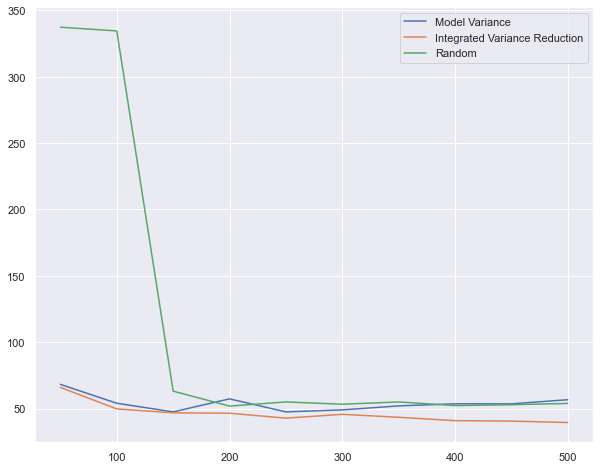

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
X_mv, Y_mv = zip(*mses_MV)
X_ivr, Y_ivr = zip(*mses_IVR)
X_rnd, Y_rnd = zip(*mses_RND)
ax.plot(X_mv, Y_mv, label='Model Variance')
ax.plot(X_ivr, Y_ivr, label='Integrated Variance Reduction')
ax.plot(X_rnd, Y_rnd, label='Random')
ax.legend()

### Save Models

In [31]:
with open(f'experimental_design/models/ms_5param_model_variance_20_init_points_500_loops_co2_per_duration.pkl', "wb") as f:
     pickle.dump(emukit_model_mv, f)

with open(f'experimental_design/models/ms_5param_integrated_variance_reduction_20_init_points_500_loops_co2_per_duration.pkl', "wb") as f:
     pickle.dump(emukit_model_ivr, f)
        
with open(f'experimental_design/models/ms_5param_520_random_points_supervised_GP_co2_per_duration.pkl', "wb") as f:
     pickle.dump(emukit_model_rnd, f)
        
with open(f'experimental_design/models/ms_mses.pkl', 'wb') as f:
    pickle.dump((mses_MV, mses_IVR, mses_RND), f)